# SC 1015 Mini-Project (FCE3_Team 9)

by Raja Muthu and Lennard Ng Weijie

### Importing all Essential Libraries

In [1]:
# import all libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import plot_tree
from tabulate import tabulate

### Step 1: Importing dataset & Data Cleaning
First we import the dataset and filter out the relevant data according to roles and their relevant variables.
Some of our values had question marks in them as such had to be filtered out, using regex. 
There were also 143 variables for us to assess so we sieved out a few relevant variables for each position that is important to us, namely the Forwards(FW), Midfielders(MF) and Defender(DF)

In [2]:
Data2122 = pd.read_csv('2021-2022 Football Player Stats.csv', sep = ';', encoding='latin-1')
FW_Data = Data2122[Data2122['Pos'] == 'FW'].copy()
MF_Data = Data2122[Data2122['Pos'] == 'MF'].copy()
DF_Data = Data2122[Data2122['Pos'] == 'DF'].copy()
FW_Relevant = FW_Data[['Player', 'Goals', 'Shots', 'SoT', 'G/Sh', 'G/SoT', 'SCA', 'GCA', 'TouAttPen', 'CPA']].replace('\?', '', regex=True)
MF_Relevant = MF_Data[['Player', 'PasShoCmp', 'PasMedCmp', 'PasLonCmp', 'PasShoCmp%', 'PasMedCmp%', 'PasLonCmp%', 'PasProg', 'PPA', 'Int', 'Tkl', 'Carries', 'CarProg', 'SCA', 'GCA']].replace('\?', '', regex=True)
DF_Relevant = DF_Data[['Player', 'Tkl', 'Int', 'Clr', 'BlkSh', 'BlkPass', 'TklDef3rd', 'TklMid3rd', 'PasTotCmp%', 'PasLonCmp%', 'AerWon%', 'AerWon']].replace('\?', '', regex=True)
Data2122.head()

Rk             Player Nation Pos          Squad            Comp   Age  \
0   1         Max Aarons    ENG  DF   Norwich City  Premier League  22.0   
1   2   Yunis Abdelhamid    MAR  DF          Reims         Ligue 1  34.0   
2   3  Salis Abdul Samed    GHA  MF  Clermont Foot         Ligue 1  22.0   
3   4    Laurent Abergel    FRA  MF        Lorient         Ligue 1  29.0   
4   5        Charles Abi    FRA  FW  Saint-Étienne         Ligue 1  22.0   

   Born  MP  Starts  ...   Off   Crs  TklW  PKwon  PKcon    OG  Recov  AerWon  \
0  2000  34      32  ...  0.03  1.41  1.16    0.0   0.06  0.03   5.53    0.47   
1  1987  34      34  ...  0.00  0.06  1.39    0.0   0.03  0.00   6.77    2.02   
2  2000  31      29  ...  0.00  0.36  1.24    0.0   0.00  0.00   8.76    0.88   
3  1993  34      34  ...  0.03  0.79  2.23    0.0   0.00  0.00   8.87    0.43   
4  2000   1       1  ...  0.00  2.00  0.00    0.0   0.00  0.00   4.00    2.00   

   AerLost  AerWon%  
0     1.59     22.7  
1     1.36     59.8  
2     0.88     50.0  
3     0.43     50.0  
4     0.00    100.0  

[5 rows x 143 columns]

In [3]:
print("Data dimensions:\n", Data2122.shape)
print()
print("Data types:\n",Data2122.dtypes)
print()
print("Data description:\n", Data2122.describe())

Data dimensions:
 (2921, 143)

Data types:
 Rk           int64
Player      object
Nation      object
Pos         object
Squad       object
            ...   
OG         float64
Recov      float64
AerWon     float64
AerLost    float64
AerWon%    float64
Length: 143, dtype: object

Data description:
                 Rk          Age         Born           MP       Starts  \
count  2921.000000  2920.000000  2921.000000  2921.000000  2921.000000   
mean   1461.000000    26.092123  1994.725094    18.800068    13.749743   
std     843.364393     4.641746    37.210426    11.619882    11.393763   
min       1.000000    16.000000     0.000000     1.000000     0.000000   
25%     731.000000    23.000000  1992.000000     8.000000     3.000000   
50%    1461.000000    26.000000  1996.000000    20.000000    12.000000   
75%    2191.000000    29.000000  1999.000000    29.000000    23.000000   
max    2921.000000    41.000000  2006.000000    38.000000    38.000000   

               Min          90s  

In [4]:
# a. check for duplicates
print('Number of duplicates in the dataset: {}'.format(sum(Data2122.duplicated())))
# b. check for NaN or Null value
print('We have {} NaN/Null values in the dataset'.format(Data2122.isnull().values.sum()))

#check which column has Null values
for column in Data2122:
    for cell in Data2122[column].isna():
        if cell==True:
            print(column)

Number of duplicates in the dataset: 0
We have 2 NaN/Null values in the dataset
Nation
Age


#### Null Values

We have identified that the Null values are in the Nation and Age columns, which we have identified as irrelevant data when analysing, and thus would have already been dropped.

### Step 2:  Exploratory Data Analysis 
This dataset contains the statistics of more than  2900 players (per 90 minutes, which is usually the duration of a football match) that have played in the 2021-2022 season. All these players only play in the top 6 football leagues, which is the Premier League, Ligue 1, Bundesliga, Serie A and La Liga. This dataset is generally based on the players' performance in each aspect of the game.  
We wanted to identify the relationship between all the relevant variables for each position to pick the right predictor variable for each positions. We also wanted to find the right models that can be used to compare and look at variables that can be used for each position.

FW_X, MF_X and DF_X is used to quicly access the relavant variables that need to be analysed in this case

In [5]:
FW_X = FW_Relevant[['Goals', 'Shots', 'SoT', 'SCA', 'GCA', 'TouAttPen', 'CPA']]
MF_X = MF_Relevant[['PasShoCmp', 'PasMedCmp', 'PasLonCmp', 'PasProg', 'PPA', 'Int', 'Tkl', 'Carries', 'CarProg', 'SCA', 'GCA']]
DF_X = DF_Relevant[['BlkSh', 'BlkPass', 'TklDef3rd', 'TklMid3rd', 'PasTotCmp%', 'PasLonCmp%', 'AerWon%', 'AerWon']]

###### We used both the correlation matrix and the pairplots to look at the relationships both graphically and numerically

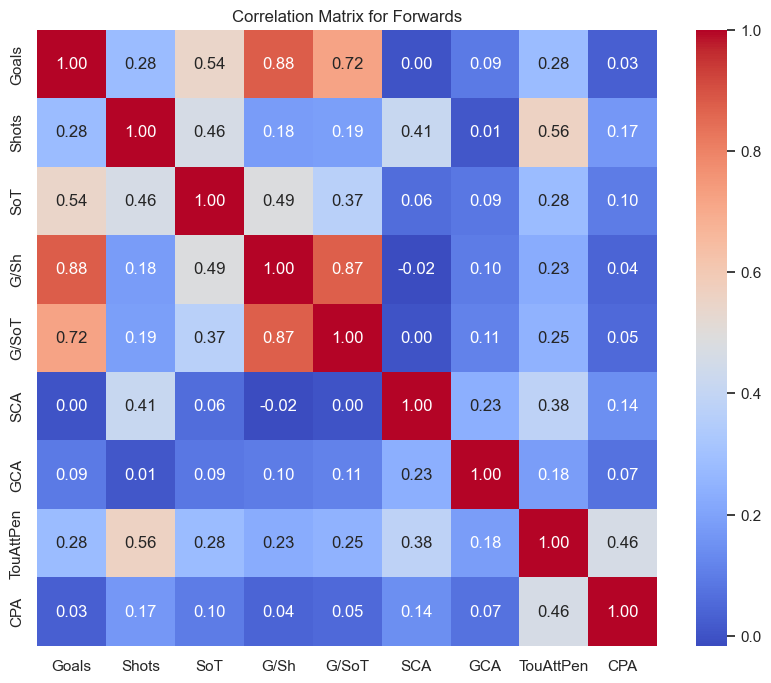

In [6]:
# Correlation matrix for forwards' features
FW_corr_matrix = FW_Relevant.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sb.heatmap(FW_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Forwards')
plt.show()

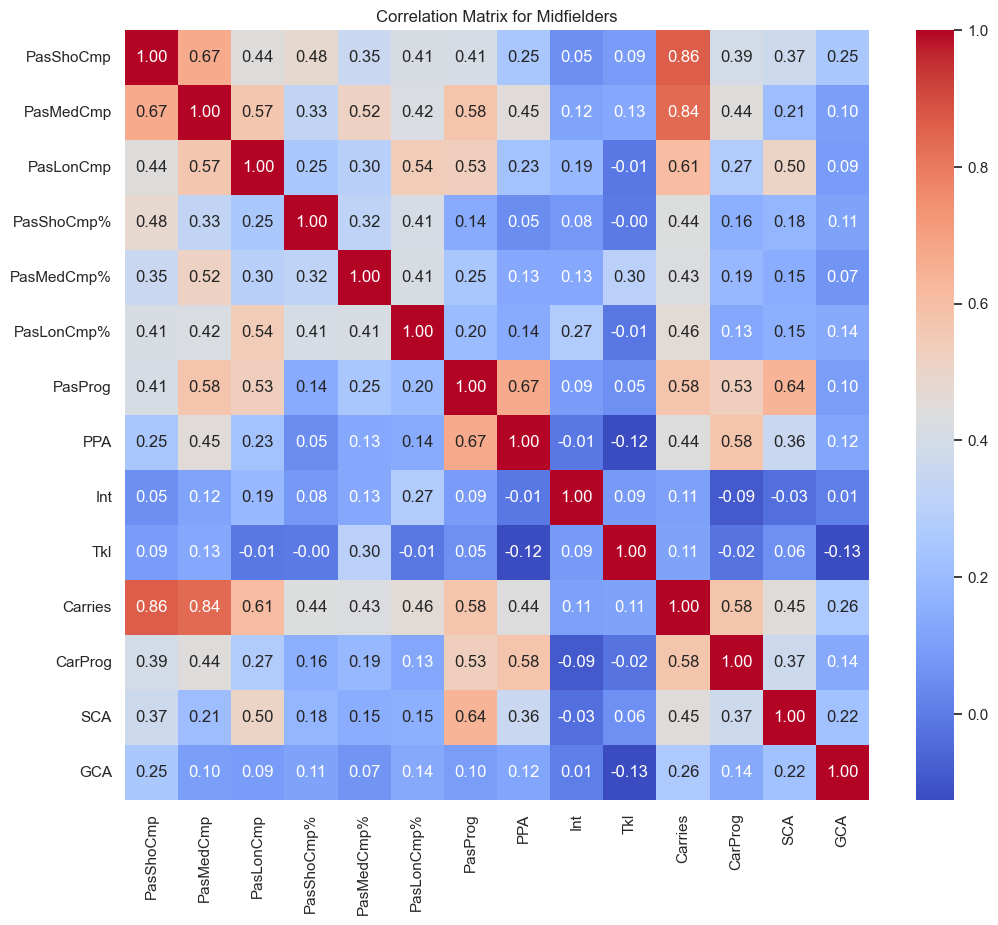

In [7]:
# Correlation matrix for midfielders' features
MF_corr_matrix = MF_Relevant.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sb.heatmap(MF_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Midfielders')
plt.show()

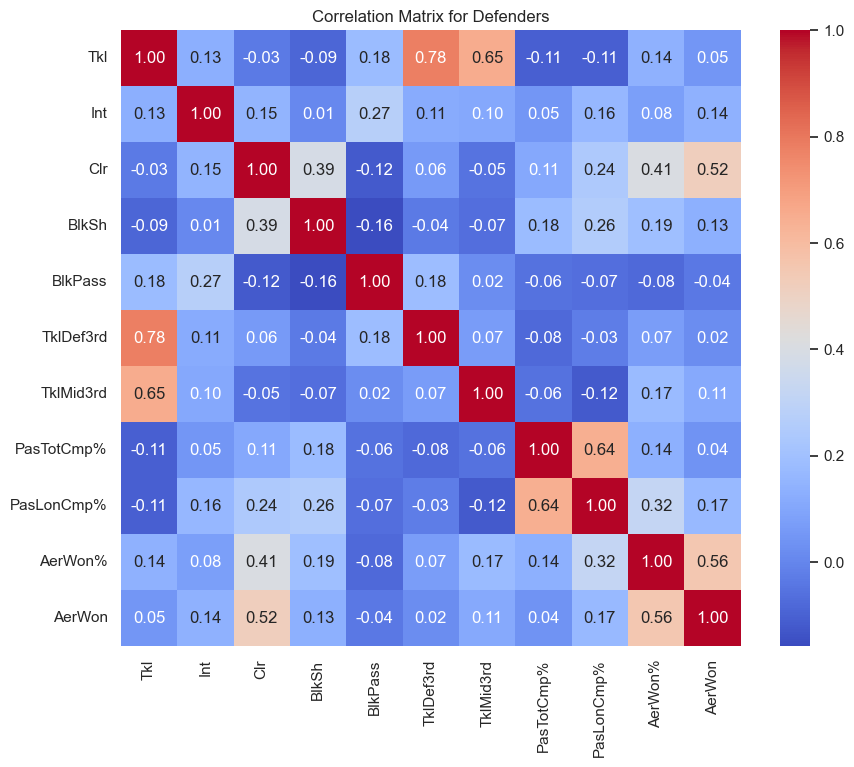

In [8]:
# Correlation matrix for defenders' features
DF_corr_matrix = DF_Relevant.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sb.heatmap(DF_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Defenders')
plt.show()


C:\Users\Muthu\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Muthu\AppData\Local\Temp\ipykernel_36628\1672345245.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

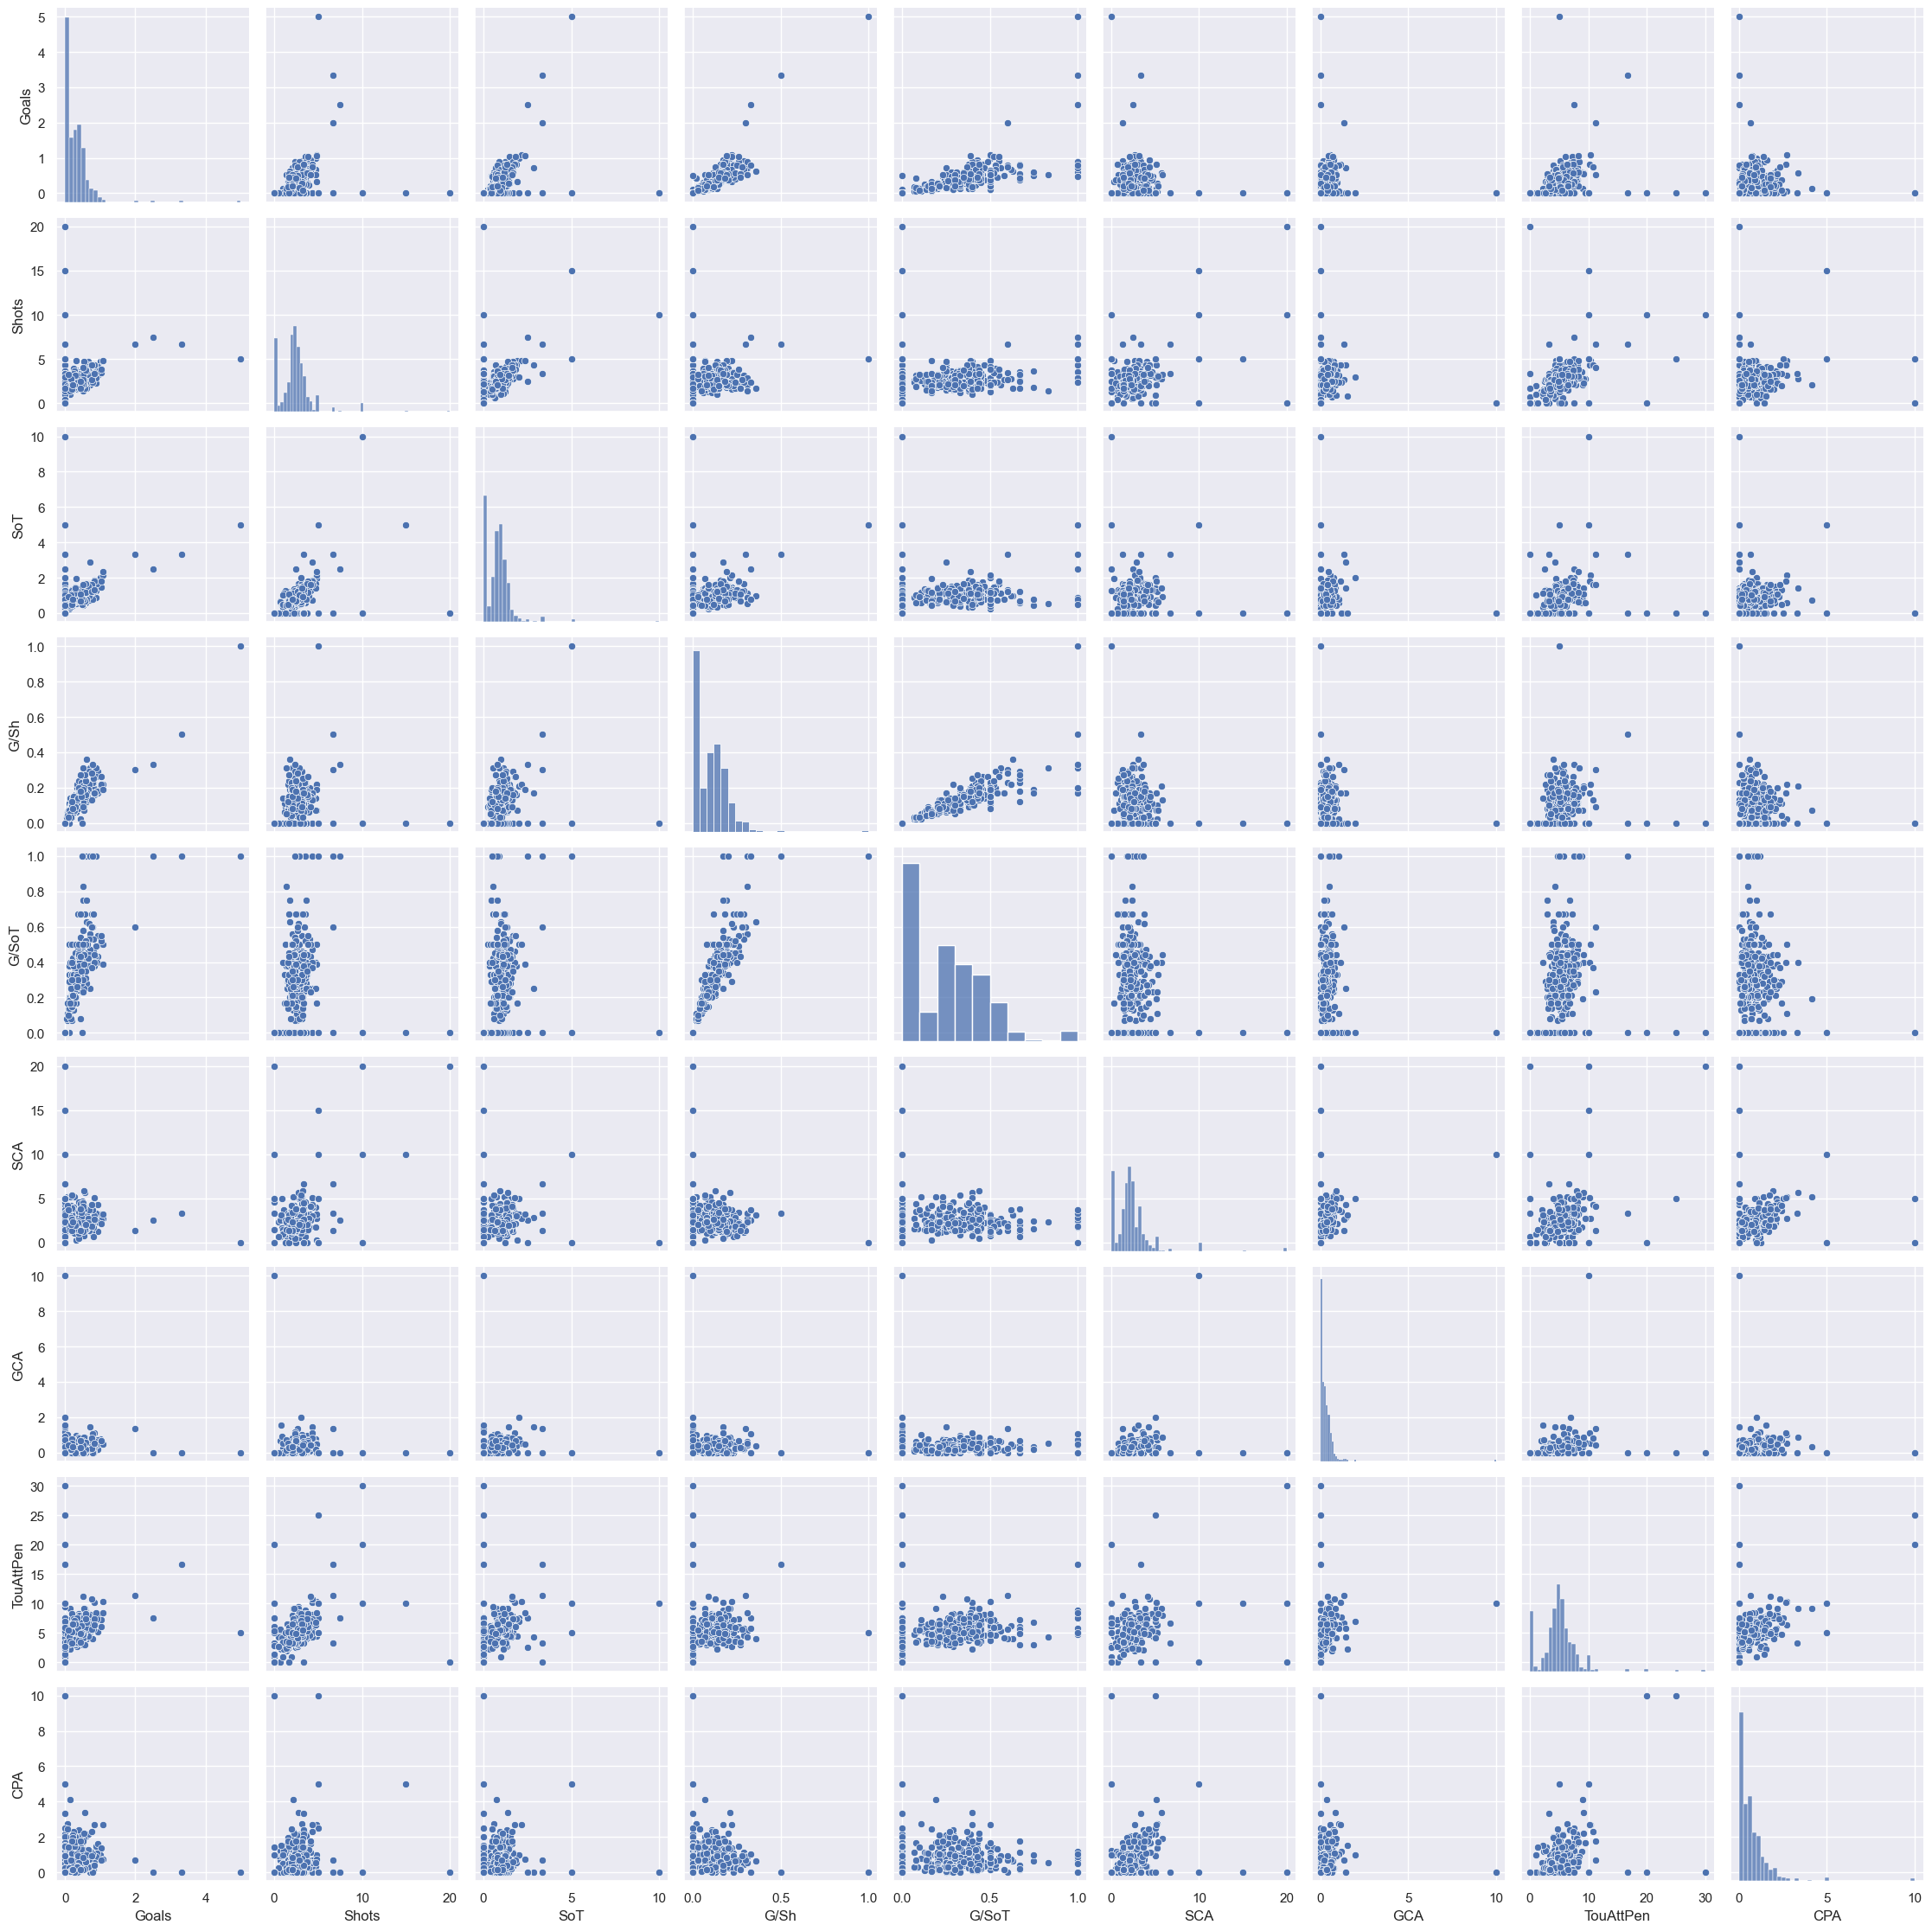

In [9]:
# pairplot for forwards
plt.figure(figsize=(12, 8))
sb.pairplot(FW_Relevant, height=2.5)
plt.tight_layout()
plt.show()

C:\Users\Muthu\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Muthu\AppData\Local\Temp\ipykernel_36628\2107685661.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

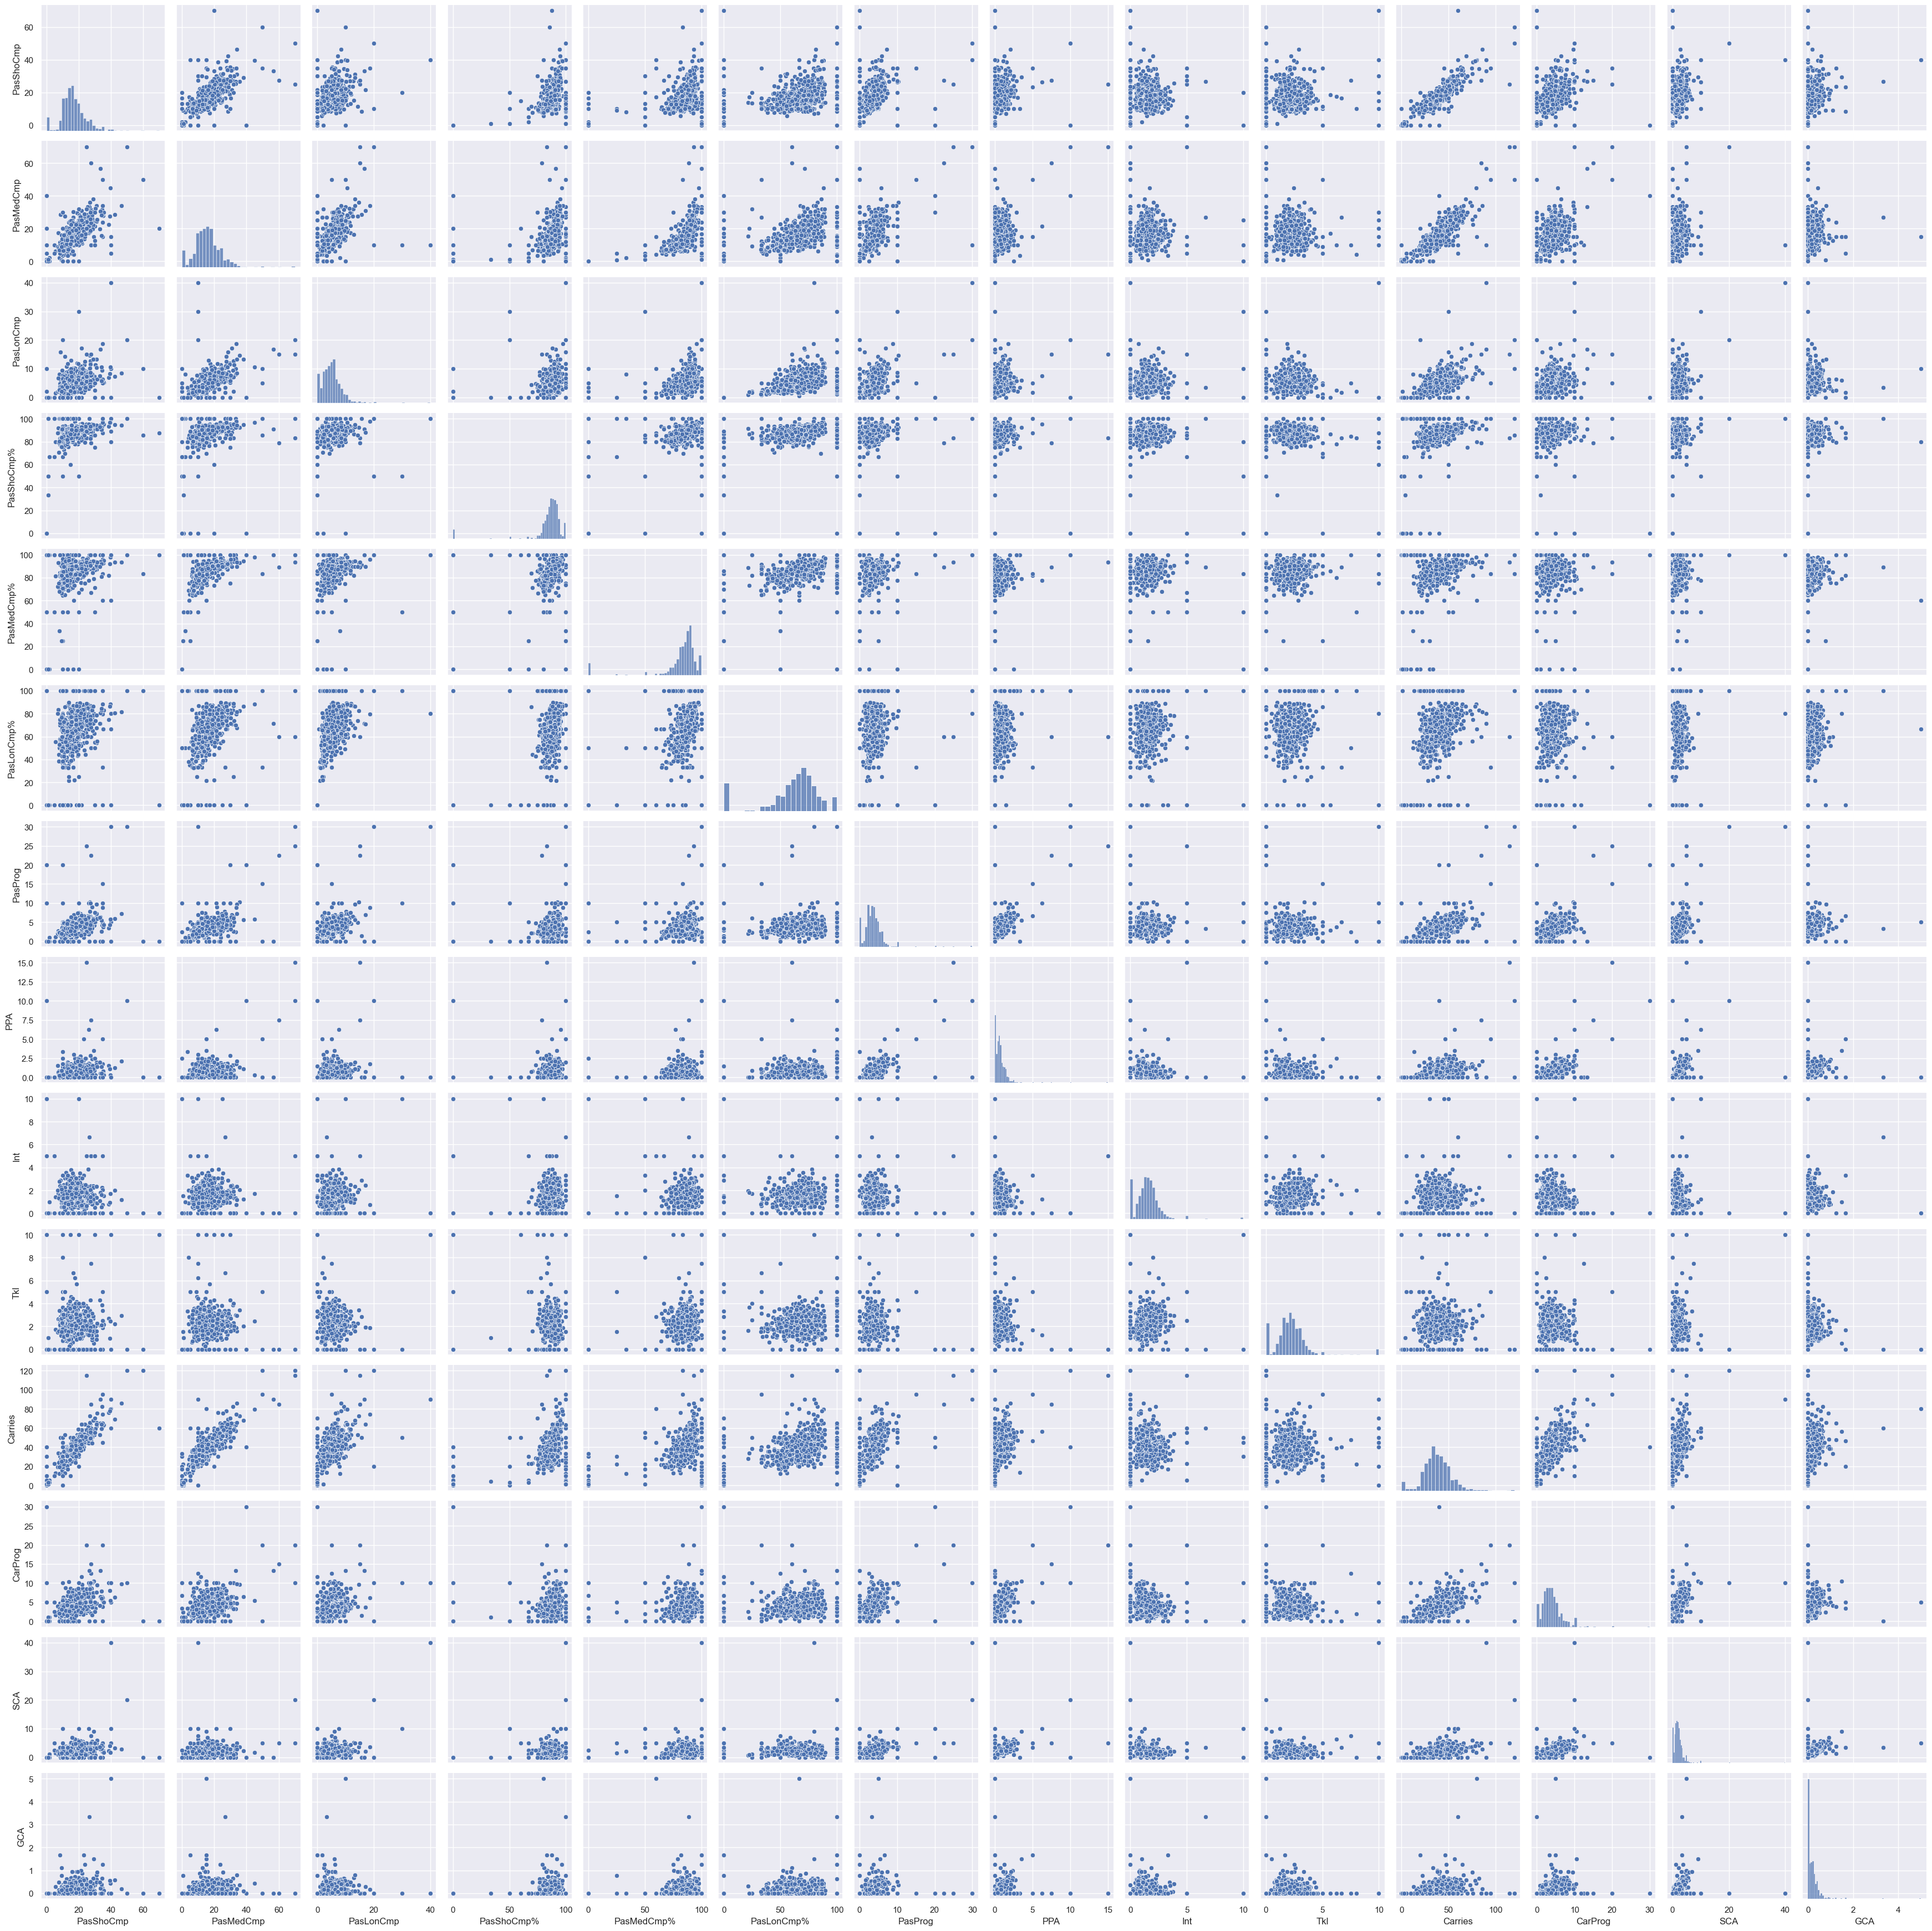

In [10]:
# pairplot for midfielders
plt.figure(figsize=(12, 8))
sb.pairplot(MF_Relevant, height=2.5)
plt.tight_layout()
plt.show()

C:\Users\Muthu\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Muthu\AppData\Local\Temp\ipykernel_36628\1451490786.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

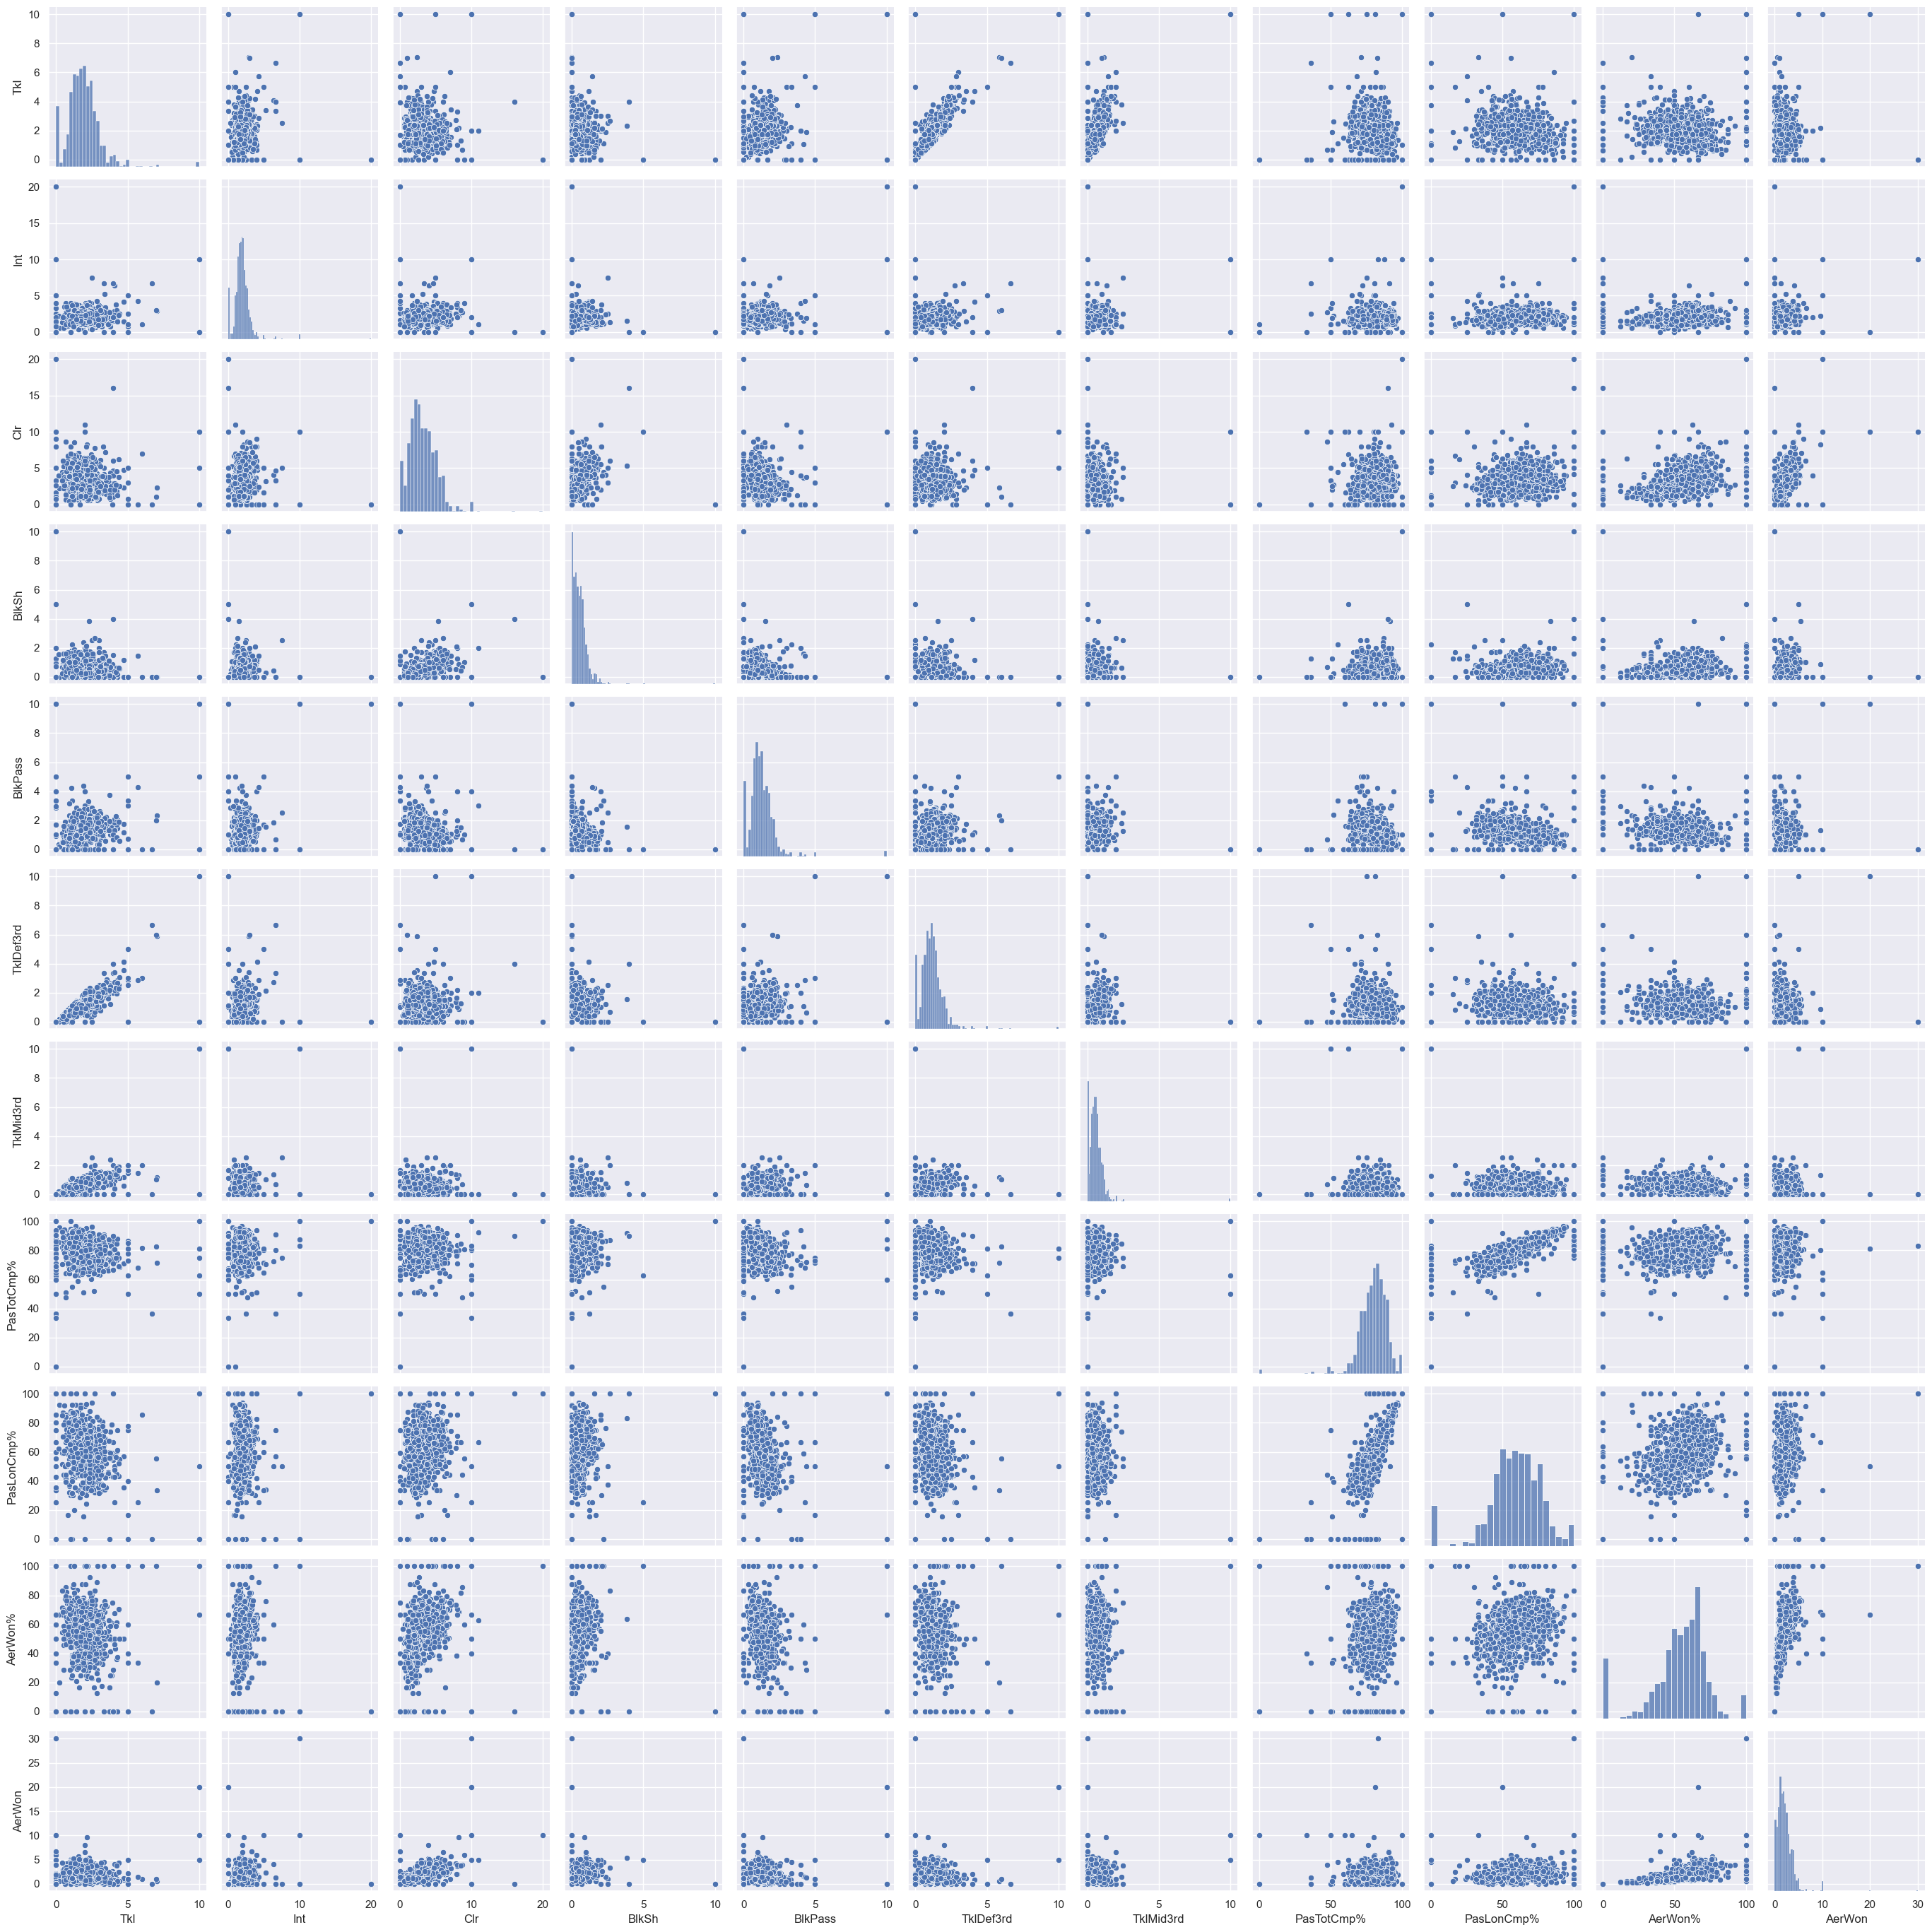

In [11]:
# pairplot for defenders
plt.figure(figsize=(12, 8))
sb.pairplot(DF_Relevant, height=2.5)
plt.tight_layout()
plt.show()

###### Based on the correlation matrix and the pairplots, we decided to pick a few key variables that are important and can be predicted. Among all the relevant variables, these few variables below showed the most relation

In [12]:
FW_Y_GSh = FW_Relevant['G/Sh']
FW_Y_GSoT = FW_Relevant['G/SoT']
MF_Y_Sho = MF_Relevant['PasShoCmp%']
MF_Y_Med = MF_Relevant['PasMedCmp%']
MF_Y_Lon = MF_Relevant['PasLonCmp%']
DF_Y_Tkl = DF_Relevant['Tkl']
DF_Y_Int = DF_Relevant['Int']
DF_Y_Clr = DF_Relevant['Clr']

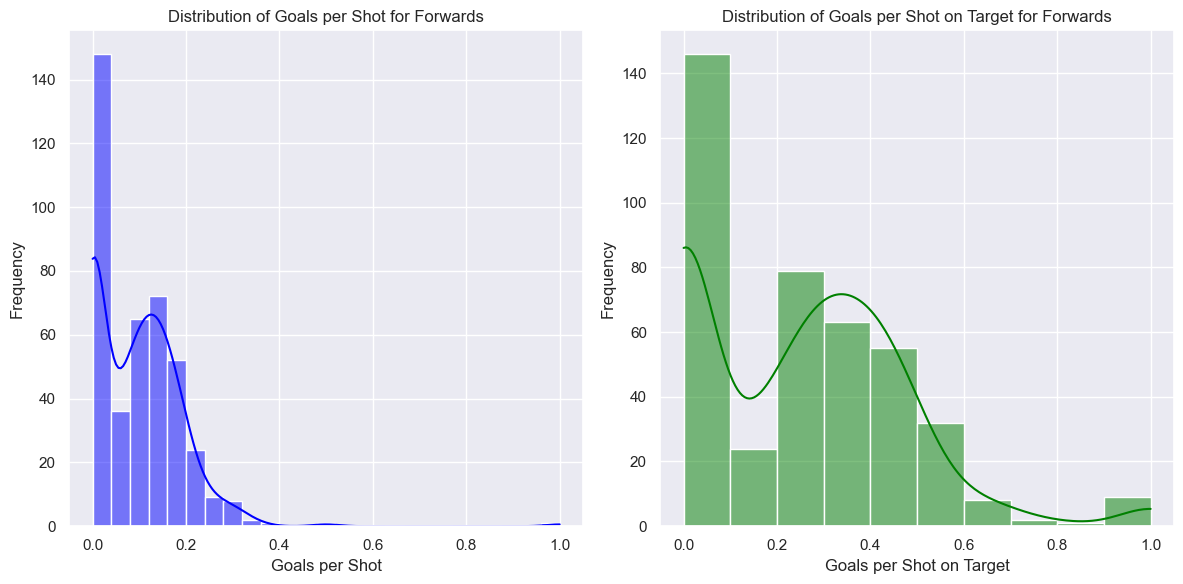

In [13]:
# Forwards
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sb.histplot(FW_Y_GSh, kde=True, color='blue')
plt.title('Distribution of Goals per Shot for Forwards')
plt.xlabel('Goals per Shot')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sb.histplot(FW_Y_GSoT, kde=True, color='green')
plt.title('Distribution of Goals per Shot on Target for Forwards')
plt.xlabel('Goals per Shot on Target')
plt.ylabel('Frequency')

plt.tight_layout()  
plt.show()


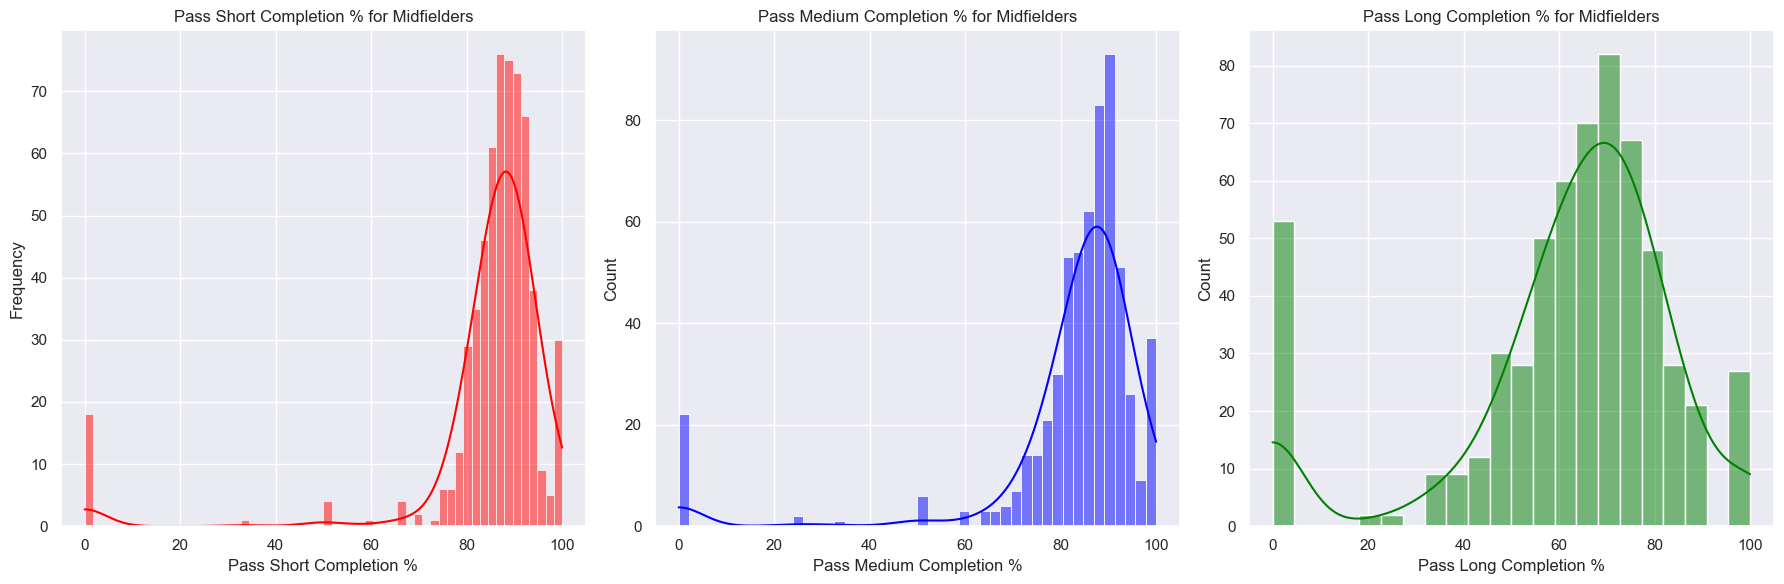

In [14]:
# Midfielders
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sb.histplot(MF_Y_Sho, kde=True, color='red')
plt.title('Pass Short Completion % for Midfielders')
plt.xlabel('Pass Short Completion %')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sb.histplot(MF_Y_Med, kde=True, color='blue')
plt.title('Pass Medium Completion % for Midfielders')
plt.xlabel('Pass Medium Completion %')

plt.subplot(1, 3, 3)
sb.histplot(MF_Y_Lon, kde=True, color='green')
plt.title('Pass Long Completion % for Midfielders')
plt.xlabel('Pass Long Completion %')

plt.tight_layout()
plt.show()


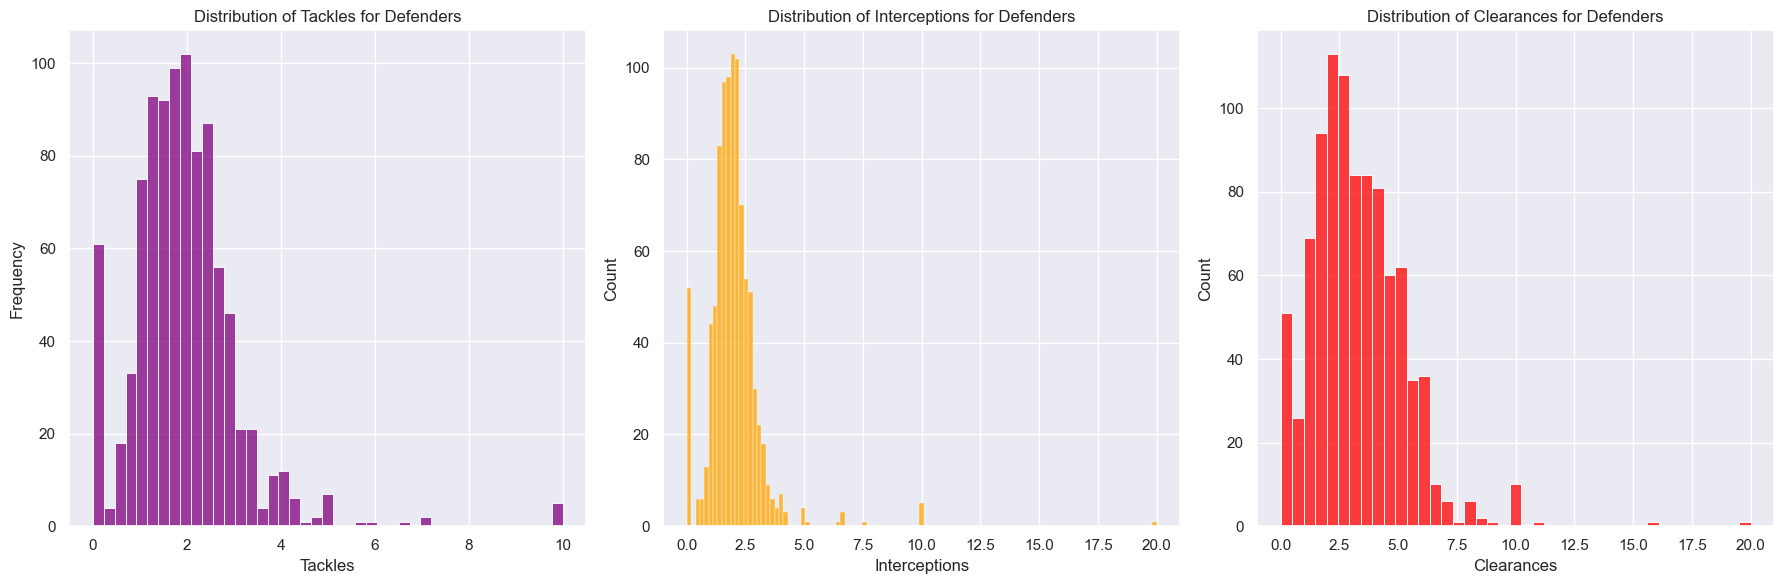

In [15]:
# Defenders
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sb.histplot(DF_Y_Tkl, kde=False, color='purple')
plt.title('Distribution of Tackles for Defenders')
plt.xlabel('Tackles')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sb.histplot(DF_Y_Int, kde=False, color='orange')
plt.title('Distribution of Interceptions for Defenders')
plt.xlabel('Interceptions')

plt.subplot(1, 3, 3)
sb.histplot(DF_Y_Clr, kde=False, color='red')
plt.title('Distribution of Clearances for Defenders')
plt.xlabel('Clearances')

plt.tight_layout()
plt.show()

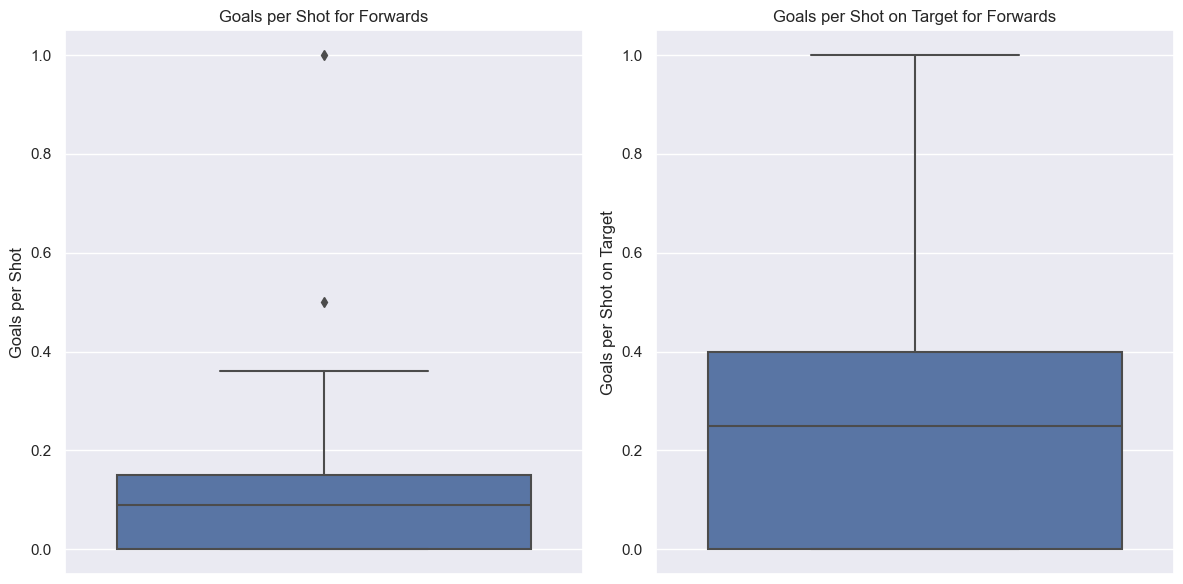

In [16]:
# Boxplot on Forwards
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sb.boxplot(y=FW_Y_GSh)
plt.title('Goals per Shot for Forwards')
plt.ylabel('Goals per Shot')

plt.subplot(1, 2, 2)
sb.boxplot(y=FW_Y_GSoT)
plt.title('Goals per Shot on Target for Forwards')
plt.ylabel('Goals per Shot on Target')

plt.tight_layout()
plt.show()

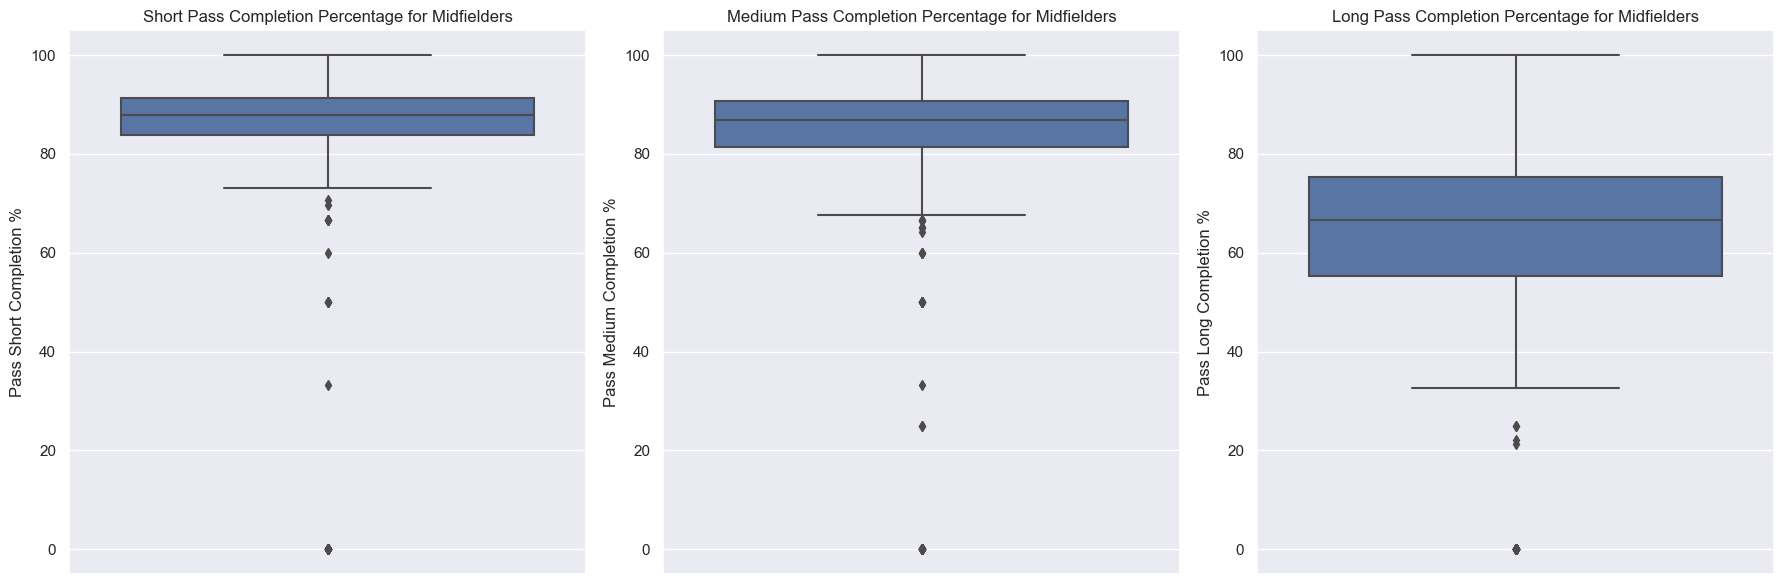

In [17]:
# Boxplot on Midfielders
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sb.boxplot(y=MF_Relevant['PasShoCmp%'])
plt.title('Short Pass Completion Percentage for Midfielders')
plt.ylabel('Pass Short Completion %')

plt.subplot(1, 3, 2)
sb.boxplot(y=MF_Relevant['PasMedCmp%'])
plt.title('Medium Pass Completion Percentage for Midfielders')
plt.ylabel('Pass Medium Completion %')

plt.subplot(1, 3, 3)
sb.boxplot(y=MF_Relevant['PasLonCmp%'])
plt.title('Long Pass Completion Percentage for Midfielders')
plt.ylabel('Pass Long Completion %')

plt.tight_layout()
plt.show()

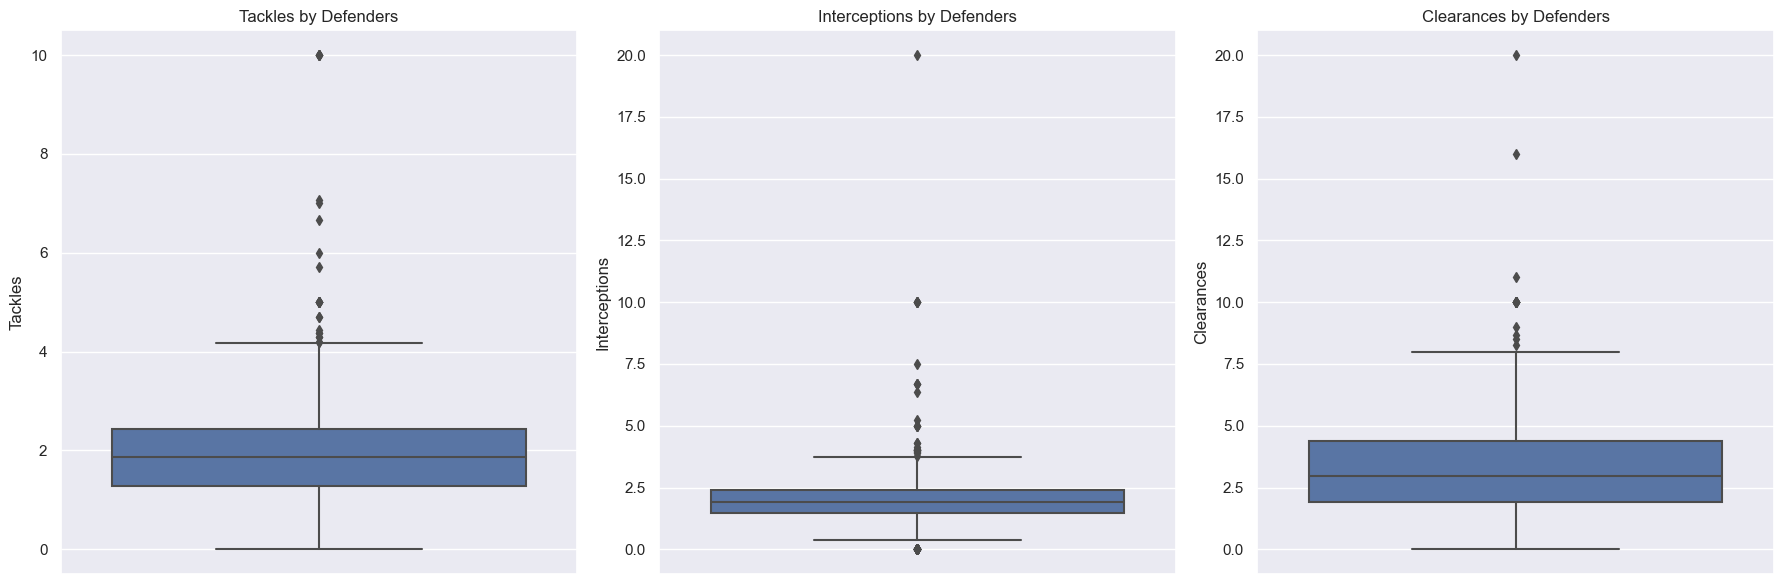

In [18]:
# Boxplot on Defenders
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sb.boxplot(y=DF_Relevant['Tkl'])
plt.title('Tackles by Defenders')
plt.ylabel('Tackles')

plt.subplot(1, 3, 2)
sb.boxplot(y=DF_Relevant['Int'])
plt.title('Interceptions by Defenders')
plt.ylabel('Interceptions')

plt.subplot(1, 3, 3)
sb.boxplot(y=DF_Relevant['Clr'])
plt.title('Clearances by Defenders')
plt.ylabel('Clearances')

plt.tight_layout()
plt.show()


Both the Histogram and the Boxplots show the range of the values for each key variable, providing us with a sense on how to predict them. For example, we can see for the Forwards the Goals/ Shot on Target was analysed. In the histogram, it showed a very clear distribution of the values with relation to the number of players. While the boxplot suggested that almost 50% of data is between 0 to 0.4

### Step 3: Train-Test Split
Since we are working with 3 different roles, with 2, 3, 3 target variables respectively, there are a total of 7 Train-Test split sets that we have to generate. We generate a random number from 0 to 100 to be used as the random_state to ensure that the result is random everytime, but consistent throughout the set.

In [19]:
random = np.random.randint(0, 100)

FW_X_Train, FW_X_Test, FW_Y_Train_GSh, FW_Y_Test_GSh = train_test_split(FW_X, FW_Y_GSh, test_size=0.2, random_state=random)
FW_X_Train, FW_X_Test, FW_Y_Train_GSoT, FW_Y_Test_GSoT = train_test_split(FW_X, FW_Y_GSoT, test_size=0.2, random_state=random)
MF_X_Train, MF_X_Test, MF_Y_Train_Sho, MF_Y_Test_Sho = train_test_split(MF_X, MF_Y_Sho, test_size=0.2, random_state=random)
MF_X_Train, MF_X_Test, MF_Y_Train_Med, MF_Y_Test_Med = train_test_split(MF_X, MF_Y_Med, test_size=0.2, random_state=random)
MF_X_Train, MF_X_Test, MF_Y_Train_Lon, MF_Y_Test_Lon = train_test_split(MF_X, MF_Y_Lon, test_size=0.2, random_state=random)
DF_X_Train, DF_X_Test, DF_Y_Train_Tkl, DF_Y_Test_Tkl = train_test_split(DF_X, DF_Y_Tkl, test_size=0.2, random_state=random)
DF_X_Train, DF_X_Test, DF_Y_Train_Int, DF_Y_Test_Int = train_test_split(DF_X, DF_Y_Int, test_size=0.2, random_state=random)
DF_X_Train, DF_X_Test, DF_Y_Train_Clr, DF_Y_Test_Clr = train_test_split(DF_X, DF_Y_Clr, test_size=0.2, random_state=random)


# Step 4a: Linear Regression
We start with Linear Regression for each set. We fit the Train data through through Linear Regression and create another column in the dataframe for the predicted values.

We plotted the predicted values against the actual values for the Train and Test data, then calculated the R2 and MSE of each model. This gives us an idea of how accurate the predictive model is. This will be done for every model in this project.

Finally, we plotted all the predicted values from the model against the actual values in the dataset.

In [20]:
model_FW_GSh = LinearRegression()
model_FW_GSh.fit(FW_X_Train, FW_Y_Train_GSh)
model_FW_GSoT = LinearRegression()
model_FW_GSoT.fit(FW_X_Train, FW_Y_Train_GSoT)

model_MF_Sho = LinearRegression()
model_MF_Sho.fit(MF_X_Train, MF_Y_Train_Sho)
model_MF_Med = LinearRegression()
model_MF_Med.fit(MF_X_Train, MF_Y_Train_Med)
model_MF_Lon = LinearRegression()
model_MF_Lon.fit(MF_X_Train, MF_Y_Train_Lon)

model_DF_Tkl = LinearRegression()
model_DF_Tkl.fit(DF_X_Train, DF_Y_Train_Tkl)
model_DF_Int = LinearRegression()
model_DF_Int.fit(DF_X_Train, DF_Y_Train_Int)
model_DF_Clr = LinearRegression()
model_DF_Clr.fit(DF_X_Train, DF_Y_Train_Clr)

FW_Relevant['P_G/Sh_LR'] = model_FW_GSh.predict(FW_X)
FW_Relevant['P_G/SoT_LR'] = model_FW_GSoT.predict(FW_X)
MF_Relevant['P_PasCmpSho%_LR'] = model_MF_Sho.predict(MF_X)
MF_Relevant['P_PasCmpMed%_LR'] = model_MF_Med.predict(MF_X)
MF_Relevant['P_PasCmpLon%_LR'] = model_MF_Lon.predict(MF_X)
DF_Relevant['P_Tkl_LR'] = model_DF_Tkl.predict(DF_X)
DF_Relevant['P_Int_LR'] = model_DF_Int.predict(DF_X)
DF_Relevant['P_Clr_LR'] = model_DF_Clr.predict(DF_X)
FW_Relevant.round(2)
MF_Relevant.round(2)
DF_Relevant.round(2)

Player   Tkl   Int   Clr  BlkSh  BlkPass  TklDef3rd  \
0               Max Aarons  2.16  1.75  2.19   0.69     2.00       1.56   
1         Yunis Abdelhamid  1.87  3.11  3.20   0.79     1.09       1.24   
8               Luis Abram  1.13  1.77  6.29   0.81     1.29       0.81   
9         Francesco Acerbi  0.96  1.70  4.08   1.06     0.64       0.64   
12            Marcos Acuña  2.31  1.24  1.20   0.16     1.27       1.31   
...                    ...   ...   ...   ...    ...      ...        ...   
2906  Christoph Zimmermann  2.94  1.76  1.76   0.00     0.00       1.76   
2907   Oleksandr Zinchenko  1.72  1.55  1.12   0.26     1.29       0.60   
2912        Banhie Zoukrou  1.11  2.22  1.11   0.00     0.00       1.11   
2913            Kurt Zouma  0.48  2.03  6.06   1.17     0.48       0.39   
2915         Igor Zubeldia  1.42  1.69  3.44   0.49     0.98       0.93   

      TklMid3rd  PasTotCmp%  PasLonCmp%  AerWon%  AerWon  P_Tkl_LR  P_Int_LR  \
0          0.59        75.5        45.2     22.7    0.47      2.35      2.20   
1          0.60        82.4        61.7     59.8    2.02      1.98      1.94   
8          0.16        88.2        75.0     44.4    1.94      1.08      2.06   
9          0.32        90.3        77.1     64.0    2.84      1.03      1.83   
12         0.60        79.4        58.0     47.1    1.31      2.09      1.99   
...         ...         ...         ...      ...     ...       ...       ...   
2906       1.18        72.7        47.1     66.7    1.18      3.15      1.56   
2907       0.86        89.3        73.0     51.5    1.47      1.62      2.17   
2912       0.00        92.3        75.0     33.3    1.11      1.20      1.52   
2913       0.09        88.9        70.3     68.8    2.38      0.55      1.62   
2915       0.49        88.8        78.4     55.2    2.62      1.53      2.03   

      P_Clr_LR  
0         2.17  
1         3.47  
8         3.41  
9         4.28  
12        2.46  
...        ...  
2906      2.51  
2907      2.37  
2912      2.44  
2913      4.17  
2915      3.57  

[942 rows x 15 columns]

Goodness of Fit of Model 	Train G/Sh Dataset
Explained Variance (R^2) 	: 0.7839866168509081
Mean Squared Error (MSE) 	: 0.0021460664471344313
Goodness of Fit of Model 	Test G/Sh Dataset
Explained Variance (R^2) 	: 0.7129878121334163
Mean Squared Error (MSE) 	: 0.0017888921352789285

Goodness of Fit of Model 	Train G/SoT Dataset
Explained Variance (R^2) 	: 0.5308277369973203
Mean Squared Error (MSE) 	: 0.024100418230468587
Goodness of Fit of Model 	Test G/SoT Dataset
Explained Variance (R^2) 	: 0.4885343563909378
Mean Squared Error (MSE) 	: 0.025021361750038745


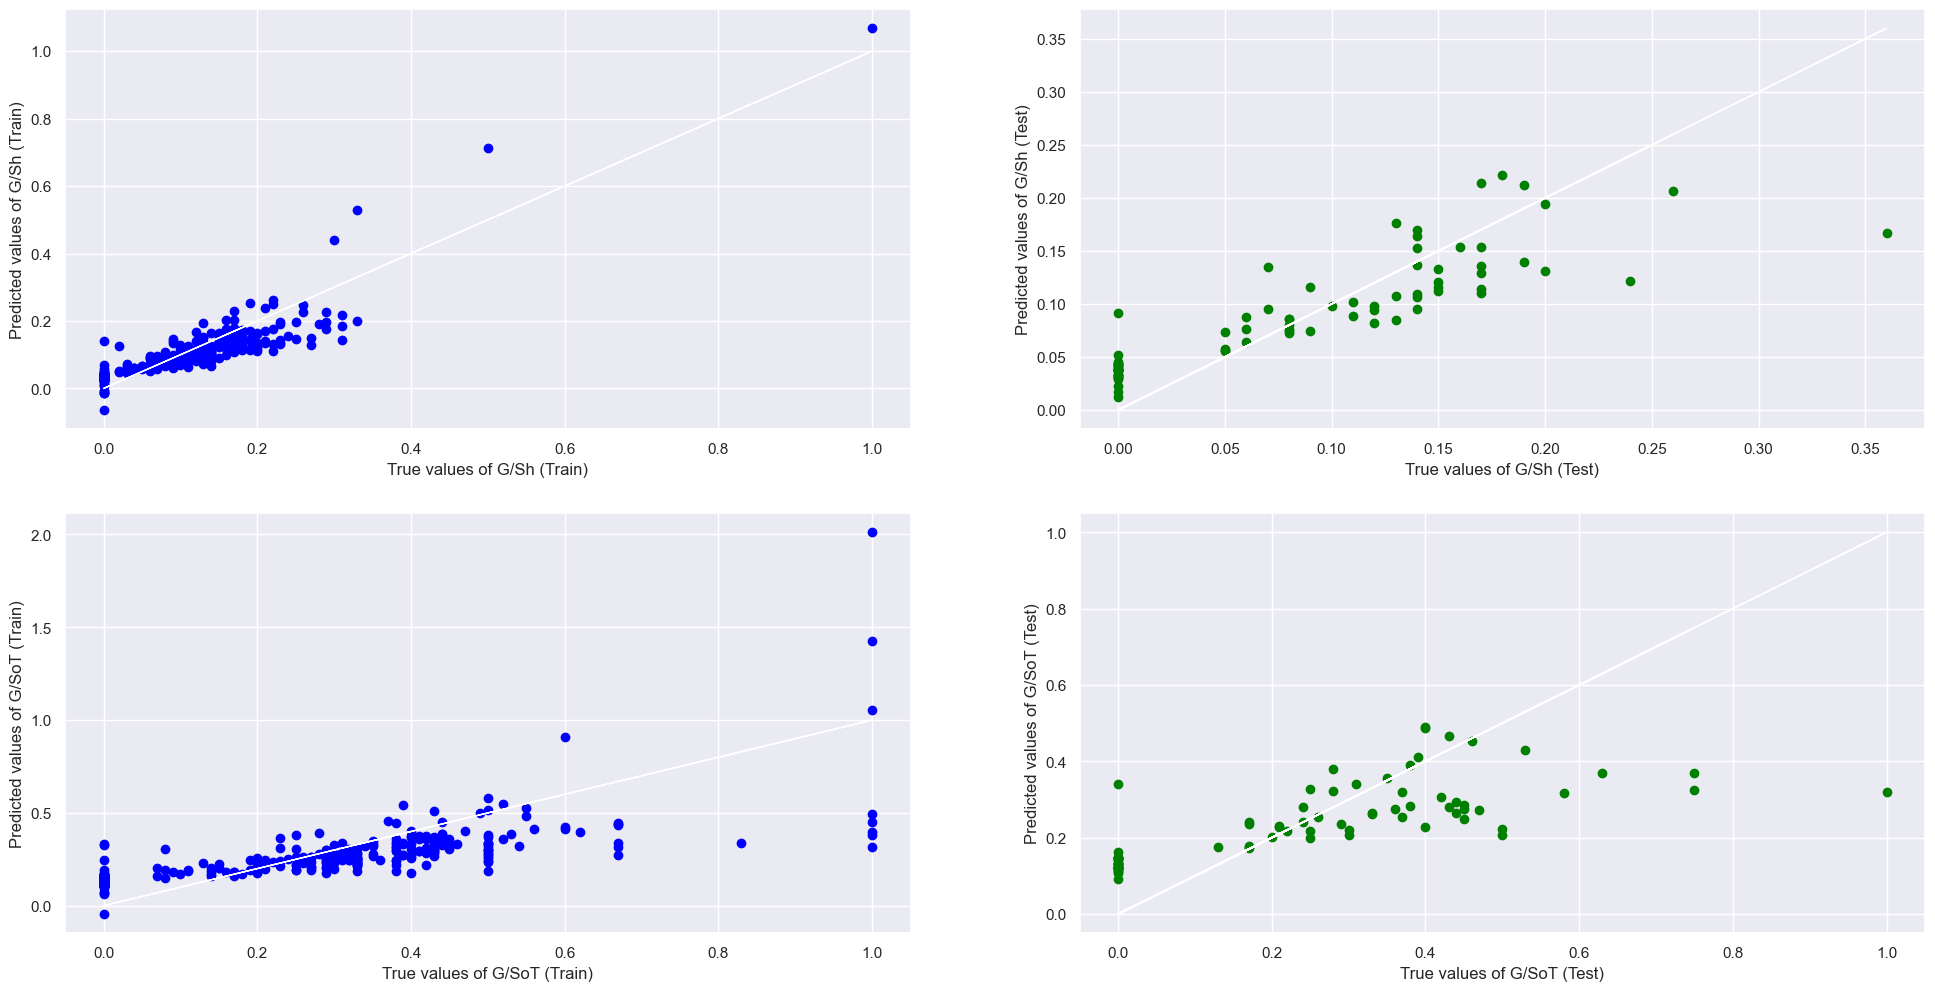

In [21]:
f, axes = plt.subplots(2, 2, figsize=(24, 12))
axes[0][0].scatter(FW_Y_Train_GSh, model_FW_GSh.predict(FW_X_Train), color = "blue")
axes[0][0].plot(FW_Y_Train_GSh, FW_Y_Train_GSh, 'w-', linewidth = 1)
axes[0][0].set_xlabel("True values of G/Sh (Train)")
axes[0][0].set_ylabel("Predicted values of G/Sh (Train)")
axes[0][1].scatter(FW_Y_Test_GSh, model_FW_GSh.predict(FW_X_Test), color = "green")
axes[0][1].plot(FW_Y_Test_GSh, FW_Y_Test_GSh, 'w-', linewidth = 1)
axes[0][1].set_xlabel("True values of G/Sh (Test)")
axes[0][1].set_ylabel("Predicted values of G/Sh (Test)")

axes[1][0].scatter(FW_Y_Train_GSoT, model_FW_GSoT.predict(FW_X_Train), color = "blue")
axes[1][0].plot(FW_Y_Train_GSoT, FW_Y_Train_GSoT, 'w-', linewidth = 1)
axes[1][0].set_xlabel("True values of G/SoT (Train)")
axes[1][0].set_ylabel("Predicted values of G/SoT (Train)")
axes[1][1].scatter(FW_Y_Test_GSoT, model_FW_GSoT.predict(FW_X_Test), color = "green")
axes[1][1].plot(FW_Y_Test_GSoT, FW_Y_Test_GSoT, 'w-', linewidth = 1)
axes[1][1].set_xlabel("True values of G/SoT (Test)")
axes[1][1].set_ylabel("Predicted values of G/SoT (Test)")

print("Goodness of Fit of Model \tTrain G/Sh Dataset")
print("Explained Variance (R^2) \t:", model_FW_GSh.score(FW_X_Train, FW_Y_Train_GSh))
print("Mean Squared Error (MSE) \t:", mean_squared_error(FW_Y_Train_GSh, model_FW_GSh.predict(FW_X_Train)))
print("Goodness of Fit of Model \tTest G/Sh Dataset")
print("Explained Variance (R^2) \t:", model_FW_GSh.score(FW_X_Test, FW_Y_Test_GSh))
print("Mean Squared Error (MSE) \t:", mean_squared_error(FW_Y_Test_GSh, model_FW_GSh.predict(FW_X_Test)))
print()
print("Goodness of Fit of Model \tTrain G/SoT Dataset")
print("Explained Variance (R^2) \t:", model_FW_GSoT.score(FW_X_Train, FW_Y_Train_GSoT))
print("Mean Squared Error (MSE) \t:", mean_squared_error(FW_Y_Train_GSoT, model_FW_GSoT.predict(FW_X_Train)))
print("Goodness of Fit of Model \tTest G/SoT Dataset")
print("Explained Variance (R^2) \t:", model_FW_GSoT.score(FW_X_Test, FW_Y_Test_GSoT))
print("Mean Squared Error (MSE) \t:", mean_squared_error(FW_Y_Test_GSoT, model_FW_GSoT.predict(FW_X_Test)))

plt.show()

Goodness of Fit of Model 	Train Sho Dataset
Explained Variance (R^2) 	: 0.2639788987978523
Mean Squared Error (MSE) 	: 197.7262471315139
Goodness of Fit of Model 	Test Sho Data
Explained Variance (R^2) 	: 0.20148772552193495
Mean Squared Error (MSE) 	: 218.22847158347065

Goodness of Fit of Model 	Train Med Dataset
Explained Variance (R^2) 	: 0.367744672543582
Mean Squared Error (MSE) 	: 239.02757192744488
Goodness of Fit of Model 	Test Med Dataset
Explained Variance (R^2) 	: 0.18395540789403397
Mean Squared Error (MSE) 	: 153.89000653001779

Goodness of Fit of Model 	Train Lon Dataset
Explained Variance (R^2) 	: 0.4157548687164724
Mean Squared Error (MSE) 	: 337.57762555228504
Goodness of Fit of Model 	Test Lon Dataset
Explained Variance (R^2) 	: 0.35112680177557143
Mean Squared Error (MSE) 	: 321.6068085713847


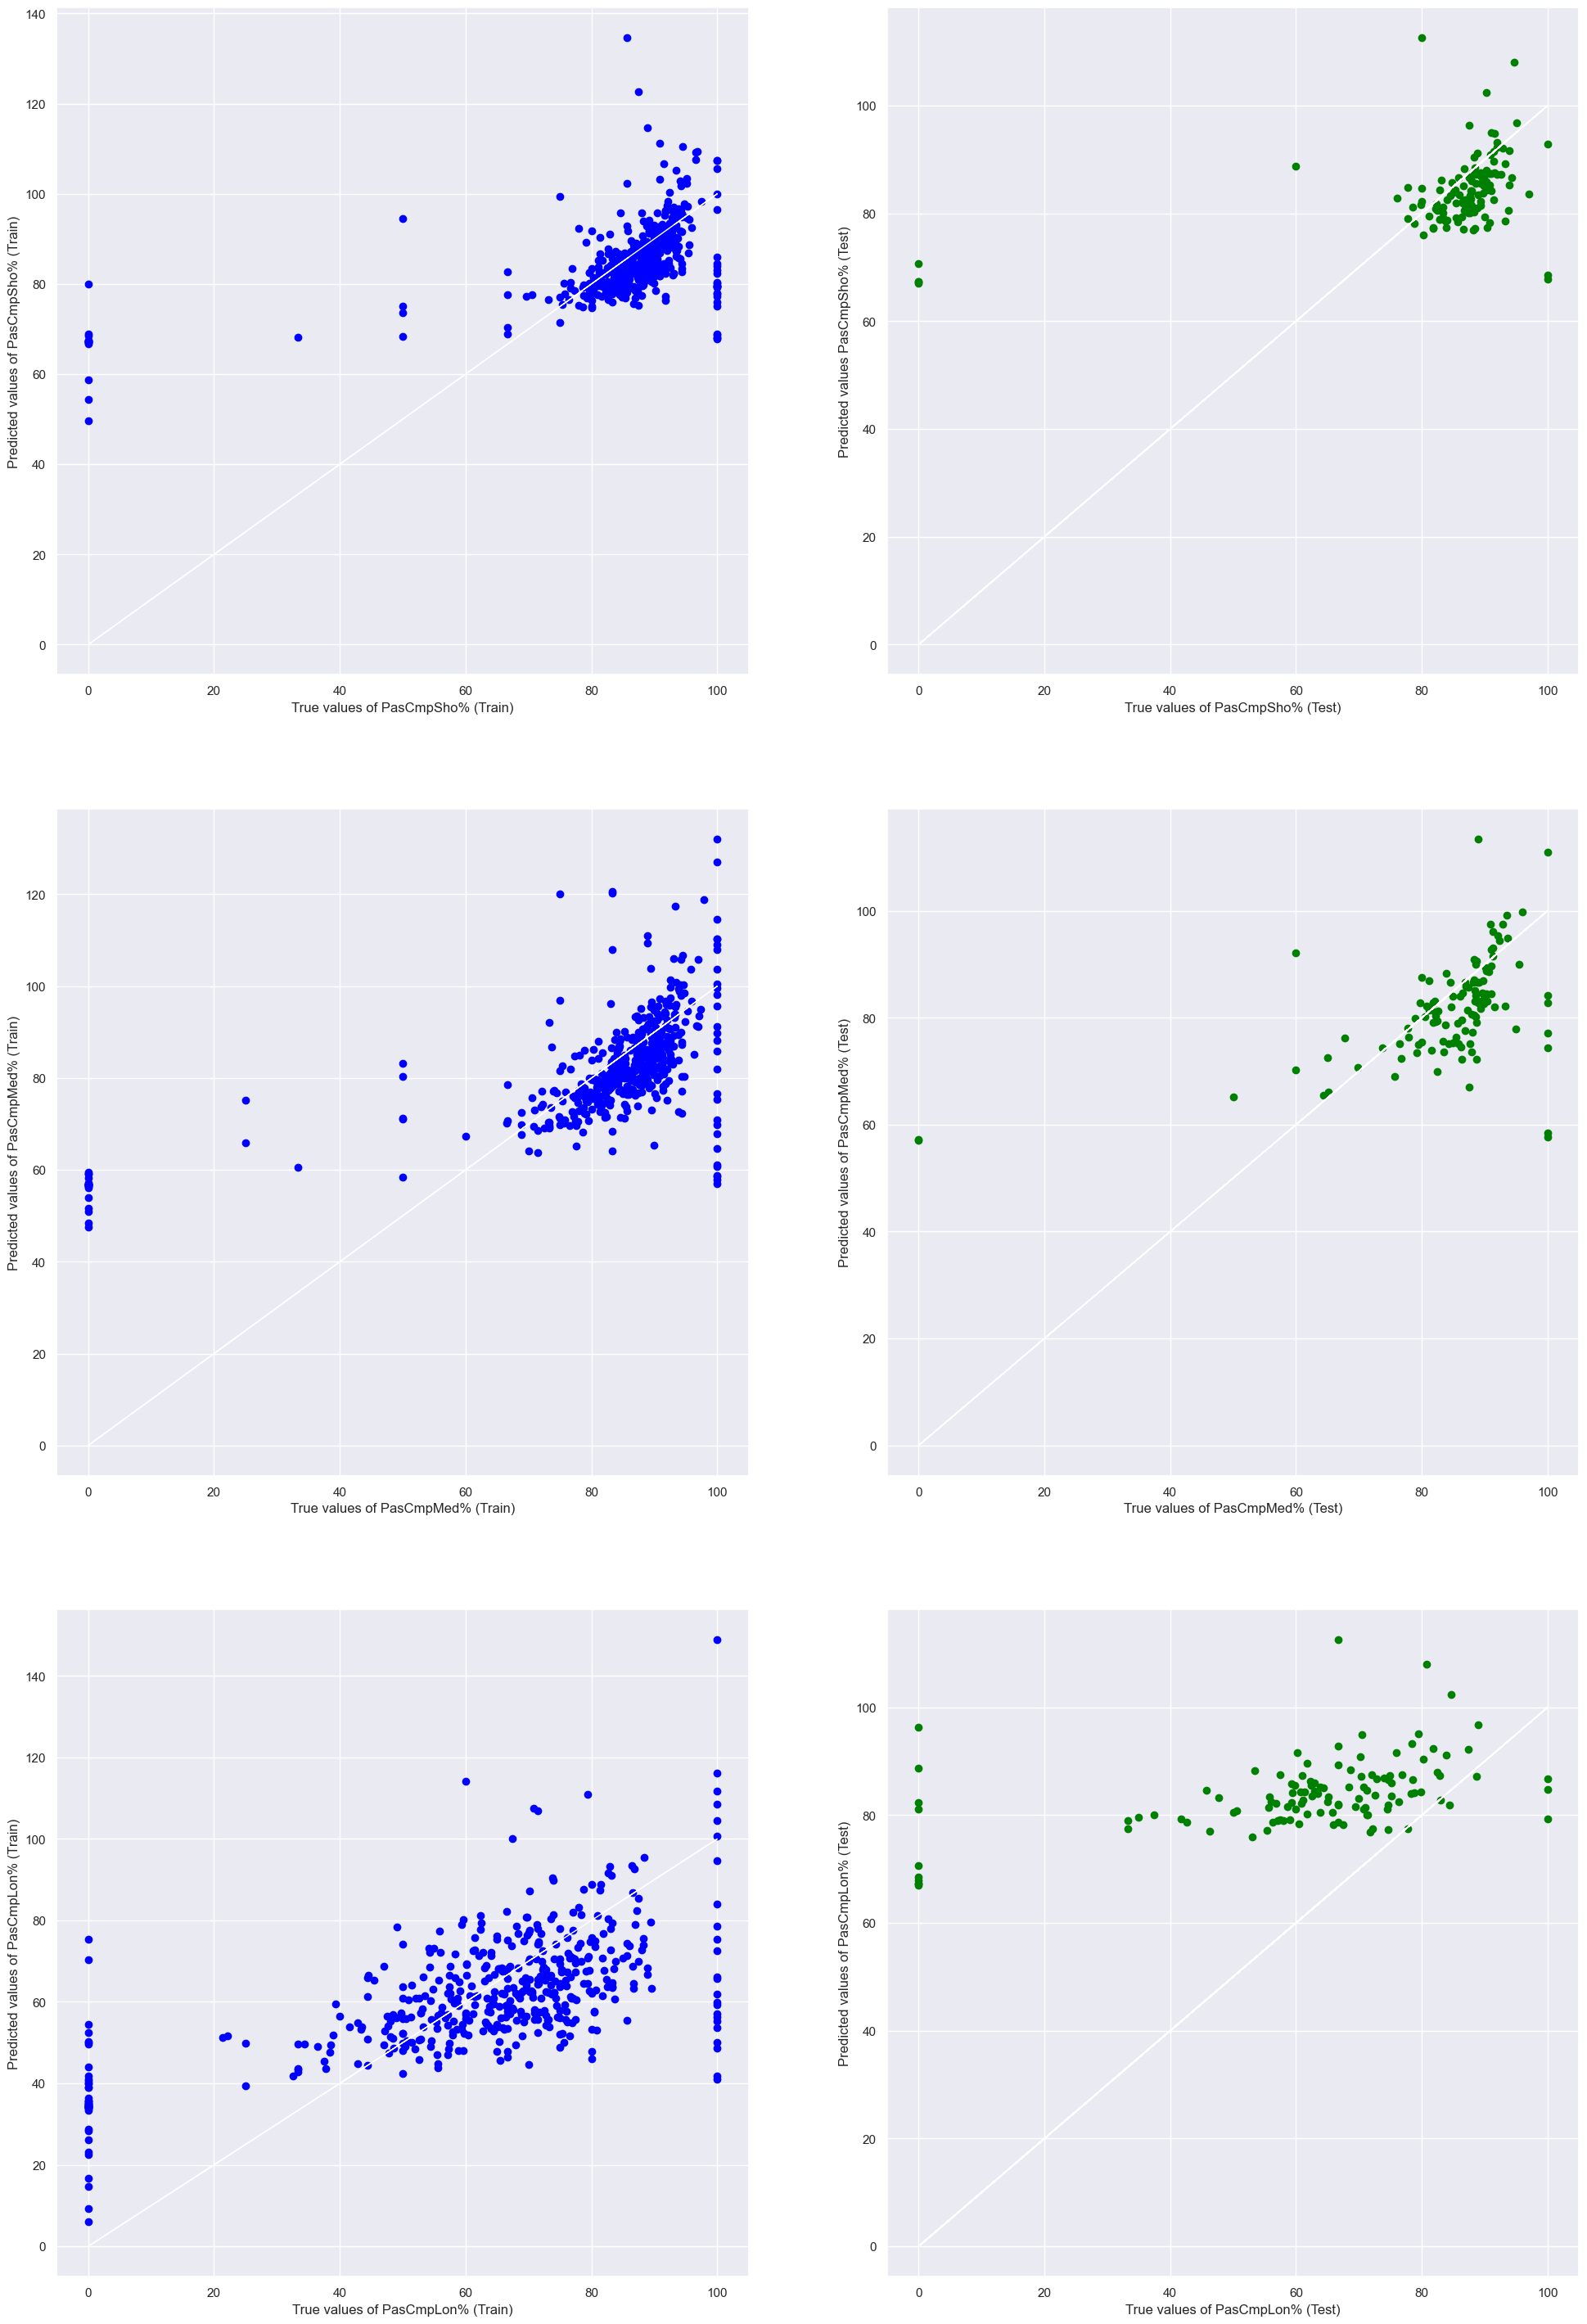

In [22]:
f, axes = plt.subplots(3, 2, figsize=(24, 36))
axes[0][0].scatter(MF_Y_Train_Sho, model_MF_Sho.predict(MF_X_Train), color = "blue")
axes[0][0].plot(MF_Y_Train_Sho, MF_Y_Train_Sho, 'w-', linewidth = 1)
axes[0][0].set_xlabel("True values of PasCmpSho% (Train)")
axes[0][0].set_ylabel("Predicted values of PasCmpSho% (Train)")
axes[0][1].scatter(MF_Y_Test_Sho, model_MF_Sho.predict(MF_X_Test), color = "green")
axes[0][1].plot(MF_Y_Test_Sho, MF_Y_Test_Sho, 'w-', linewidth = 1)
axes[0][1].set_xlabel("True values of PasCmpSho% (Test)")
axes[0][1].set_ylabel("Predicted values PasCmpSho% (Test)")

axes[1][0].scatter(MF_Y_Train_Med, model_MF_Med.predict(MF_X_Train), color = "blue")
axes[1][0].plot(MF_Y_Train_Med, MF_Y_Train_Med, 'w-', linewidth = 1)
axes[1][0].set_xlabel("True values of PasCmpMed% (Train)")
axes[1][0].set_ylabel("Predicted values of PasCmpMed% (Train)")
axes[1][1].scatter(MF_Y_Test_Med, model_MF_Med.predict(MF_X_Test), color = "green")
axes[1][1].plot(MF_Y_Test_Med, MF_Y_Test_Med, 'w-', linewidth = 1)
axes[1][1].set_xlabel("True values of PasCmpMed% (Test)")
axes[1][1].set_ylabel("Predicted values of PasCmpMed% (Test)")

axes[2][0].scatter(MF_Y_Train_Lon, model_MF_Lon.predict(MF_X_Train), color = "blue")
axes[2][0].plot(MF_Y_Train_Lon, MF_Y_Train_Lon, 'w-', linewidth = 1)
axes[2][0].set_xlabel("True values of PasCmpLon% (Train)")
axes[2][0].set_ylabel("Predicted values of PasCmpLon% (Train)")
axes[2][1].scatter(MF_Y_Test_Lon, model_MF_Sho.predict(MF_X_Test), color = "green")
axes[2][1].plot(MF_Y_Test_Lon, MF_Y_Test_Lon, 'w-', linewidth = 1)
axes[2][1].set_xlabel("True values of PasCmpLon% (Test)")
axes[2][1].set_ylabel("Predicted values of PasCmpLon% (Test)")

print("Goodness of Fit of Model \tTrain Sho Dataset")
print("Explained Variance (R^2) \t:", model_MF_Sho.score(MF_X_Train, MF_Y_Train_Sho))
print("Mean Squared Error (MSE) \t:", mean_squared_error(MF_Y_Train_Sho, model_MF_Sho.predict(MF_X_Train)))
print("Goodness of Fit of Model \tTest Sho Data")
print("Explained Variance (R^2) \t:", model_MF_Sho.score(MF_X_Test, MF_Y_Test_Sho))
print("Mean Squared Error (MSE) \t:", mean_squared_error(MF_Y_Test_Sho, model_MF_Sho.predict(MF_X_Test)))
print()
print("Goodness of Fit of Model \tTrain Med Dataset")
print("Explained Variance (R^2) \t:", model_MF_Med.score(MF_X_Train, MF_Y_Train_Med))
print("Mean Squared Error (MSE) \t:", mean_squared_error(MF_Y_Train_Med, model_MF_Med.predict(MF_X_Train)))
print("Goodness of Fit of Model \tTest Med Dataset")
print("Explained Variance (R^2) \t:", model_MF_Med.score(MF_X_Test, MF_Y_Test_Med))
print("Mean Squared Error (MSE) \t:", mean_squared_error(MF_Y_Test_Med, model_MF_Med.predict(MF_X_Test)))
print()
print("Goodness of Fit of Model \tTrain Lon Dataset")
print("Explained Variance (R^2) \t:", model_MF_Lon.score(MF_X_Train, MF_Y_Train_Lon))
print("Mean Squared Error (MSE) \t:", mean_squared_error(MF_Y_Train_Lon, model_MF_Lon.predict(MF_X_Train)))
print("Goodness of Fit of Model \tTest Lon Dataset")
print("Explained Variance (R^2) \t:", model_MF_Lon.score(MF_X_Test, MF_Y_Test_Lon))
print("Mean Squared Error (MSE) \t:", mean_squared_error(MF_Y_Test_Lon, model_MF_Lon.predict(MF_X_Test)))

plt.show()

Goodness of Fit of Model 	Train Tkl Dataset
Explained Variance (R^2) 	: 0.9717093421972864
Mean Squared Error (MSE) 	: 0.039643421230539946
Goodness of Fit of Model 	Test Tkl Data
Explained Variance (R^2) 	: 0.9702818969467272
Mean Squared Error (MSE) 	: 0.03173902357876689

Goodness of Fit of Model 	Train Int Dataset
Explained Variance (R^2) 	: 0.14431047016179765
Mean Squared Error (MSE) 	: 1.308394842058298
Goodness of Fit of Model 	Test Int Dataset
Explained Variance (R^2) 	: -0.038703351356945026
Mean Squared Error (MSE) 	: 1.3559248785604578

Goodness of Fit of Model 	Train Clr Dataset
Explained Variance (R^2) 	: 0.4325229050891227
Mean Squared Error (MSE) 	: 2.222685075750203
Goodness of Fit of Model 	Test Clr Dataset
Explained Variance (R^2) 	: 0.1256918178718217
Mean Squared Error (MSE) 	: 3.2243405972453334


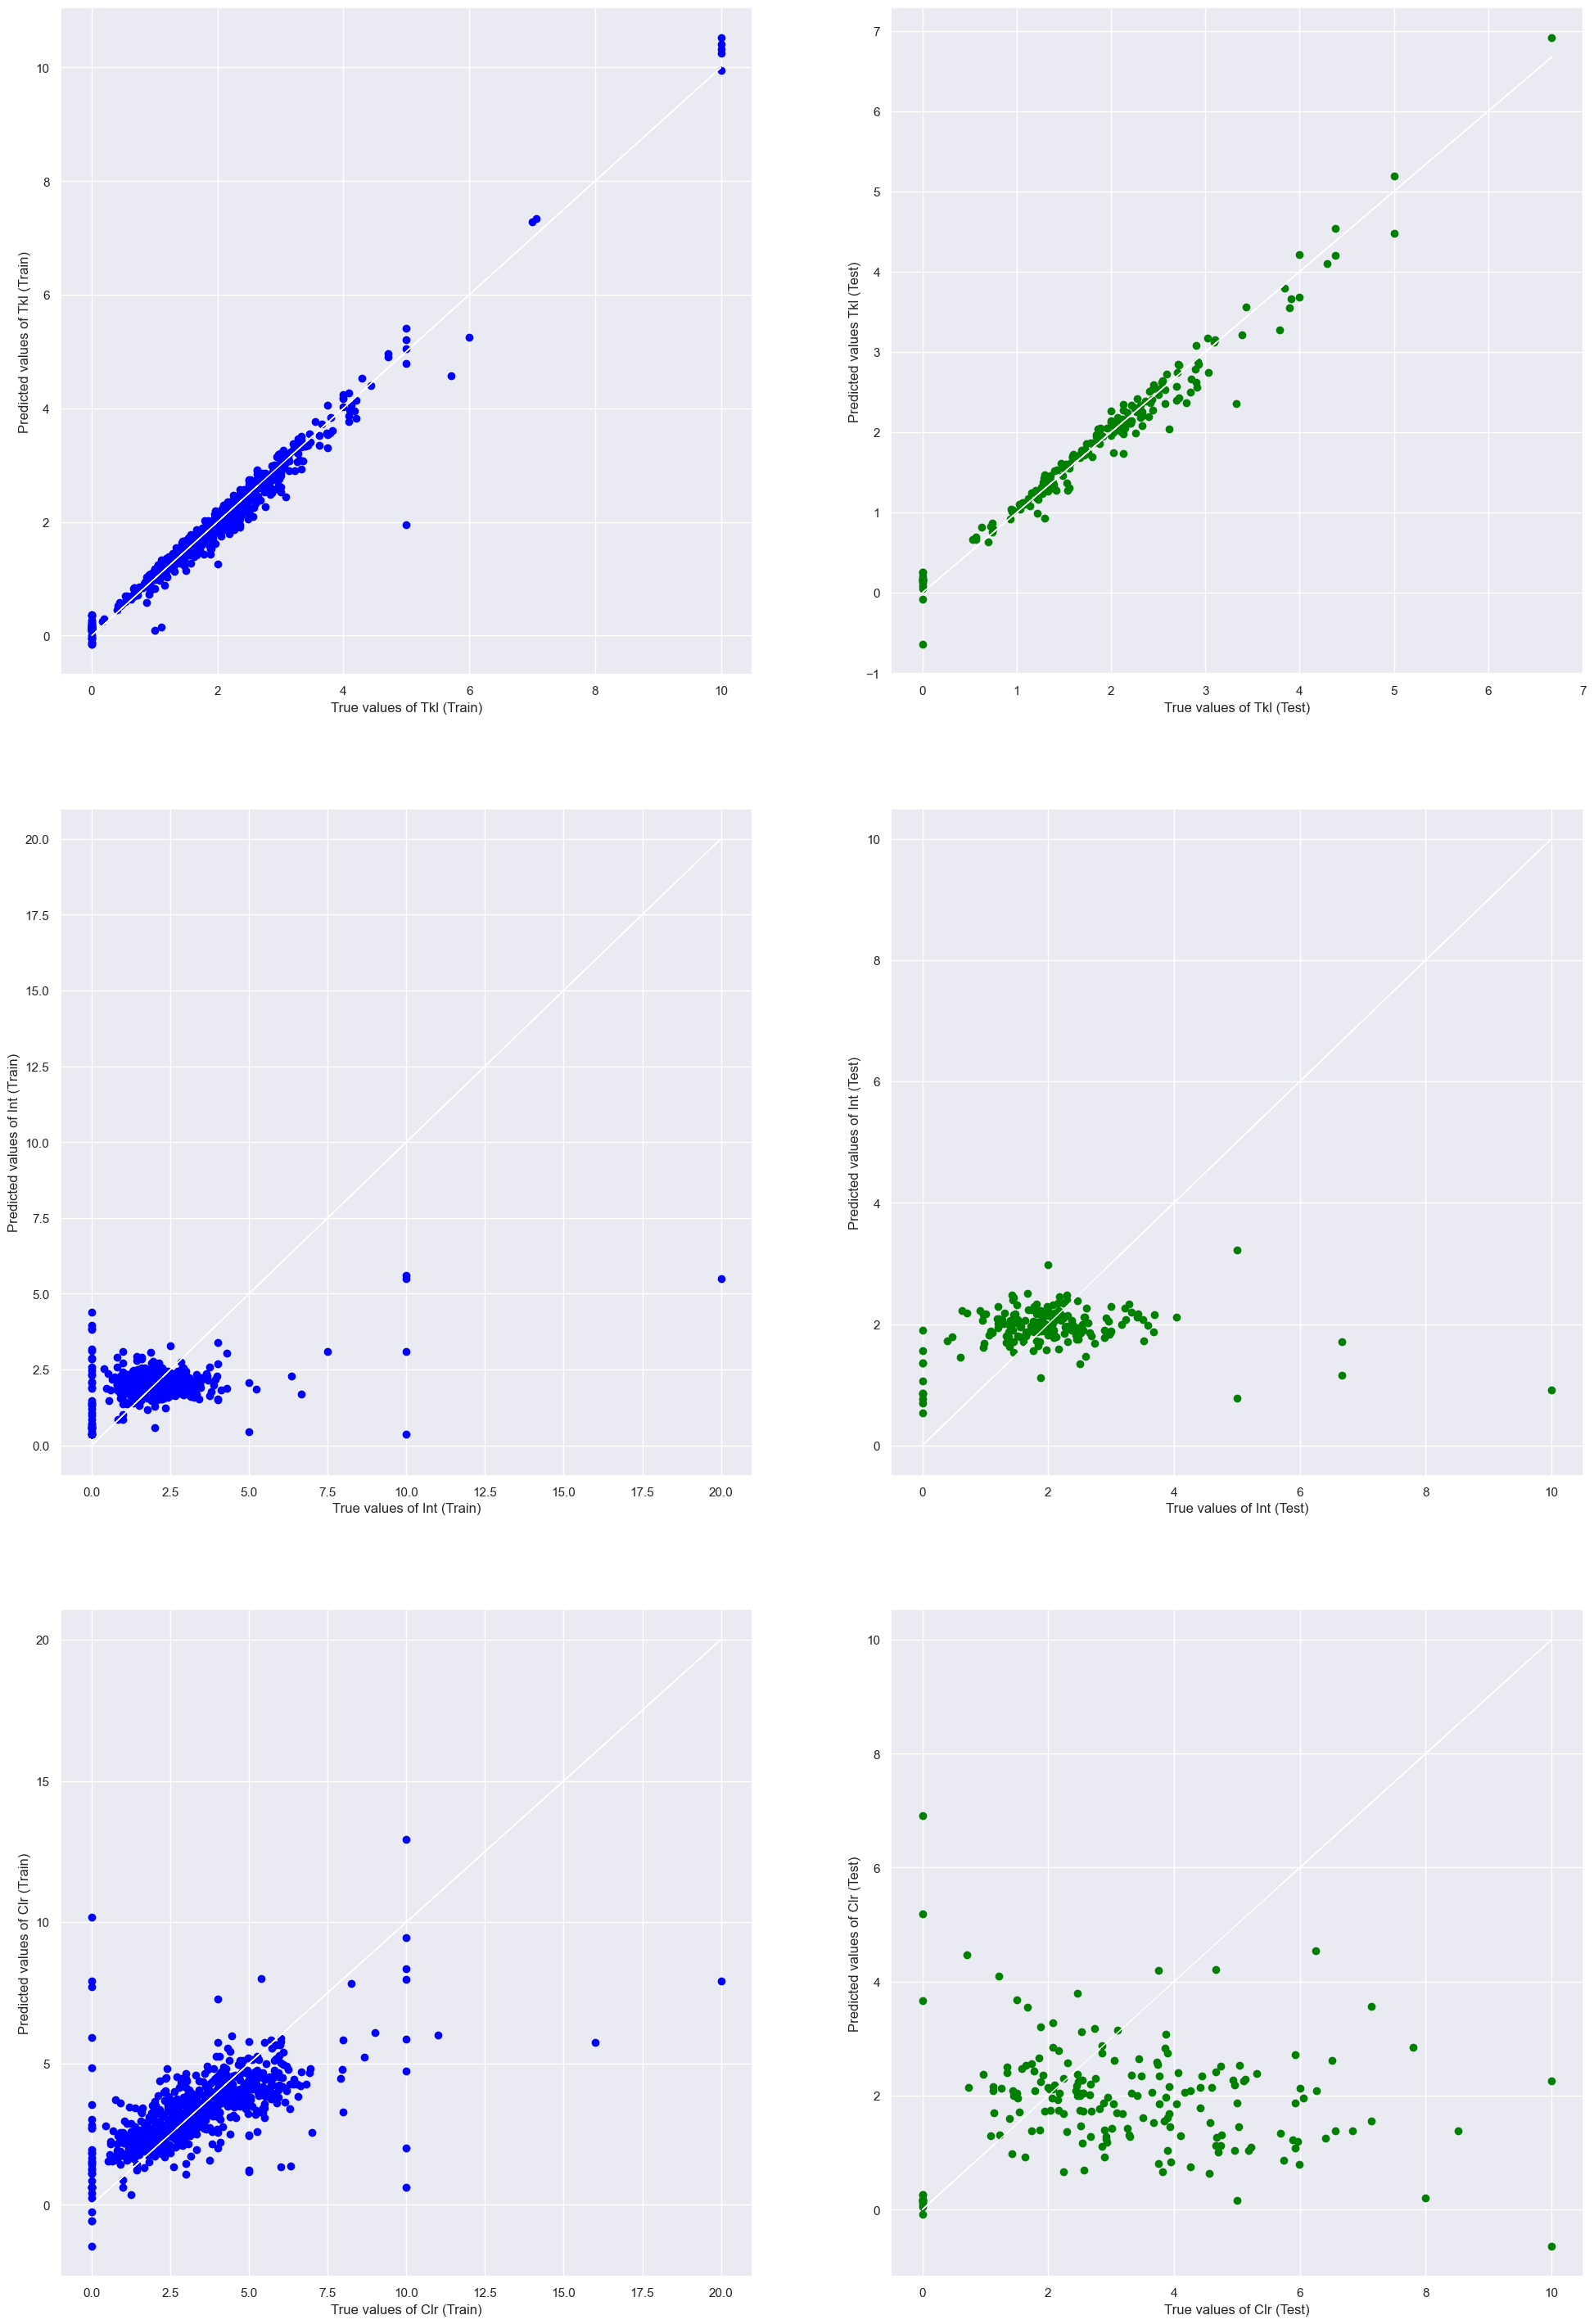

In [23]:
f, axes = plt.subplots(3, 2, figsize=(24, 36))
axes[0][0].scatter(DF_Y_Train_Tkl, model_DF_Tkl.predict(DF_X_Train), color = "blue")
axes[0][0].plot(DF_Y_Train_Tkl, DF_Y_Train_Tkl, 'w-', linewidth = 1)
axes[0][0].set_xlabel("True values of Tkl (Train)")
axes[0][0].set_ylabel("Predicted values of Tkl (Train)")
axes[0][1].scatter(DF_Y_Test_Tkl, model_DF_Tkl.predict(DF_X_Test), color = "green")
axes[0][1].plot(DF_Y_Test_Tkl, DF_Y_Test_Tkl, 'w-', linewidth = 1)
axes[0][1].set_xlabel("True values of Tkl (Test)")
axes[0][1].set_ylabel("Predicted values Tkl (Test)")

axes[1][0].scatter(DF_Y_Train_Int, model_DF_Int.predict(DF_X_Train), color = "blue")
axes[1][0].plot(DF_Y_Train_Int, DF_Y_Train_Int, 'w-', linewidth = 1)
axes[1][0].set_xlabel("True values of Int (Train)")
axes[1][0].set_ylabel("Predicted values of Int (Train)")
axes[1][1].scatter(DF_Y_Test_Int, model_DF_Int.predict(DF_X_Test), color = "green")
axes[1][1].plot(DF_Y_Test_Int, DF_Y_Test_Int, 'w-', linewidth = 1)
axes[1][1].set_xlabel("True values of Int (Test)")
axes[1][1].set_ylabel("Predicted values of Int (Test)")

axes[2][0].scatter(DF_Y_Train_Clr, model_DF_Clr.predict(DF_X_Train), color = "blue")
axes[2][0].plot(DF_Y_Train_Clr, DF_Y_Train_Clr, 'w-', linewidth = 1)
axes[2][0].set_xlabel("True values of Clr (Train)")
axes[2][0].set_ylabel("Predicted values of Clr (Train)")
axes[2][1].scatter(DF_Y_Test_Clr, model_DF_Tkl.predict(DF_X_Test), color = "green")
axes[2][1].plot(DF_Y_Test_Clr, DF_Y_Test_Clr, 'w-', linewidth = 1)
axes[2][1].set_xlabel("True values of Clr (Test)")
axes[2][1].set_ylabel("Predicted values of Clr (Test)")

print("Goodness of Fit of Model \tTrain Tkl Dataset")
print("Explained Variance (R^2) \t:", model_DF_Tkl.score(DF_X_Train, DF_Y_Train_Tkl))
print("Mean Squared Error (MSE) \t:", mean_squared_error(DF_Y_Train_Tkl, model_DF_Tkl.predict(DF_X_Train)))
print("Goodness of Fit of Model \tTest Tkl Data")
print("Explained Variance (R^2) \t:", model_DF_Tkl.score(DF_X_Test, DF_Y_Test_Tkl))
print("Mean Squared Error (MSE) \t:", mean_squared_error(DF_Y_Test_Tkl, model_DF_Tkl.predict(DF_X_Test)))
print()
print("Goodness of Fit of Model \tTrain Int Dataset")
print("Explained Variance (R^2) \t:", model_DF_Int.score(DF_X_Train, DF_Y_Train_Int))
print("Mean Squared Error (MSE) \t:", mean_squared_error(DF_Y_Train_Int, model_DF_Int.predict(DF_X_Train)))
print("Goodness of Fit of Model \tTest Int Dataset")
print("Explained Variance (R^2) \t:", model_DF_Int.score(DF_X_Test, DF_Y_Test_Int))
print("Mean Squared Error (MSE) \t:", mean_squared_error(DF_Y_Test_Int, model_DF_Int.predict(DF_X_Test)))
print()
print("Goodness of Fit of Model \tTrain Clr Dataset")
print("Explained Variance (R^2) \t:", model_DF_Clr.score(DF_X_Train, DF_Y_Train_Clr))
print("Mean Squared Error (MSE) \t:", mean_squared_error(DF_Y_Train_Clr, model_DF_Clr.predict(DF_X_Train)))
print("Goodness of Fit of Model \tTest Clr Dataset")
print("Explained Variance (R^2) \t:", model_DF_Clr.score(DF_X_Test, DF_Y_Test_Clr))
print("Mean Squared Error (MSE) \t:", mean_squared_error(DF_Y_Test_Clr, model_DF_Clr.predict(DF_X_Test)))


plt.show()

In [24]:
GSh_linear_mse = mean_squared_error(FW_Y_GSh, FW_Relevant['P_G/Sh_LR'])
GSh_linear_r2=r2_score(FW_Y_GSh, FW_Relevant['P_G/Sh_LR'])
GSoT_linear_mse = mean_squared_error(FW_Y_GSoT, FW_Relevant['P_G/SoT_LR'])
GSoT_linear_r2=r2_score(FW_Y_GSoT, FW_Relevant['P_G/SoT_LR'])

Sho_linear_mse = mean_squared_error(MF_Y_Sho, MF_Relevant['P_PasCmpSho%_LR'])
Sho_linear_r2=r2_score(MF_Y_Sho, MF_Relevant['P_PasCmpSho%_LR'])
Med_linear_mse = mean_squared_error(MF_Y_Med, MF_Relevant['P_PasCmpMed%_LR'])
Med_linear_r2=r2_score(MF_Y_Med, MF_Relevant['P_PasCmpMed%_LR'])
Lon_linear_mse = mean_squared_error(MF_Y_Lon, MF_Relevant['P_PasCmpLon%_LR'])
Lon_linear_r2=r2_score(MF_Y_Lon, MF_Relevant['P_PasCmpLon%_LR'])

Tkl_linear_mse = mean_squared_error(DF_Y_Tkl, DF_Relevant['P_Tkl_LR'])
Tkl_linear_r2=r2_score(DF_Y_Tkl, DF_Relevant['P_Tkl_LR'])
Int_linear_mse = mean_squared_error(DF_Y_Int, DF_Relevant['P_Tkl_LR'])
Int_linear_r2=r2_score(DF_Y_Int, DF_Relevant['P_Tkl_LR'])
Clr_linear_mse = mean_squared_error(DF_Y_Clr, DF_Relevant['P_Tkl_LR'])
Clr_linear_r2=r2_score(DF_Y_Clr, DF_Relevant['P_Tkl_LR'])

Linear Regression for Forwards:
G/Sh Mean Squared Error: 	 0.0020744610958316574
G/Sh R-squared: 		 0.7753844613978567
G/SoT Mean Squared Error: 	 0.02428504652556141
G/SoT R-squared: 		 0.5233779564101455
Linear Regression for MidFielders:
Sho Mean Squared Error: 	 201.8404058844149
Sho R-squared: 			 0.25132445760487054
Med Mean Squared Error: 	 221.94311064368026
Med R-squared: 			 0.3484491094522105
Lon Mean Squared Error: 	 334.37277933538195
Lon R-squared: 			 0.4043276230279301
Linear Regression for Defenders:
Tkl Mean Squared Error: 	 0.038057507051999485
Tkl R-squared: 			 0.9714817417287694
Int Mean Squared Error: 	 2.3635129309693923
Int R-squared: 			 -0.592416212764368
Clr Mean Squared Error: 	 6.940714636794496
Clr R-squared: 			 -0.7930213230694143


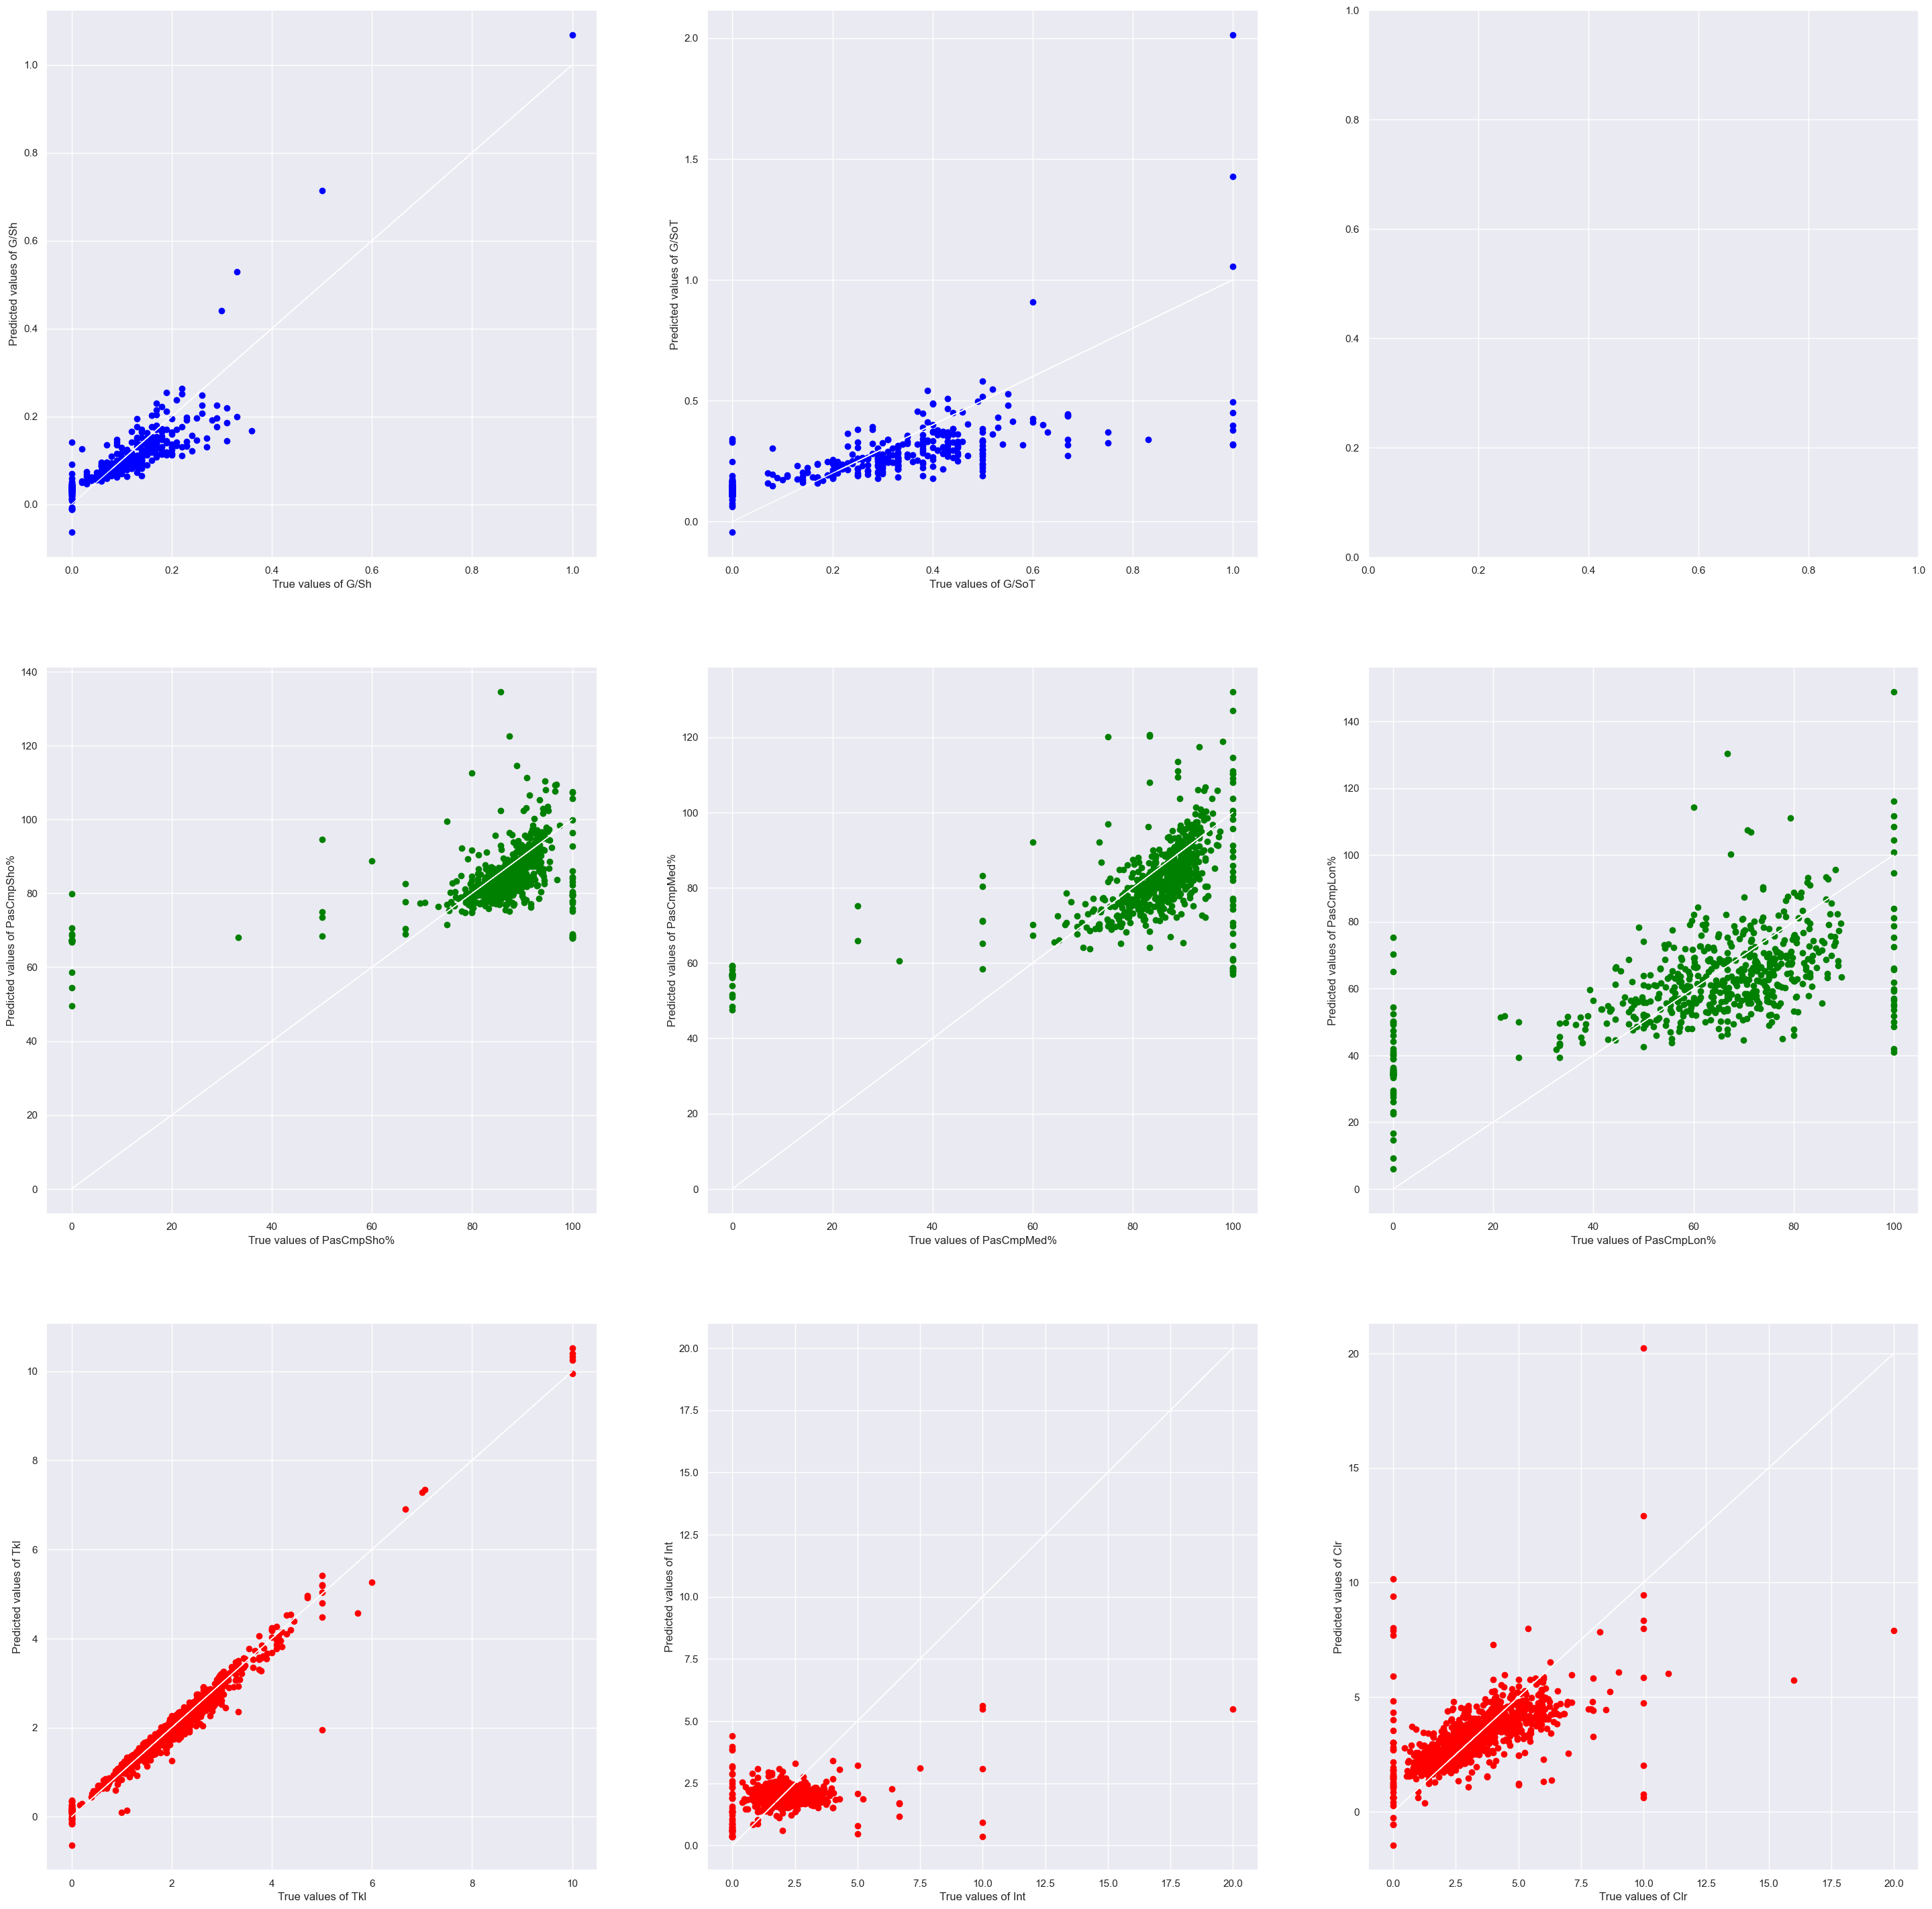

In [25]:
f, axes = plt.subplots(3, 3, figsize=(36, 36))
axes[0][0].scatter(FW_Y_GSh, FW_Relevant['P_G/Sh_LR'], color = "blue")
axes[0][0].plot(FW_Y_GSh, FW_Y_GSh, 'w-', linewidth = 1)
axes[0][0].set_xlabel("True values of G/Sh")
axes[0][0].set_ylabel("Predicted values of G/Sh")
axes[0][1].scatter(FW_Y_GSoT, FW_Relevant['P_G/SoT_LR'], color = "blue")
axes[0][1].plot(FW_Y_GSoT, FW_Y_GSoT, 'w-', linewidth = 1)
axes[0][1].set_xlabel("True values of G/SoT")
axes[0][1].set_ylabel("Predicted values of G/SoT")

axes[1][0].scatter(MF_Y_Sho, MF_Relevant['P_PasCmpSho%_LR'], color = "green")
axes[1][0].plot(MF_Y_Sho, MF_Y_Sho, 'w-', linewidth = 1)
axes[1][0].set_xlabel("True values of PasCmpSho%")
axes[1][0].set_ylabel("Predicted values of PasCmpSho%")
axes[1][1].scatter(MF_Y_Med, MF_Relevant['P_PasCmpMed%_LR'], color = "green")
axes[1][1].plot(MF_Y_Med, MF_Y_Med, 'w-', linewidth = 1)
axes[1][1].set_xlabel("True values of PasCmpMed%")
axes[1][1].set_ylabel("Predicted values of PasCmpMed%")
axes[1][2].scatter(MF_Y_Lon, MF_Relevant['P_PasCmpLon%_LR'], color = "green")
axes[1][2].plot(MF_Y_Lon, MF_Y_Lon, 'w-', linewidth = 1)
axes[1][2].set_xlabel("True values of PasCmpLon%")
axes[1][2].set_ylabel("Predicted values of PasCmpLon%")

axes[2][0].scatter(DF_Y_Tkl, DF_Relevant['P_Tkl_LR'], color = "red")
axes[2][0].plot(DF_Y_Tkl, DF_Y_Tkl, 'w-', linewidth = 1)
axes[2][0].set_xlabel("True values of Tkl")
axes[2][0].set_ylabel("Predicted values of Tkl")
axes[2][1].scatter(DF_Y_Int, DF_Relevant['P_Int_LR'], color = "red")
axes[2][1].plot(DF_Y_Int, DF_Y_Int, 'w-', linewidth = 1)
axes[2][1].set_xlabel("True values of Int")
axes[2][1].set_ylabel("Predicted values of Int")
axes[2][2].scatter(DF_Y_Clr, DF_Relevant['P_Clr_LR'], color = "red")
axes[2][2].plot(DF_Y_Clr, DF_Y_Clr, 'w-', linewidth = 1)
axes[2][2].set_xlabel("True values of Clr")
axes[2][2].set_ylabel("Predicted values of Clr")

print("Linear Regression for Forwards:")
print("G/Sh Mean Squared Error: \t", GSh_linear_mse)
print("G/Sh R-squared: \t\t", GSh_linear_r2)
print("G/SoT Mean Squared Error: \t", GSoT_linear_mse)
print("G/SoT R-squared: \t\t", GSoT_linear_r2)

print("Linear Regression for MidFielders:")
print("Sho Mean Squared Error: \t", Sho_linear_mse)
print("Sho R-squared: \t\t\t", Sho_linear_r2)
print("Med Mean Squared Error: \t", Med_linear_mse)
print("Med R-squared: \t\t\t", Med_linear_r2)
print("Lon Mean Squared Error: \t", Lon_linear_mse)
print("Lon R-squared: \t\t\t", Lon_linear_r2)

print("Linear Regression for Defenders:")
print("Tkl Mean Squared Error: \t", Tkl_linear_mse)
print("Tkl R-squared: \t\t\t", Tkl_linear_r2)
print("Int Mean Squared Error: \t", Int_linear_mse)
print("Int R-squared: \t\t\t", Int_linear_r2)
print("Clr Mean Squared Error: \t", Clr_linear_mse)
print("Clr R-squared: \t\t\t", Clr_linear_r2)

# Step 4b: Random Forest
Next, we tried Random Forest Regressor. In the same way as linear regression, we created 7 models for each target variable, then ran the variables through the model for prediction. We then calculated the Out-of-Bag score, R^2 and MSE for each model.

In [26]:
FW_ranfor_GSh = RandomForestRegressor(max_depth = 3, oob_score=True)
FW_ranfor_GSh.fit(FW_X_Train, FW_Y_Train_GSh)
GSh_prediction = FW_ranfor_GSh.predict(FW_X_Test)
FW_ranfor_GSoT = RandomForestRegressor(max_depth = 3, oob_score=True)
FW_ranfor_GSoT.fit(FW_X_Train, FW_Y_Train_GSoT)
GSoT_prediction = FW_ranfor_GSoT.predict(FW_X_Test)

MF_ranfor_Sho = RandomForestRegressor(max_depth = 3, oob_score=True)
MF_ranfor_Sho.fit(MF_X_Train, MF_Y_Train_Sho)
Sho_prediction = MF_ranfor_Sho.predict(MF_X_Test)
MF_ranfor_Med = RandomForestRegressor(max_depth = 3, oob_score=True)
MF_ranfor_Med.fit(MF_X_Train, MF_Y_Train_Med)
Med_prediction = MF_ranfor_Med.predict(MF_X_Test)
MF_ranfor_Lon = RandomForestRegressor(max_depth = 3, oob_score=True)
MF_ranfor_Lon.fit(MF_X_Train, MF_Y_Train_Lon)
Lon_prediction = MF_ranfor_Lon.predict(MF_X_Test)

DF_ranfor_Tkl = RandomForestRegressor(max_depth = 3, oob_score=True)
DF_ranfor_Tkl.fit(DF_X_Train, DF_Y_Train_Tkl)
Tkl_prediction = DF_ranfor_Tkl.predict(DF_X_Test)
DF_ranfor_Int = RandomForestRegressor(max_depth = 3, oob_score=True)
DF_ranfor_Int.fit(DF_X_Train, DF_Y_Train_Int)
Int_prediction = DF_ranfor_Int.predict(DF_X_Test)
DF_ranfor_Clr = RandomForestRegressor(max_depth = 3, oob_score=True)
DF_ranfor_Clr.fit(DF_X_Train, DF_Y_Train_Clr)
Clr_prediction = DF_ranfor_Clr.predict(DF_X_Test)

GSh_oob_score = FW_ranfor_GSh.oob_score_
GSh_mse = mean_squared_error(FW_Y_Test_GSh, GSh_prediction)
GSh_r2=r2_score(FW_Y_Test_GSh, GSh_prediction)
GSoT_oob_score = FW_ranfor_GSoT.oob_score_
GSoT_mse = mean_squared_error(FW_Y_Test_GSoT, GSh_prediction)
GSoT_r2=r2_score(FW_Y_Test_GSoT, GSh_prediction)

Sho_oob_score = MF_ranfor_Sho.oob_score_
Sho_mse = mean_squared_error(MF_Y_Test_Sho, Sho_prediction)
Sho_r2=r2_score(MF_Y_Test_Sho, Sho_prediction)
Med_oob_score = MF_ranfor_Med.oob_score_
Med_mse = mean_squared_error(MF_Y_Test_Med, Med_prediction)
Med_r2=r2_score(MF_Y_Test_Med, Med_prediction)
Lon_oob_score = MF_ranfor_Lon.oob_score_
Lon_mse = mean_squared_error(MF_Y_Test_Lon, Lon_prediction)
Lon_r2=r2_score(MF_Y_Test_Lon, Lon_prediction)

Tkl_oob_score = DF_ranfor_Tkl.oob_score_
Tkl_mse = mean_squared_error(DF_Y_Test_Tkl, Tkl_prediction)
Tkl_r2=r2_score(DF_Y_Test_Tkl, Tkl_prediction)
Int_oob_score = DF_ranfor_Int.oob_score_
Int_mse = mean_squared_error(DF_Y_Test_Int, Int_prediction)
Int_r2=r2_score(DF_Y_Test_Int, Int_prediction)
Clr_oob_score = DF_ranfor_Clr.oob_score_
Clr_mse = mean_squared_error(DF_Y_Test_Clr, Clr_prediction)
Clr_r2=r2_score(DF_Y_Test_Clr, Clr_prediction)

# Examples of the trees generated by random forest

Below are examples of 2 out of the 100 trees generated by the random forest regressor.

[Text(0.4444444444444444, 0.875, 'Goals <= 0.175\nsquared_error = 0.01\nsamples = 213\nvalue = 0.095'),
 Text(0.2222222222222222, 0.625, 'Goals <= 0.035\nsquared_error = 0.001\nsamples = 91\nvalue = 0.011'),
 Text(0.1111111111111111, 0.375, 'squared_error = -0.0\nsamples = 74\nvalue = 0.0'),
 Text(0.3333333333333333, 0.375, 'Shots <= 1.86\nsquared_error = 0.001\nsamples = 17\nvalue = 0.06'),
 Text(0.2222222222222222, 0.125, 'squared_error = 0.001\nsamples = 7\nvalue = 0.085'),
 Text(0.4444444444444444, 0.125, 'squared_error = 0.0\nsamples = 10\nvalue = 0.042'),
 Text(0.6666666666666666, 0.625, 'SCA <= 0.34\nsquared_error = 0.007\nsamples = 122\nvalue = 0.158'),
 Text(0.5555555555555556, 0.375, 'squared_error = 0.0\nsamples = 1\nvalue = 1.0'),
 Text(0.7777777777777778, 0.375, 'Goals <= 0.355\nsquared_error = 0.004\nsamples = 121\nvalue = 0.154'),
 Text(0.6666666666666666, 0.125, 'squared_error = 0.001\nsamples = 43\nvalue = 0.104'),
 Text(0.8888888888888888, 0.125, 'squared_error = 0.00

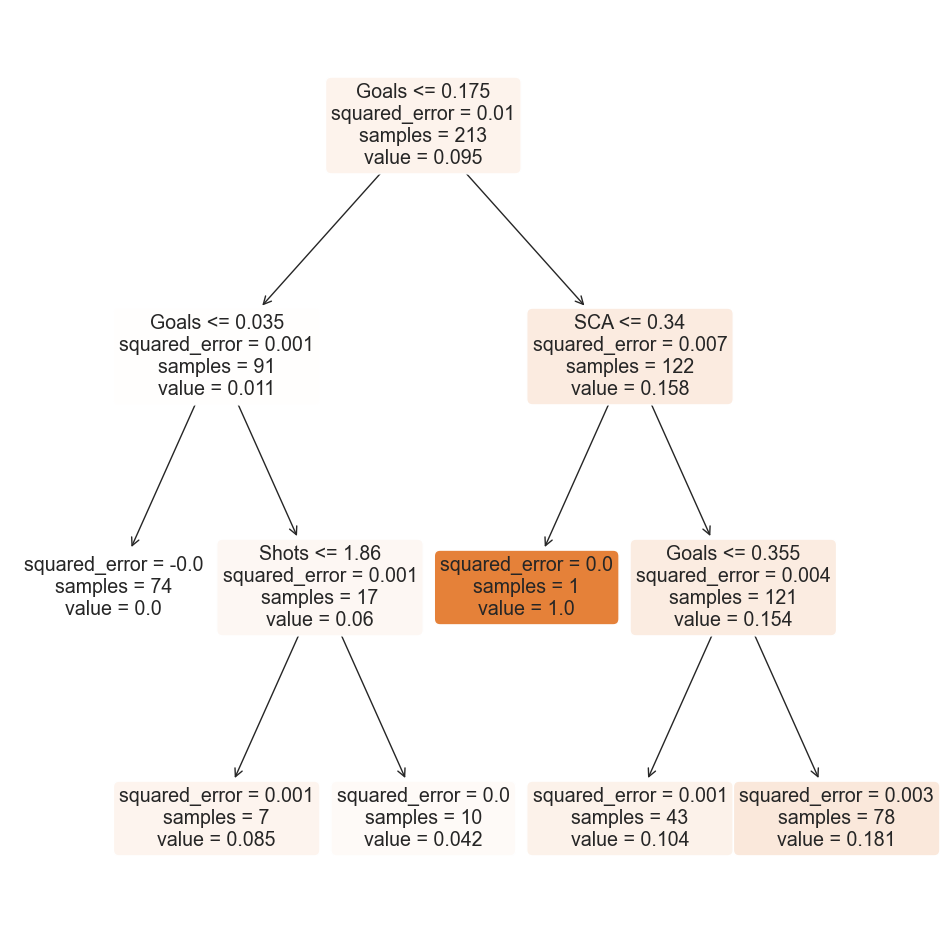

In [27]:
f = plt.figure(figsize=(12,12))
plot_tree(FW_ranfor_GSh[0], filled=True, rounded=True, 
          feature_names=list(FW_X.columns.values))

[Text(0.5416666666666666, 0.875, 'Goals <= 0.215\nsquared_error = 0.01\nsamples = 210\nvalue = 0.105'),
 Text(0.3333333333333333, 0.625, 'Goals <= 0.115\nsquared_error = 0.002\nsamples = 96\nvalue = 0.023'),
 Text(0.16666666666666666, 0.375, 'Goals <= 0.03\nsquared_error = 0.0\nsamples = 70\nvalue = 0.001'),
 Text(0.08333333333333333, 0.125, 'squared_error = -0.0\nsamples = 66\nvalue = 0.0'),
 Text(0.25, 0.125, 'squared_error = 0.0\nsamples = 4\nvalue = 0.025'),
 Text(0.5, 0.375, 'Shots <= 2.09\nsquared_error = 0.001\nsamples = 26\nvalue = 0.083'),
 Text(0.4166666666666667, 0.125, 'squared_error = 0.001\nsamples = 16\nvalue = 0.093'),
 Text(0.5833333333333334, 0.125, 'squared_error = 0.0\nsamples = 10\nvalue = 0.062'),
 Text(0.75, 0.625, 'SCA <= 0.41\nsquared_error = 0.008\nsamples = 114\nvalue = 0.166'),
 Text(0.6666666666666666, 0.375, 'squared_error = 0.0\nsamples = 1\nvalue = 1.0'),
 Text(0.8333333333333334, 0.375, 'Goals <= 0.515\nsquared_error = 0.004\nsamples = 113\nvalue = 0.16

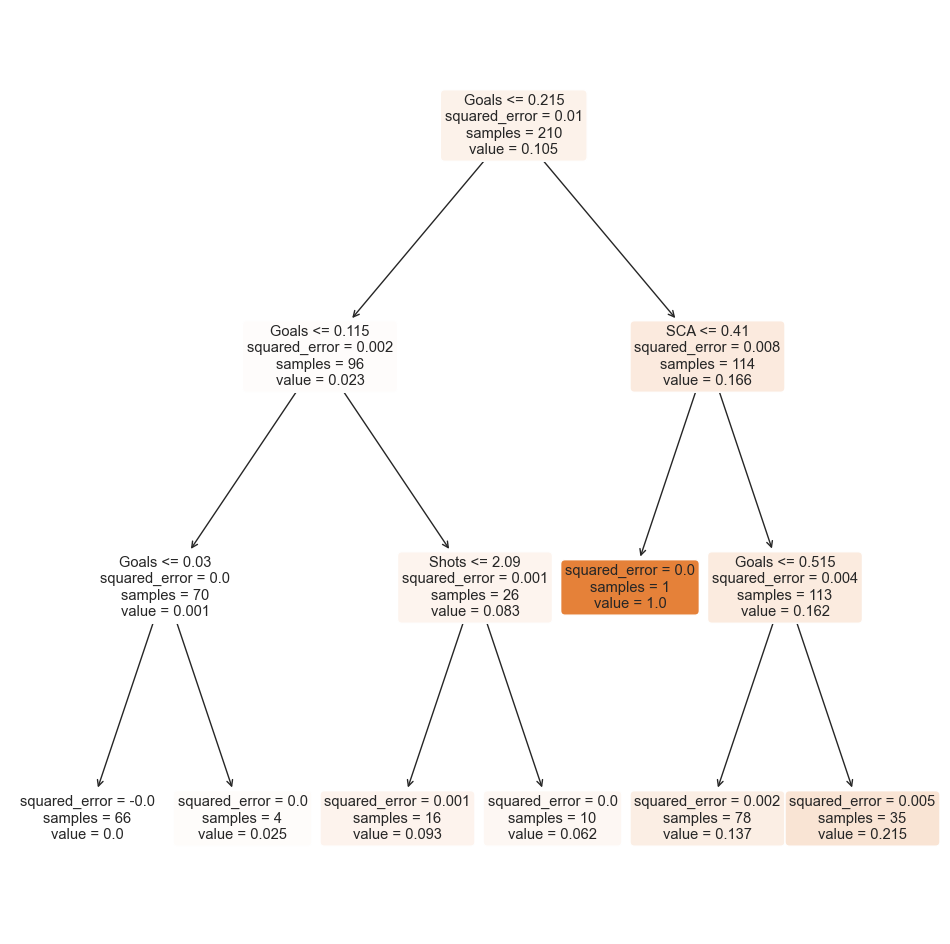

In [28]:
f = plt.figure(figsize=(12,12))
plot_tree(FW_ranfor_GSh[5], filled=True, rounded=True, 
          feature_names=list(FW_X.columns.values))

Random Forest for Forwards:
G/Sh Out-of-Bag Score: 		 0.7193804739035727
G/Sh Mean Squared Error: 	 0.0012473940495728304
G/Sh R-squared: 		 0.7998664714103443
G/SoT Out-of-Bag Score: 	 0.767846174441786
G/SoT Mean Squared Error: 	 0.04626587850369773
G/SoT R-squared: 		 0.05427180333237491


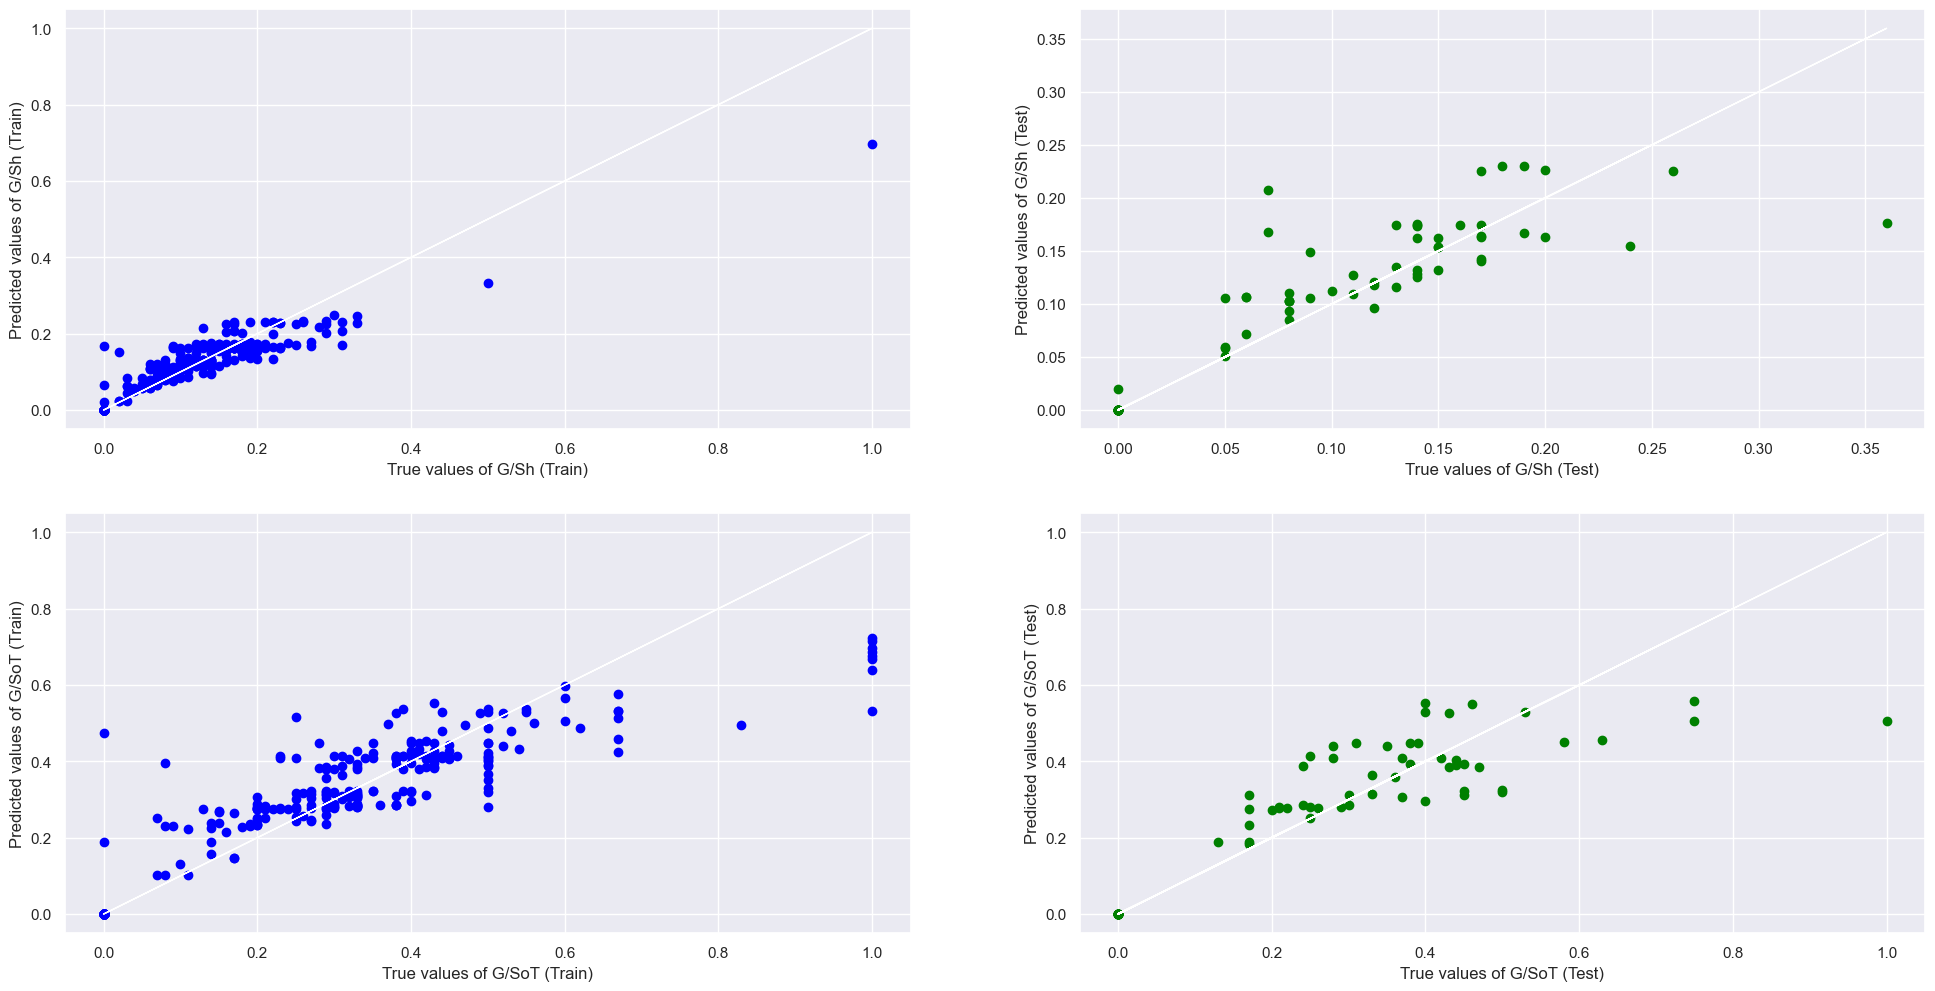

In [29]:
f, axes = plt.subplots(2, 2, figsize=(24, 12))
axes[0][0].scatter(FW_Y_Train_GSh, FW_ranfor_GSh.predict(FW_X_Train), color = "blue")
axes[0][0].plot(FW_Y_Train_GSh, FW_Y_Train_GSh, 'w-', linewidth = 1)
axes[0][0].set_xlabel("True values of G/Sh (Train)")
axes[0][0].set_ylabel("Predicted values of G/Sh (Train)")
axes[0][1].scatter(FW_Y_Test_GSh, FW_ranfor_GSh.predict(FW_X_Test), color = "green")
axes[0][1].plot(FW_Y_Test_GSh, FW_Y_Test_GSh, 'w-', linewidth = 1)
axes[0][1].set_xlabel("True values of G/Sh (Test)")
axes[0][1].set_ylabel("Predicted values of G/Sh (Test)")

axes[1][0].scatter(FW_Y_Train_GSoT, FW_ranfor_GSoT.predict(FW_X_Train), color = "blue")
axes[1][0].plot(FW_Y_Train_GSoT, FW_Y_Train_GSoT, 'w-', linewidth = 1)
axes[1][0].set_xlabel("True values of G/SoT (Train)")
axes[1][0].set_ylabel("Predicted values of G/SoT (Train)")
axes[1][1].scatter(FW_Y_Test_GSoT, FW_ranfor_GSoT.predict(FW_X_Test), color = "green")
axes[1][1].plot(FW_Y_Test_GSoT, FW_Y_Test_GSoT, 'w-', linewidth = 1)
axes[1][1].set_xlabel("True values of G/SoT (Test)")
axes[1][1].set_ylabel("Predicted values of G/SoT (Test)")

print("Random Forest for Forwards:")
print("G/Sh Out-of-Bag Score: \t\t", GSh_oob_score) #Higher better
print("G/Sh Mean Squared Error: \t", GSh_mse)
print("G/Sh R-squared: \t\t", GSh_r2)
print("G/SoT Out-of-Bag Score: \t", GSoT_oob_score) #Higher better
print("G/SoT Mean Squared Error: \t", GSoT_mse)
print("G/SoT R-squared: \t\t", GSoT_r2)

Random Forest for MidFielders:
Sho Out-of-Bag Score: 		 0.8206072813944563
Sho Mean Squared Error: 	 30.50192783853199
Sho R-squared: 			 0.8883914477447277
Med Out-of-Bag Score: 		 0.8158470905731794
Med Mean Squared Error: 	 51.86118308590242
Med R-squared: 			 0.7249916420712288
Lon Out-of-Bag Score: 		 0.7029566952567807
Lon Mean Squared Error: 	 117.51391504246955
Lon R-squared: 			 0.762904180330635


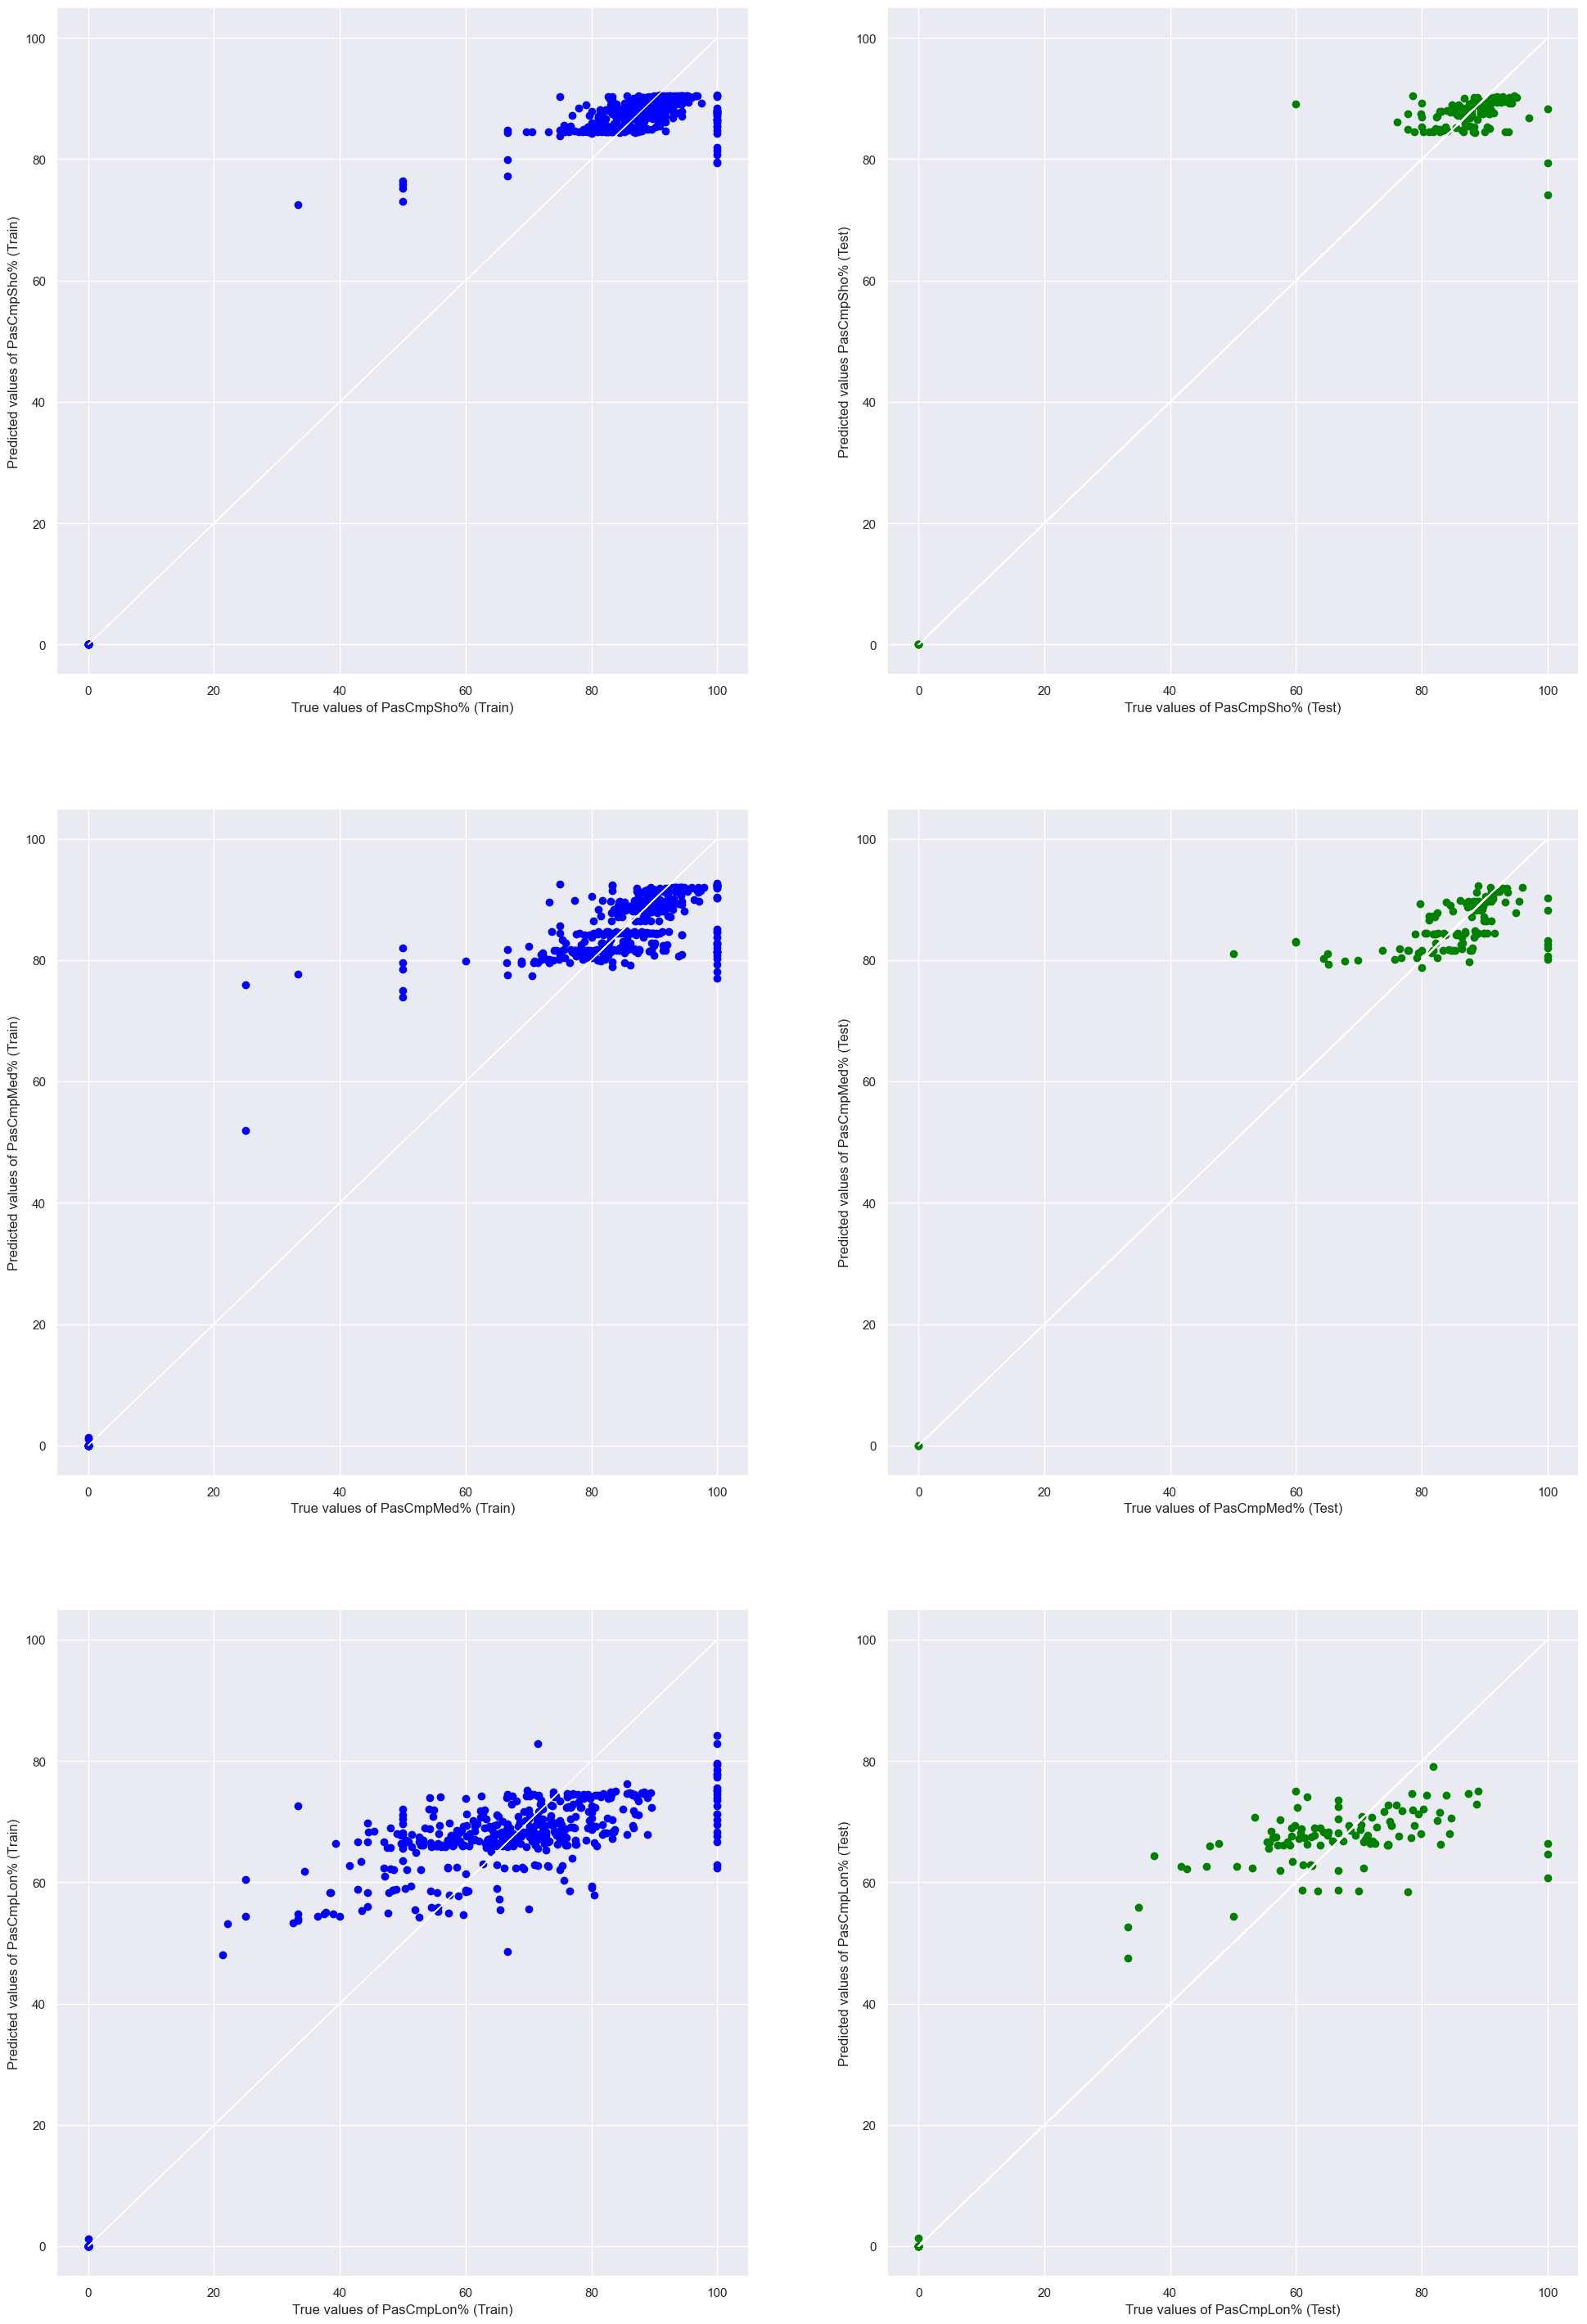

In [30]:
f, axes = plt.subplots(3, 2, figsize=(24, 36))
axes[0][0].scatter(MF_Y_Train_Sho, MF_ranfor_Sho.predict(MF_X_Train), color = "blue")
axes[0][0].plot(MF_Y_Train_Sho, MF_Y_Train_Sho, 'w-', linewidth = 1)
axes[0][0].set_xlabel("True values of PasCmpSho% (Train)")
axes[0][0].set_ylabel("Predicted values of PasCmpSho% (Train)")
axes[0][1].scatter(MF_Y_Test_Sho, MF_ranfor_Sho.predict(MF_X_Test), color = "green")
axes[0][1].plot(MF_Y_Test_Sho, MF_Y_Test_Sho, 'w-', linewidth = 1)
axes[0][1].set_xlabel("True values of PasCmpSho% (Test)")
axes[0][1].set_ylabel("Predicted values PasCmpSho% (Test)")

axes[1][0].scatter(MF_Y_Train_Med, MF_ranfor_Med.predict(MF_X_Train), color = "blue")
axes[1][0].plot(MF_Y_Train_Med, MF_Y_Train_Med, 'w-', linewidth = 1)
axes[1][0].set_xlabel("True values of PasCmpMed% (Train)")
axes[1][0].set_ylabel("Predicted values of PasCmpMed% (Train)")
axes[1][1].scatter(MF_Y_Test_Med, MF_ranfor_Med.predict(MF_X_Test), color = "green")
axes[1][1].plot(MF_Y_Test_Med, MF_Y_Test_Med, 'w-', linewidth = 1)
axes[1][1].set_xlabel("True values of PasCmpMed% (Test)")
axes[1][1].set_ylabel("Predicted values of PasCmpMed% (Test)")

axes[2][0].scatter(MF_Y_Train_Lon, MF_ranfor_Lon.predict(MF_X_Train), color = "blue")
axes[2][0].plot(MF_Y_Train_Lon, MF_Y_Train_Lon, 'w-', linewidth = 1)
axes[2][0].set_xlabel("True values of PasCmpLon% (Train)")
axes[2][0].set_ylabel("Predicted values of PasCmpLon% (Train)")
axes[2][1].scatter(MF_Y_Test_Lon, MF_ranfor_Lon.predict(MF_X_Test), color = "green")
axes[2][1].plot(MF_Y_Test_Lon, MF_Y_Test_Lon, 'w-', linewidth = 1)
axes[2][1].set_xlabel("True values of PasCmpLon% (Test)")
axes[2][1].set_ylabel("Predicted values of PasCmpLon% (Test)")

print("Random Forest for MidFielders:")
print("Sho Out-of-Bag Score: \t\t", Sho_oob_score) #Higher better
print("Sho Mean Squared Error: \t", Sho_mse)
print("Sho R-squared: \t\t\t", Sho_r2)
print("Med Out-of-Bag Score: \t\t", Med_oob_score) #Higher better
print("Med Mean Squared Error: \t", Med_mse)
print("Med R-squared: \t\t\t", Med_r2)
print("Lon Out-of-Bag Score: \t\t", Lon_oob_score) #Higher better
print("Lon Mean Squared Error: \t", Lon_mse)
print("Lon R-squared: \t\t\t", Lon_r2)

Random Forest for Defenders:
Tkl Out-of-Bag Score: 		 0.8517163475061884
Tkl Mean Squared Error: 	 0.16474664559749455
Tkl R-squared: 			 0.8457432762732277
Int Out-of-Bag Score: 		 0.11736460872156829
Int Mean Squared Error: 	 1.2488820360702004
Int R-squared: 			 0.04329658904642486
Clr Out-of-Bag Score: 		 0.2784651344467175
Clr Mean Squared Error: 	 2.4783983055904533
Clr R-squared: 			 0.3279606009980487


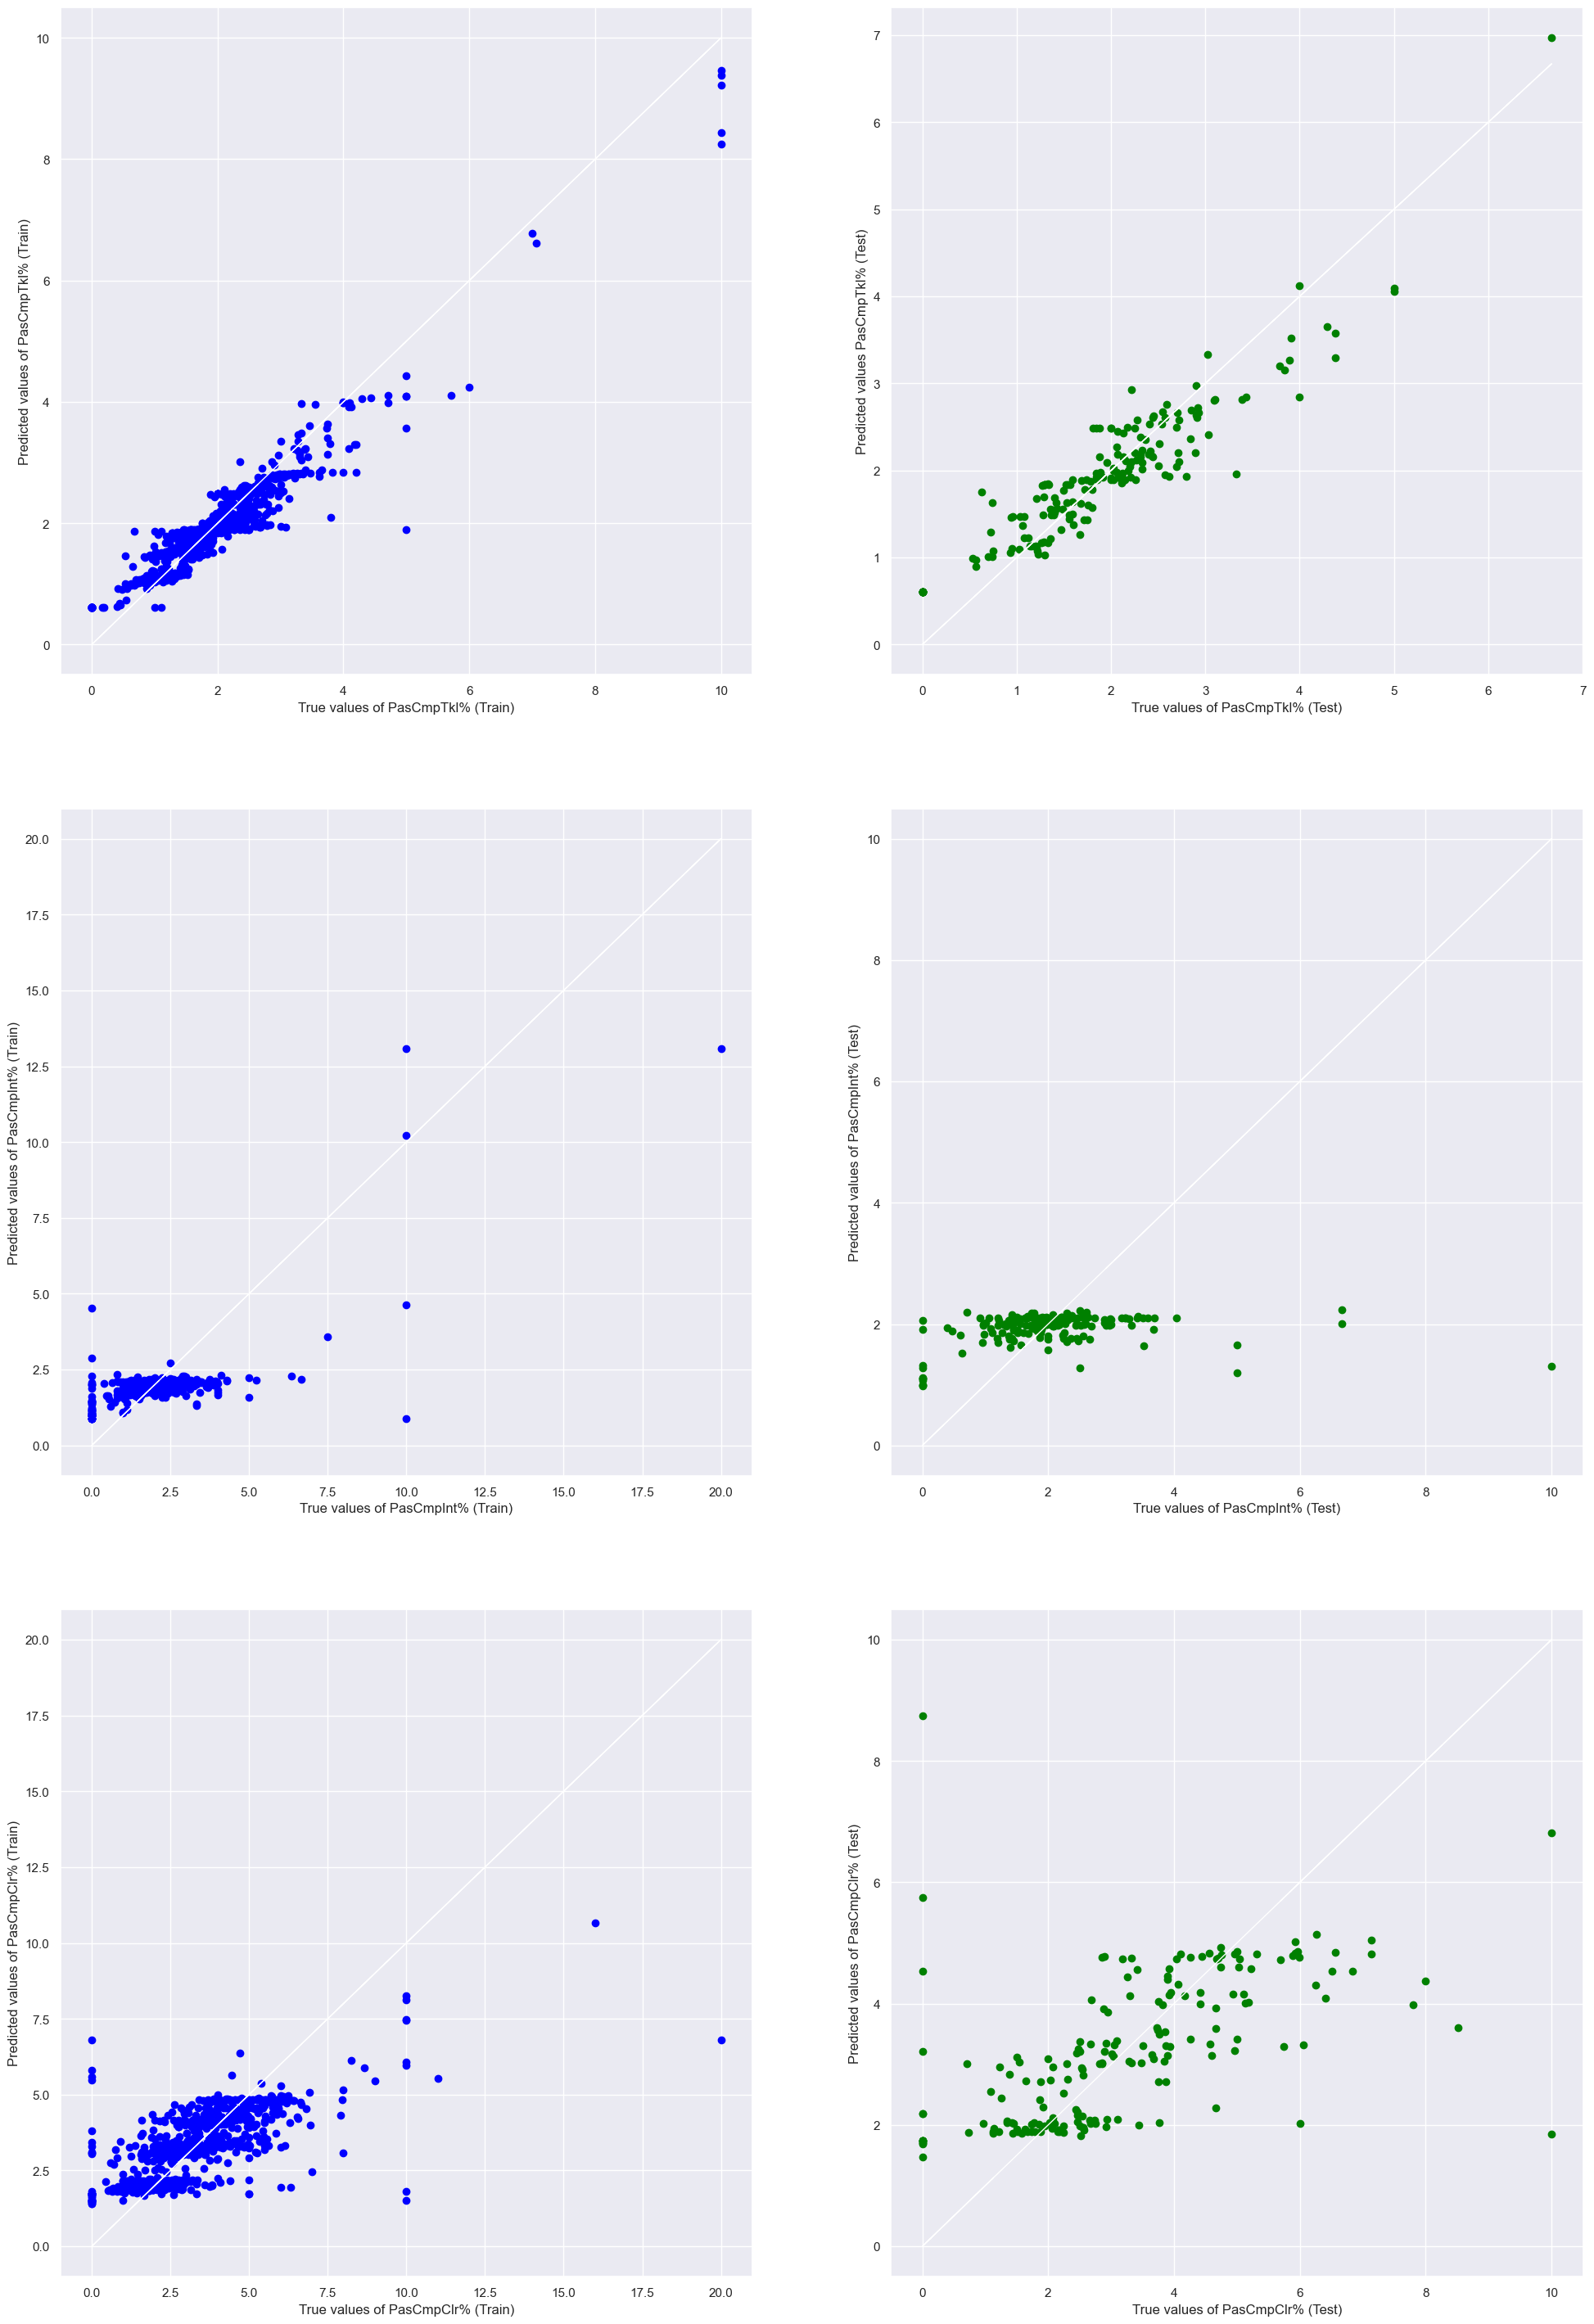

In [31]:
f, axes = plt.subplots(3, 2, figsize=(24, 36))
axes[0][0].scatter(DF_Y_Train_Tkl, DF_ranfor_Tkl.predict(DF_X_Train), color = "blue")
axes[0][0].plot(DF_Y_Train_Tkl, DF_Y_Train_Tkl, 'w-', linewidth = 1)
axes[0][0].set_xlabel("True values of PasCmpTkl% (Train)")
axes[0][0].set_ylabel("Predicted values of PasCmpTkl% (Train)")
axes[0][1].scatter(DF_Y_Test_Tkl, DF_ranfor_Tkl.predict(DF_X_Test), color = "green")
axes[0][1].plot(DF_Y_Test_Tkl, DF_Y_Test_Tkl, 'w-', linewidth = 1)
axes[0][1].set_xlabel("True values of PasCmpTkl% (Test)")
axes[0][1].set_ylabel("Predicted values PasCmpTkl% (Test)")

axes[1][0].scatter(DF_Y_Train_Int, DF_ranfor_Int.predict(DF_X_Train), color = "blue")
axes[1][0].plot(DF_Y_Train_Int, DF_Y_Train_Int, 'w-', linewidth = 1)
axes[1][0].set_xlabel("True values of PasCmpInt% (Train)")
axes[1][0].set_ylabel("Predicted values of PasCmpInt% (Train)")
axes[1][1].scatter(DF_Y_Test_Int, DF_ranfor_Int.predict(DF_X_Test), color = "green")
axes[1][1].plot(DF_Y_Test_Int, DF_Y_Test_Int, 'w-', linewidth = 1)
axes[1][1].set_xlabel("True values of PasCmpInt% (Test)")
axes[1][1].set_ylabel("Predicted values of PasCmpInt% (Test)")

axes[2][0].scatter(DF_Y_Train_Clr, DF_ranfor_Clr.predict(DF_X_Train), color = "blue")
axes[2][0].plot(DF_Y_Train_Clr, DF_Y_Train_Clr, 'w-', linewidth = 1)
axes[2][0].set_xlabel("True values of PasCmpClr% (Train)")
axes[2][0].set_ylabel("Predicted values of PasCmpClr% (Train)")
axes[2][1].scatter(DF_Y_Test_Clr, DF_ranfor_Clr.predict(DF_X_Test), color = "green")
axes[2][1].plot(DF_Y_Test_Clr, DF_Y_Test_Clr, 'w-', linewidth = 1)
axes[2][1].set_xlabel("True values of PasCmpClr% (Test)")
axes[2][1].set_ylabel("Predicted values of PasCmpClr% (Test)")

print("Random Forest for Defenders:")
print("Tkl Out-of-Bag Score: \t\t", Tkl_oob_score) #Higher better
print("Tkl Mean Squared Error: \t", Tkl_mse)
print("Tkl R-squared: \t\t\t", Tkl_r2)
print("Int Out-of-Bag Score: \t\t", Int_oob_score) #Higher better
print("Int Mean Squared Error: \t", Int_mse)
print("Int R-squared: \t\t\t", Int_r2)
print("Clr Out-of-Bag Score: \t\t", Clr_oob_score) #Higher better
print("Clr Mean Squared Error: \t", Clr_mse)
print("Clr R-squared: \t\t\t", Clr_r2)

In [32]:
FW_Relevant['P_G/Sh_RF'] = FW_ranfor_GSh.predict(FW_X)
FW_Relevant['P_G/SoT_RF'] = FW_ranfor_GSoT.predict(FW_X)
MF_Relevant['P_PasCmpSho%_RF'] = MF_ranfor_Sho.predict(MF_X)
MF_Relevant['P_PasCmpMed%_RF'] = MF_ranfor_Med.predict(MF_X)
MF_Relevant['P_PasCmpLon%_RF'] = MF_ranfor_Lon.predict(MF_X)
DF_Relevant['P_Tkl_RF'] = DF_ranfor_Tkl.predict(DF_X)
DF_Relevant['P_Int_RF'] = DF_ranfor_Int.predict(DF_X)
DF_Relevant['P_Clr_RF'] = DF_ranfor_Clr.predict(DF_X)
FW_Relevant.round(2)
MF_Relevant.round(2)
DF_Relevant.round(2)

Player   Tkl   Int   Clr  BlkSh  BlkPass  TklDef3rd  \
0               Max Aarons  2.16  1.75  2.19   0.69     2.00       1.56   
1         Yunis Abdelhamid  1.87  3.11  3.20   0.79     1.09       1.24   
8               Luis Abram  1.13  1.77  6.29   0.81     1.29       0.81   
9         Francesco Acerbi  0.96  1.70  4.08   1.06     0.64       0.64   
12            Marcos Acuña  2.31  1.24  1.20   0.16     1.27       1.31   
...                    ...   ...   ...   ...    ...      ...        ...   
2906  Christoph Zimmermann  2.94  1.76  1.76   0.00     0.00       1.76   
2907   Oleksandr Zinchenko  1.72  1.55  1.12   0.26     1.29       0.60   
2912        Banhie Zoukrou  1.11  2.22  1.11   0.00     0.00       1.11   
2913            Kurt Zouma  0.48  2.03  6.06   1.17     0.48       0.39   
2915         Igor Zubeldia  1.42  1.69  3.44   0.49     0.98       0.93   

      TklMid3rd  PasTotCmp%  PasLonCmp%  AerWon%  AerWon  P_Tkl_LR  P_Int_LR  \
0          0.59        75.5        45.2     22.7    0.47      2.35      2.20   
1          0.60        82.4        61.7     59.8    2.02      1.98      1.94   
8          0.16        88.2        75.0     44.4    1.94      1.08      2.06   
9          0.32        90.3        77.1     64.0    2.84      1.03      1.83   
12         0.60        79.4        58.0     47.1    1.31      2.09      1.99   
...         ...         ...         ...      ...     ...       ...       ...   
2906       1.18        72.7        47.1     66.7    1.18      3.15      1.56   
2907       0.86        89.3        73.0     51.5    1.47      1.62      2.17   
2912       0.00        92.3        75.0     33.3    1.11      1.20      1.52   
2913       0.09        88.9        70.3     68.8    2.38      0.55      1.62   
2915       0.49        88.8        78.4     55.2    2.62      1.53      2.03   

      P_Clr_LR  P_Tkl_RF  P_Int_RF  P_Clr_RF  
0         2.17      2.37      2.09      2.80  
1         3.47      2.05      2.08      4.16  
8         3.41      1.04      1.97      4.06  
9         4.28      1.11      1.86      4.60  
12        2.46      2.09      2.07      2.04  
...        ...       ...       ...       ...  
2906      2.51      2.80      1.98      2.05  
2907      2.37      1.89      1.84      1.99  
2912      2.44      1.15      1.91      1.92  
2913      4.17      0.91      1.74      4.37  
2915      3.57      1.57      2.00      3.60  

[942 rows x 18 columns]

Text(0, 0.5, 'Predicted values of Clr')

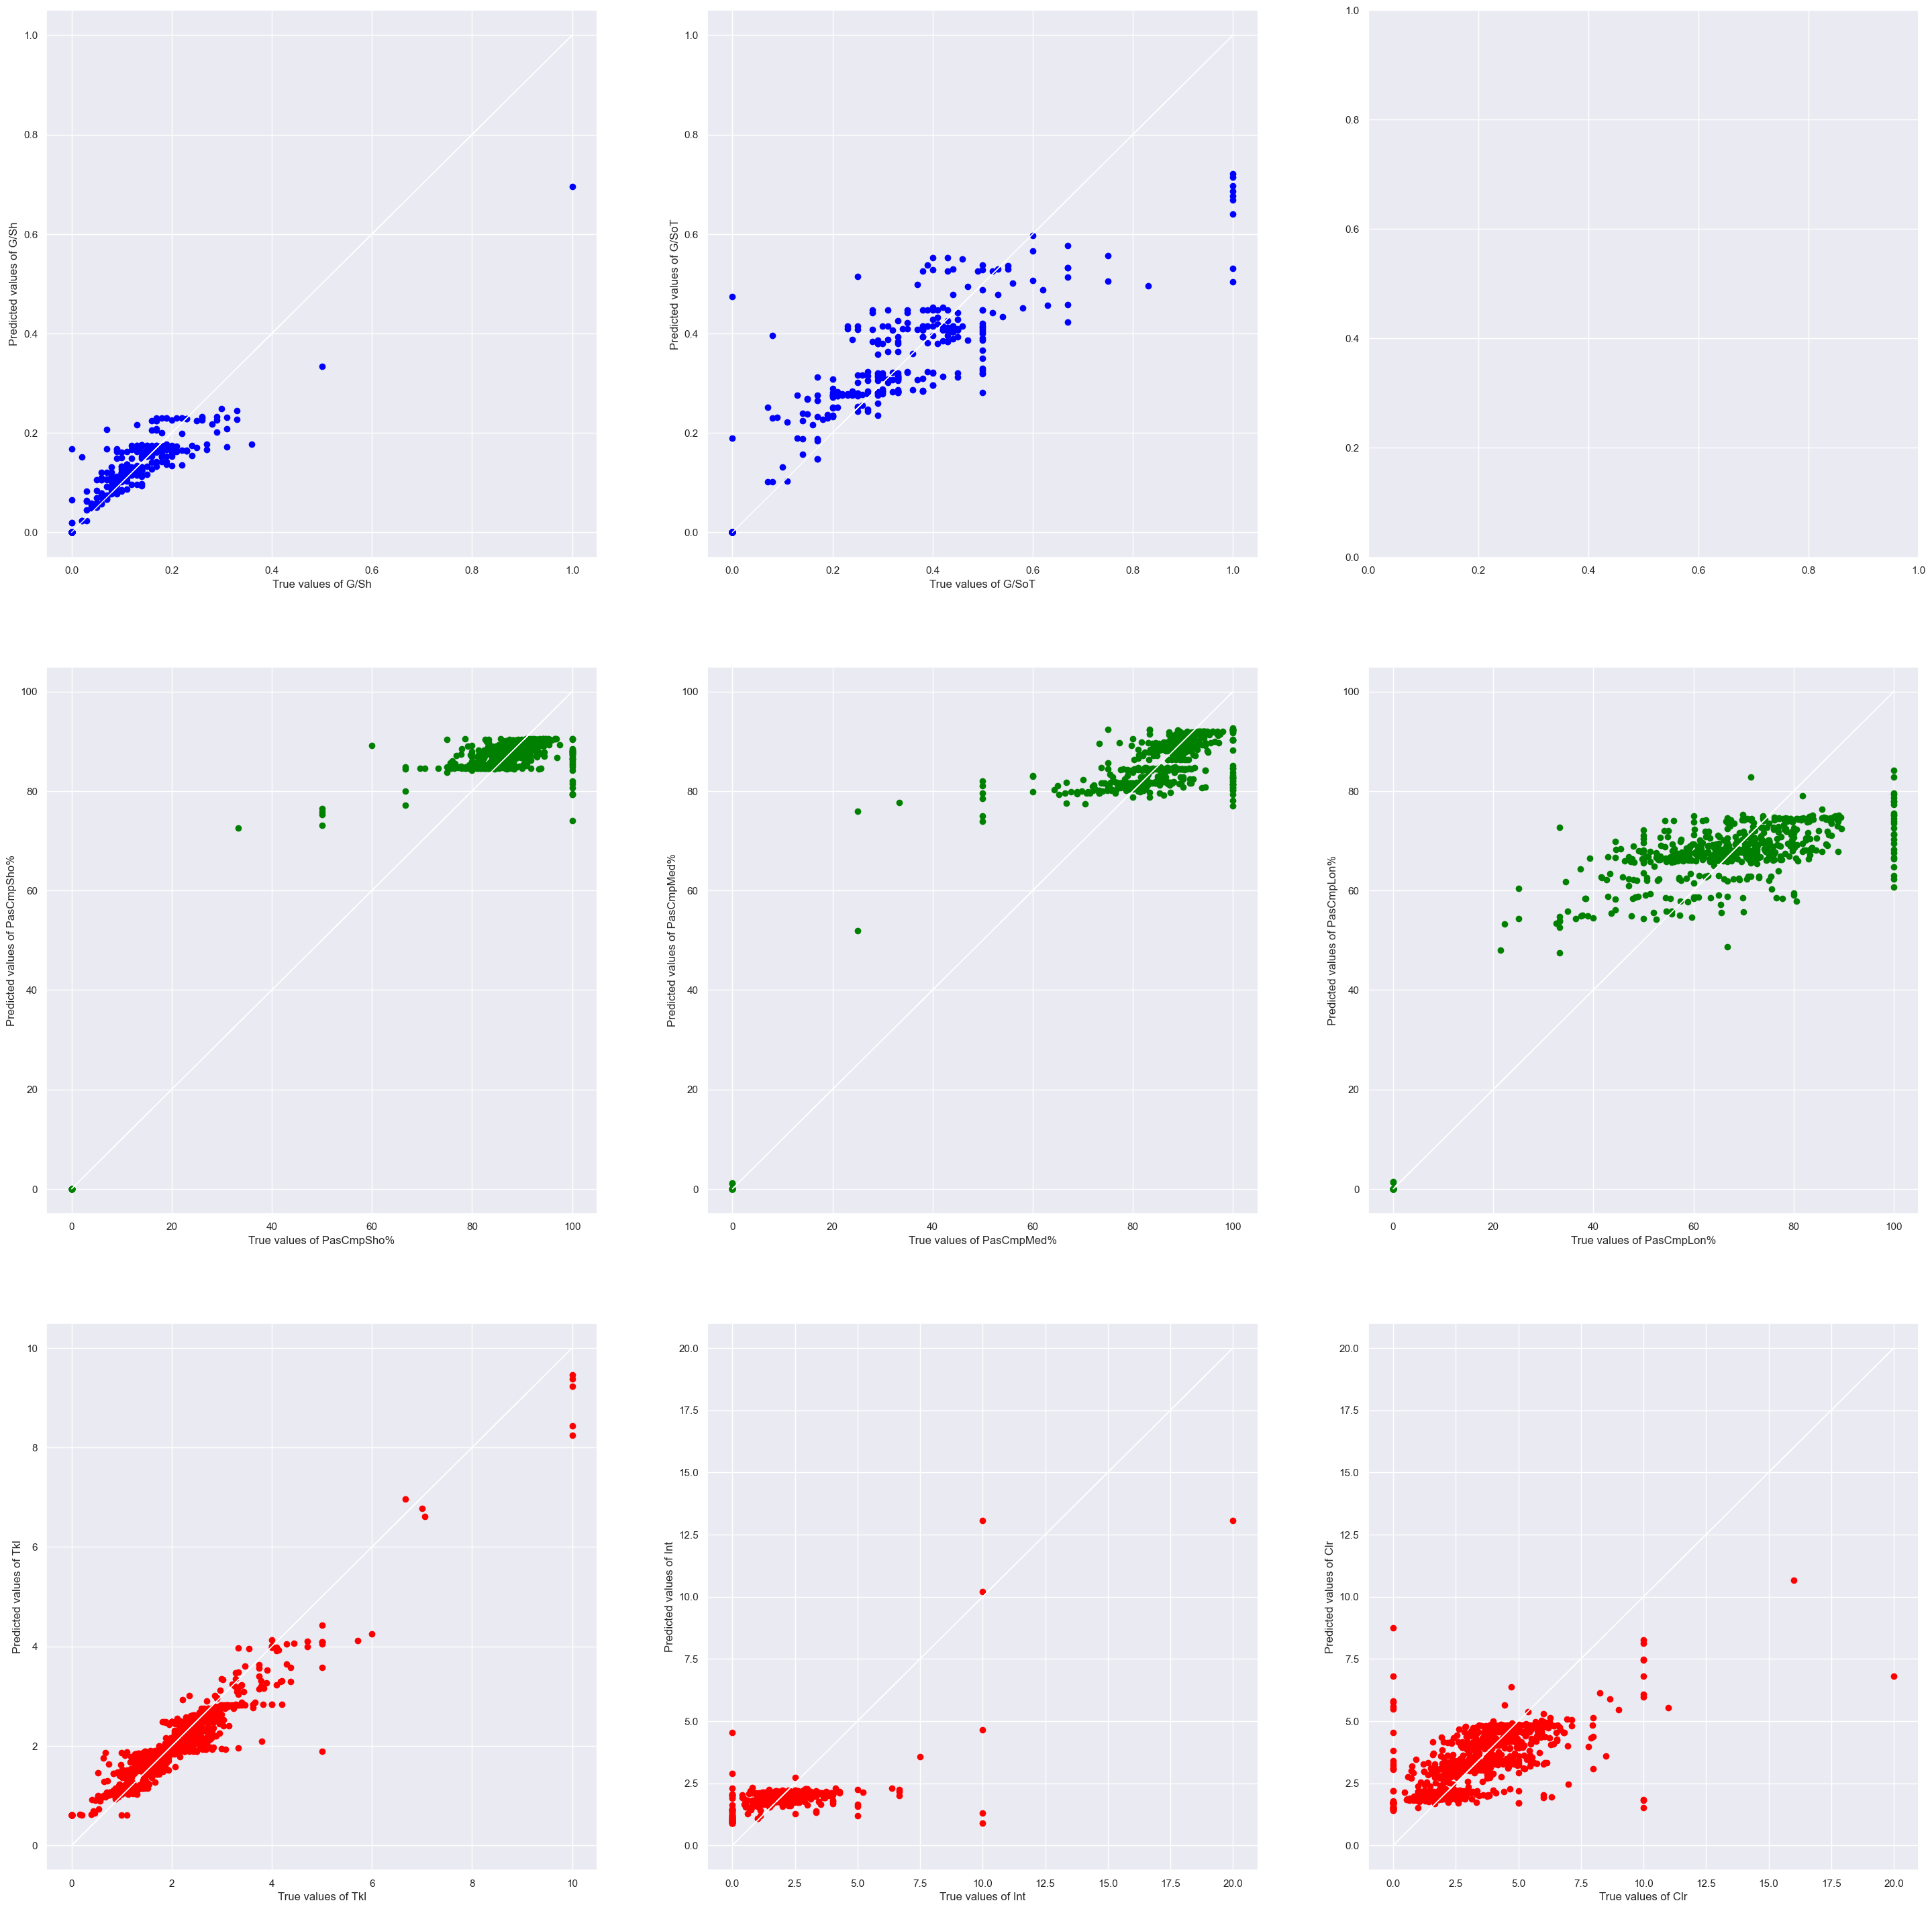

In [33]:
f, axes = plt.subplots(3, 3, figsize=(36, 36))
axes[0][0].scatter(FW_Y_GSh, FW_Relevant['P_G/Sh_RF'], color = "blue")
axes[0][0].plot(FW_Y_GSh, FW_Y_GSh, 'w-', linewidth = 1)
axes[0][0].set_xlabel("True values of G/Sh")
axes[0][0].set_ylabel("Predicted values of G/Sh")
axes[0][1].scatter(FW_Y_GSoT, FW_Relevant['P_G/SoT_RF'], color = "blue")
axes[0][1].plot(FW_Y_GSoT, FW_Y_GSoT, 'w-', linewidth = 1)
axes[0][1].set_xlabel("True values of G/SoT")
axes[0][1].set_ylabel("Predicted values of G/SoT")

axes[1][0].scatter(MF_Y_Sho, MF_Relevant['P_PasCmpSho%_RF'], color = "green")
axes[1][0].plot(MF_Y_Sho, MF_Y_Sho, 'w-', linewidth = 1)
axes[1][0].set_xlabel("True values of PasCmpSho%")
axes[1][0].set_ylabel("Predicted values of PasCmpSho%")
axes[1][1].scatter(MF_Y_Med, MF_Relevant['P_PasCmpMed%_RF'], color = "green")
axes[1][1].plot(MF_Y_Med, MF_Y_Med, 'w-', linewidth = 1)
axes[1][1].set_xlabel("True values of PasCmpMed%")
axes[1][1].set_ylabel("Predicted values of PasCmpMed%")
axes[1][2].scatter(MF_Y_Lon, MF_Relevant['P_PasCmpLon%_RF'], color = "green")
axes[1][2].plot(MF_Y_Lon, MF_Y_Lon, 'w-', linewidth = 1)
axes[1][2].set_xlabel("True values of PasCmpLon%")
axes[1][2].set_ylabel("Predicted values of PasCmpLon%")

axes[2][0].scatter(DF_Y_Tkl, DF_Relevant['P_Tkl_RF'], color = "red")
axes[2][0].plot(DF_Y_Tkl, DF_Y_Tkl, 'w-', linewidth = 1)
axes[2][0].set_xlabel("True values of Tkl")
axes[2][0].set_ylabel("Predicted values of Tkl")
axes[2][1].scatter(DF_Y_Int, DF_Relevant['P_Int_RF'], color = "red")
axes[2][1].plot(DF_Y_Int, DF_Y_Int, 'w-', linewidth = 1)
axes[2][1].set_xlabel("True values of Int")
axes[2][1].set_ylabel("Predicted values of Int")
axes[2][2].scatter(DF_Y_Clr, DF_Relevant['P_Clr_RF'], color = "red")
axes[2][2].plot(DF_Y_Clr, DF_Y_Clr, 'w-', linewidth = 1)
axes[2][2].set_xlabel("True values of Clr")
axes[2][2].set_ylabel("Predicted values of Clr")

# Step 4c: Gradient Boosting Regressor

Similar to Random Forest, Gradient Booster sequentially combines the prediction of multiple weak learners to create a single, more accurate strong learner. It goes through multiple iterations and optimizes the weights of the model based on the errors of the previous iterations. This gradually reduces prediction errors and enhances accuracy.

In [34]:
FW_gradient_GSh = GradientBoostingRegressor(max_depth=3)
FW_gradient_GSh.fit(FW_X_Train, FW_Y_Train_GSh)
GSh_gradient = FW_gradient_GSh.predict(FW_X_Test)
FW_gradient_GSoT = GradientBoostingRegressor(max_depth=3)
FW_gradient_GSoT.fit(FW_X_Train, FW_Y_Train_GSoT)
GSoT_gradient = FW_gradient_GSoT.predict(FW_X_Test)

MF_gradient_Sho = GradientBoostingRegressor(max_depth=3)
MF_gradient_Sho.fit(MF_X_Train, MF_Y_Train_Sho)
Sho_gradient = MF_gradient_Sho.predict(MF_X_Test)
MF_gradient_Med = GradientBoostingRegressor(max_depth=3)
MF_gradient_Med.fit(MF_X_Train, MF_Y_Train_Med)
Med_gradient = MF_gradient_Sho.predict(MF_X_Test)
MF_gradient_Lon = GradientBoostingRegressor(max_depth=3)
MF_gradient_Lon.fit(MF_X_Train, MF_Y_Train_Lon)
Lon_gradient = MF_gradient_Sho.predict(MF_X_Test)

DF_gradient_Tkl = GradientBoostingRegressor(max_depth=3)
DF_gradient_Tkl.fit(DF_X_Train, DF_Y_Train_Tkl)
Tkl_gradient = DF_gradient_Tkl.predict(DF_X_Test)
DF_gradient_Int = GradientBoostingRegressor(max_depth=3)
DF_gradient_Int.fit(DF_X_Train, DF_Y_Train_Int)
Int_gradient = DF_gradient_Int.predict(DF_X_Test)
DF_gradient_Clr = GradientBoostingRegressor(max_depth=3)
DF_gradient_Clr.fit(DF_X_Train, DF_Y_Train_Clr)
Clr_gradient = DF_gradient_Clr.predict(DF_X_Test)

GSh_gradient_mse = mean_squared_error(FW_Y_Test_GSh, GSh_gradient)
GSh_gradient_r2=r2_score(FW_Y_Test_GSh, GSh_gradient)
GSoT_gradient_mse = mean_squared_error(FW_Y_Test_GSoT, GSh_gradient)
GSoT_gradient_r2=r2_score(FW_Y_Test_GSoT, GSh_gradient)

Sho_gradient_mse = mean_squared_error(MF_Y_Test_Sho, Sho_gradient)
Sho_gradient_r2=r2_score(MF_Y_Test_Sho, Sho_gradient)
Med_gradient_mse = mean_squared_error(MF_Y_Test_Med, Med_gradient)
Med_gradient_r2=r2_score(MF_Y_Test_Med, Med_gradient)
Lon_gradient_mse = mean_squared_error(MF_Y_Test_Lon, Lon_gradient)
Lon_gradient_r2=r2_score(MF_Y_Test_Lon, Lon_gradient)

Tkl_gradient_mse = mean_squared_error(DF_Y_Test_Tkl, Tkl_gradient)
Tkl_gradient_r2=r2_score(DF_Y_Test_Tkl, Tkl_gradient)
Int_gradient_mse = mean_squared_error(DF_Y_Test_Int, Int_gradient)
Int_gradient_r2=r2_score(DF_Y_Test_Int, Int_gradient)
Clr_gradient_mse = mean_squared_error(DF_Y_Test_Clr, Clr_gradient)
Clr_gradient_r2=r2_score(DF_Y_Test_Clr, Clr_gradient)

FW_gradient_GSh.train_score_.round(4)

array([0.0084, 0.007 , 0.0059, 0.005 , 0.0043, 0.0037, 0.0032, 0.0028,
       0.0024, 0.0021, 0.0019, 0.0017, 0.0015, 0.0013, 0.0012, 0.0011,
       0.001 , 0.0009, 0.0008, 0.0008, 0.0007, 0.0007, 0.0006, 0.0006,
       0.0006, 0.0005, 0.0005, 0.0005, 0.0004, 0.0004, 0.0004, 0.0004,
       0.0004, 0.0004, 0.0004, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003,
       0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
       0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
       0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
       0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001])

Gradient Boosting for Forwards:
G/Sh Mean Squared Error: 	 0.0006391802167322237
G/Sh R-squared: 		 0.8974490921909339
G/SoT Mean Squared Error: 	 0.04803960608900196
G/SoT R-squared: 		 0.018014755052284115


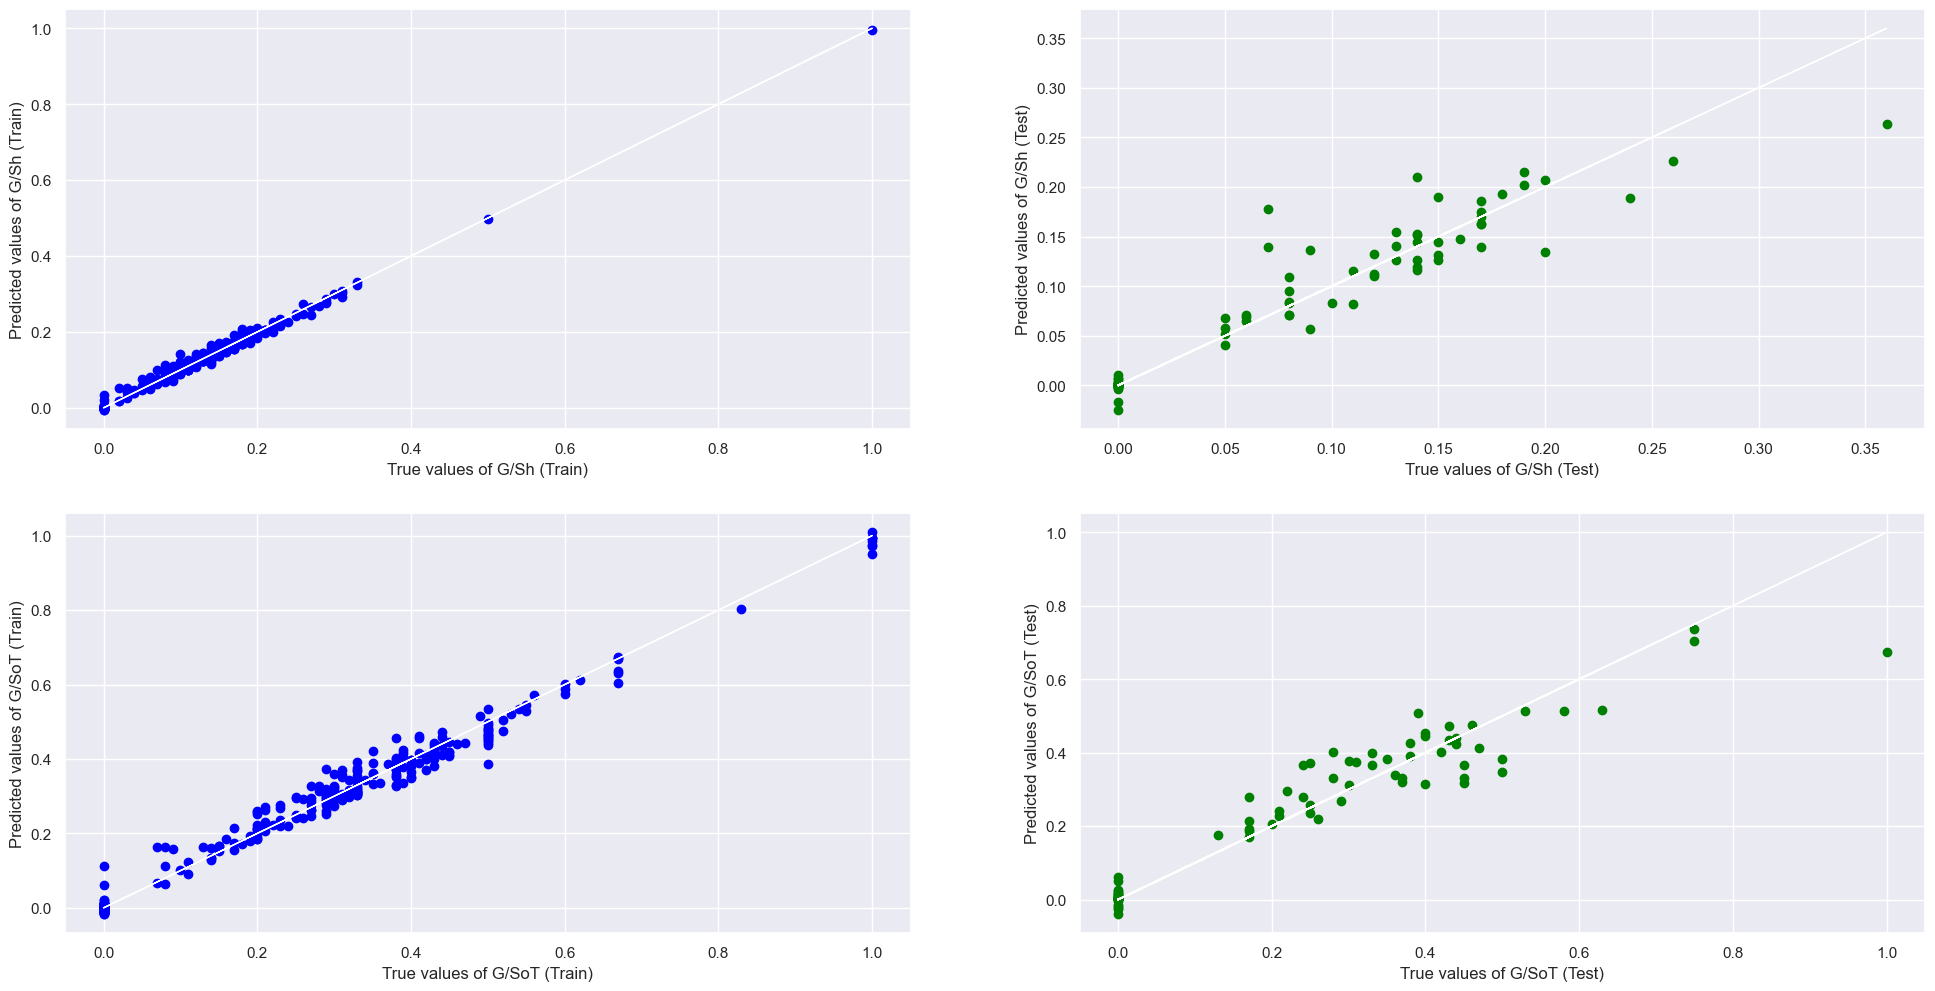

In [35]:
f, axes = plt.subplots(2, 2, figsize=(24, 12))
axes[0][0].scatter(FW_Y_Train_GSh, FW_gradient_GSh.predict(FW_X_Train), color = "blue")
axes[0][0].plot(FW_Y_Train_GSh, FW_Y_Train_GSh, 'w-', linewidth = 1)
axes[0][0].set_xlabel("True values of G/Sh (Train)")
axes[0][0].set_ylabel("Predicted values of G/Sh (Train)")
axes[0][1].scatter(FW_Y_Test_GSh, FW_gradient_GSh.predict(FW_X_Test), color = "green")
axes[0][1].plot(FW_Y_Test_GSh, FW_Y_Test_GSh, 'w-', linewidth = 1)
axes[0][1].set_xlabel("True values of G/Sh (Test)")
axes[0][1].set_ylabel("Predicted values of G/Sh (Test)")

axes[1][0].scatter(FW_Y_Train_GSoT, FW_gradient_GSoT.predict(FW_X_Train), color = "blue")
axes[1][0].plot(FW_Y_Train_GSoT, FW_Y_Train_GSoT, 'w-', linewidth = 1)
axes[1][0].set_xlabel("True values of G/SoT (Train)")
axes[1][0].set_ylabel("Predicted values of G/SoT (Train)")
axes[1][1].scatter(FW_Y_Test_GSoT, FW_gradient_GSoT.predict(FW_X_Test), color = "green")
axes[1][1].plot(FW_Y_Test_GSoT, FW_Y_Test_GSoT, 'w-', linewidth = 1)
axes[1][1].set_xlabel("True values of G/SoT (Test)")
axes[1][1].set_ylabel("Predicted values of G/SoT (Test)")

print("Gradient Boosting for Forwards:")
print("G/Sh Mean Squared Error: \t", GSh_gradient_mse)
print("G/Sh R-squared: \t\t", GSh_gradient_r2)
print("G/SoT Mean Squared Error: \t", GSoT_gradient_mse)
print("G/SoT R-squared: \t\t", GSoT_gradient_r2)

Gradient Boosting for MidFielders:
Sho Mean Squared Error: 	 46.881533772949844
Sho R-squared: 			 0.8284573965421389
Med Mean Squared Error: 	 414.2560307160762
Med R-squared: 			 -1.1967079034933734
Lon Mean Squared Error: 	 848.4409828469726
Lon R-squared: 			 -0.7118126835999352


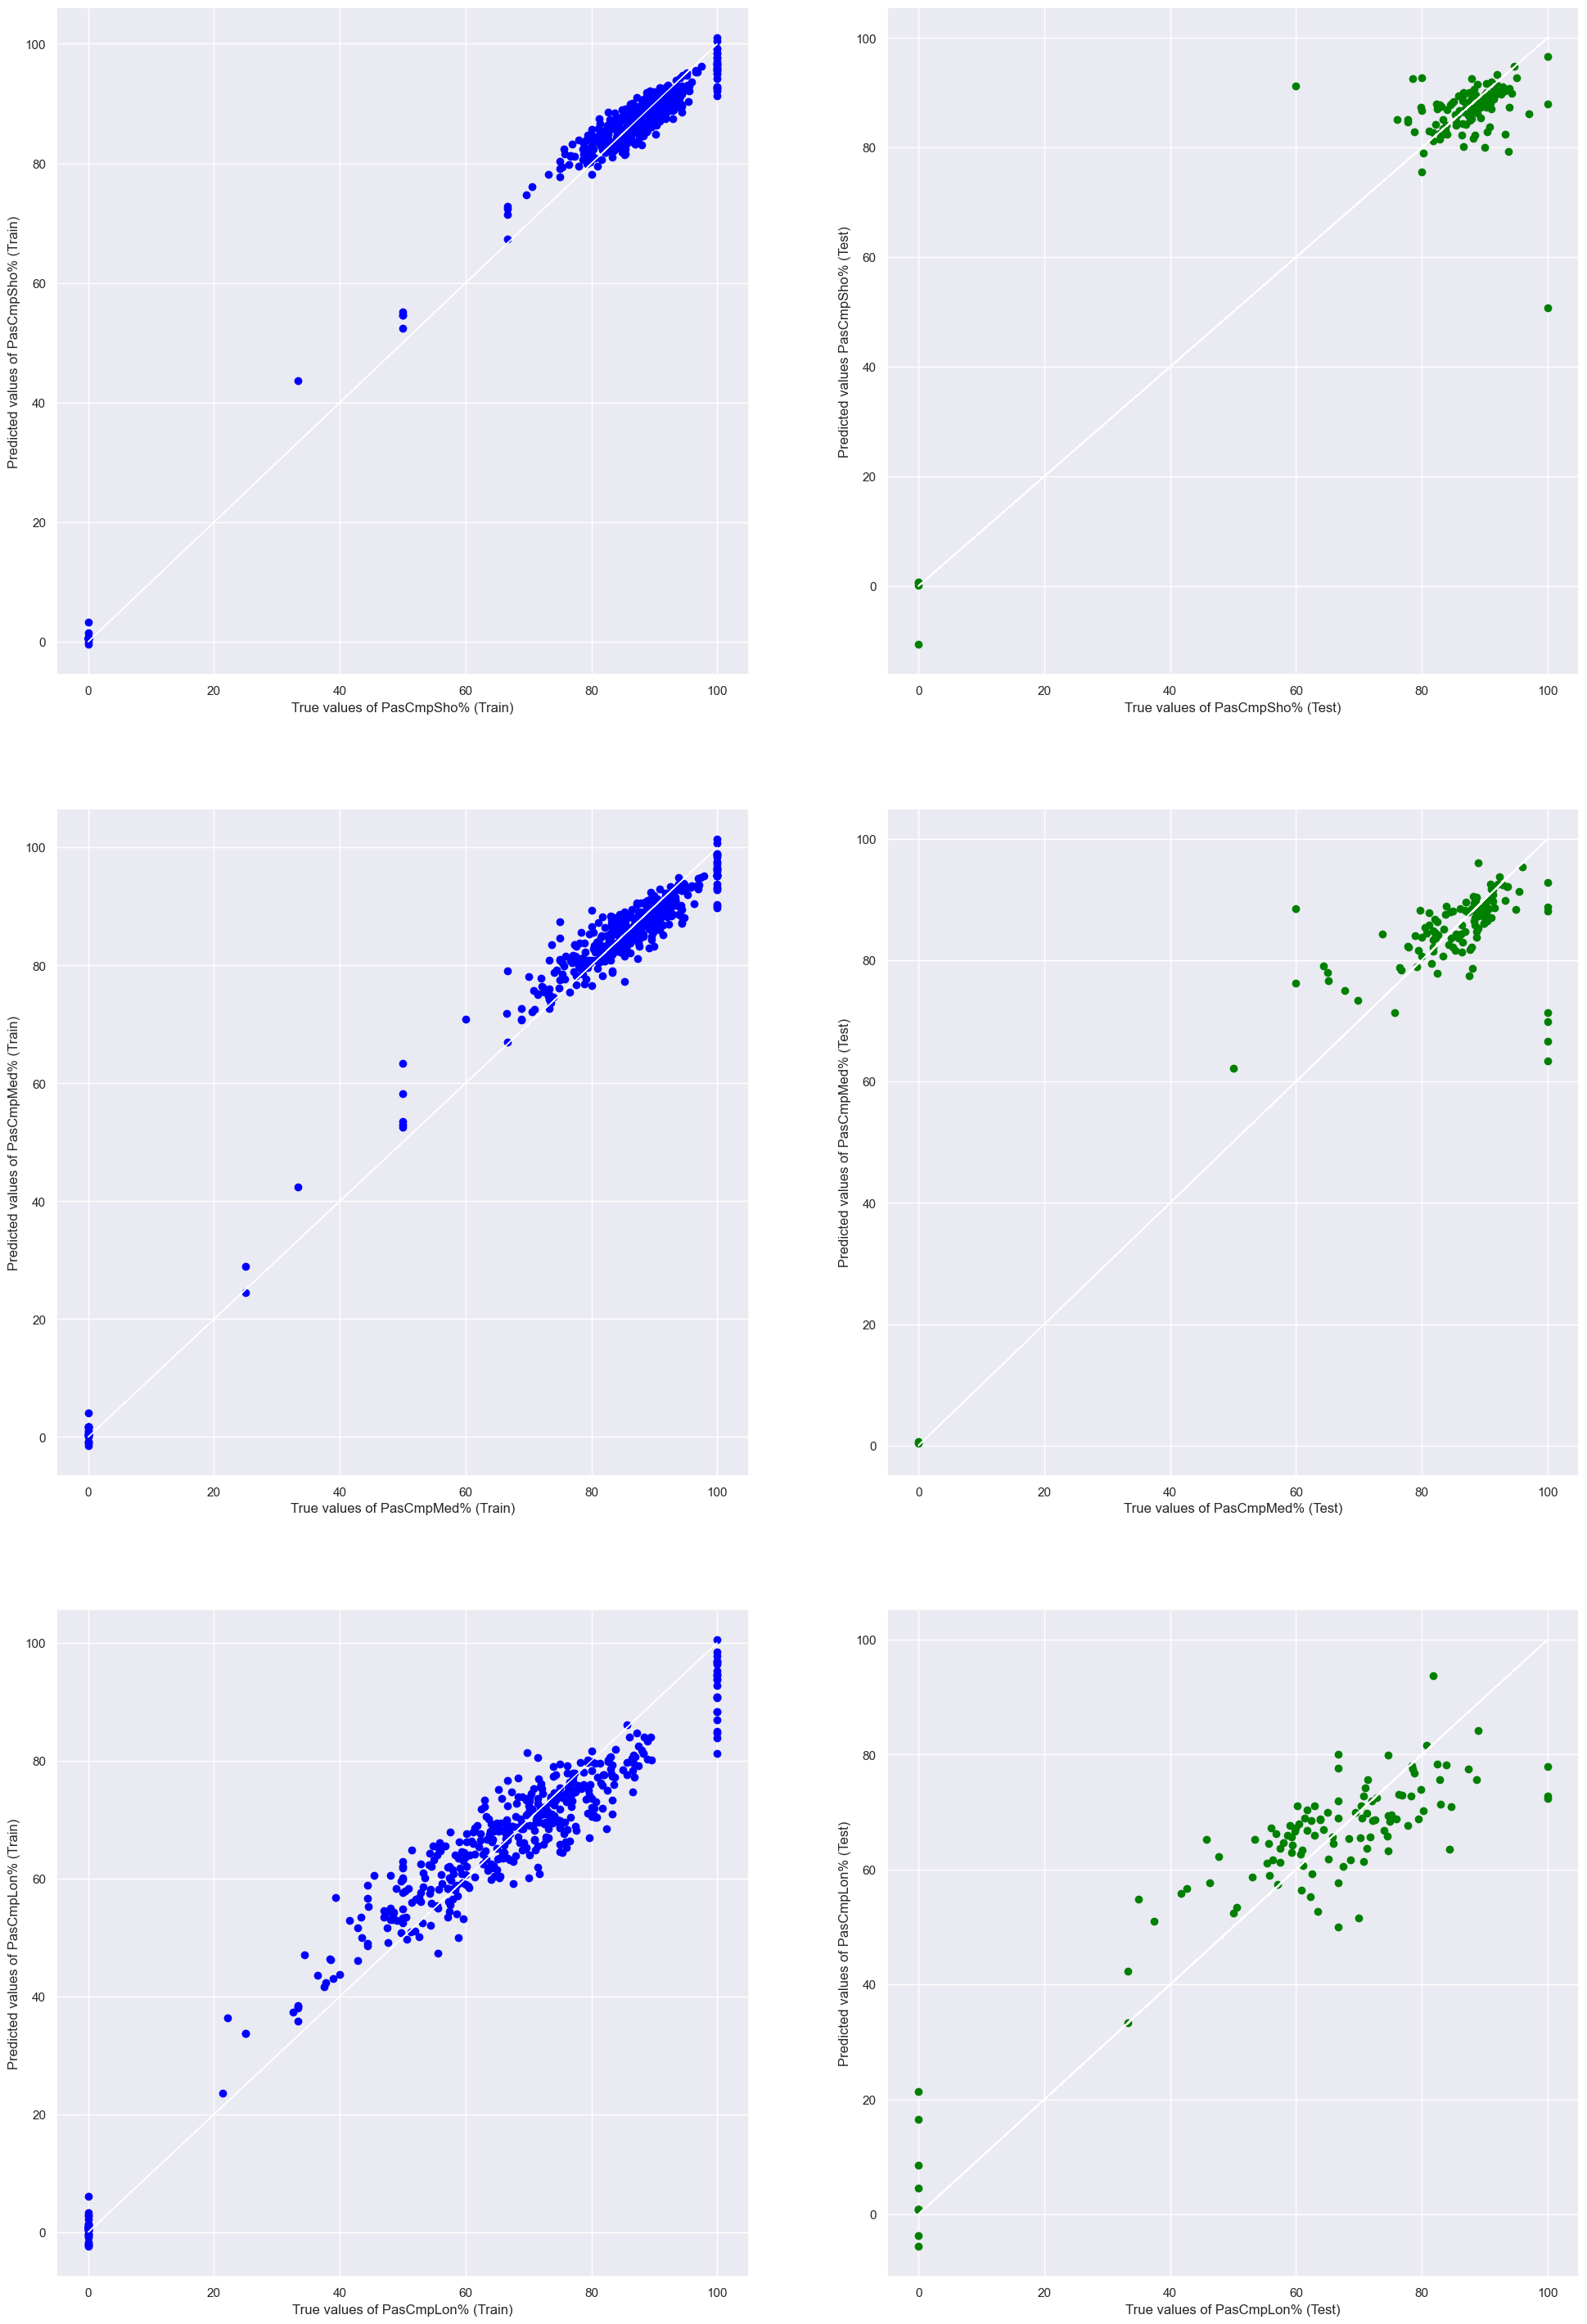

In [36]:
f, axes = plt.subplots(3, 2, figsize=(24, 36))
axes[0][0].scatter(MF_Y_Train_Sho, MF_gradient_Sho.predict(MF_X_Train), color = "blue")
axes[0][0].plot(MF_Y_Train_Sho, MF_Y_Train_Sho, 'w-', linewidth = 1)
axes[0][0].set_xlabel("True values of PasCmpSho% (Train)")
axes[0][0].set_ylabel("Predicted values of PasCmpSho% (Train)")
axes[0][1].scatter(MF_Y_Test_Sho, MF_gradient_Sho.predict(MF_X_Test), color = "green")
axes[0][1].plot(MF_Y_Test_Sho, MF_Y_Test_Sho, 'w-', linewidth = 1)
axes[0][1].set_xlabel("True values of PasCmpSho% (Test)")
axes[0][1].set_ylabel("Predicted values PasCmpSho% (Test)")

axes[1][0].scatter(MF_Y_Train_Med, MF_gradient_Med.predict(MF_X_Train), color = "blue")
axes[1][0].plot(MF_Y_Train_Med, MF_Y_Train_Med, 'w-', linewidth = 1)
axes[1][0].set_xlabel("True values of PasCmpMed% (Train)")
axes[1][0].set_ylabel("Predicted values of PasCmpMed% (Train)")
axes[1][1].scatter(MF_Y_Test_Med, MF_gradient_Med.predict(MF_X_Test), color = "green")
axes[1][1].plot(MF_Y_Test_Med, MF_Y_Test_Med, 'w-', linewidth = 1)
axes[1][1].set_xlabel("True values of PasCmpMed% (Test)")
axes[1][1].set_ylabel("Predicted values of PasCmpMed% (Test)")

axes[2][0].scatter(MF_Y_Train_Lon, MF_gradient_Lon.predict(MF_X_Train), color = "blue")
axes[2][0].plot(MF_Y_Train_Lon, MF_Y_Train_Lon, 'w-', linewidth = 1)
axes[2][0].set_xlabel("True values of PasCmpLon% (Train)")
axes[2][0].set_ylabel("Predicted values of PasCmpLon% (Train)")
axes[2][1].scatter(MF_Y_Test_Lon, MF_gradient_Lon.predict(MF_X_Test), color = "green")
axes[2][1].plot(MF_Y_Test_Lon, MF_Y_Test_Lon, 'w-', linewidth = 1)
axes[2][1].set_xlabel("True values of PasCmpLon% (Test)")
axes[2][1].set_ylabel("Predicted values of PasCmpLon% (Test)")

print("Gradient Boosting for MidFielders:")
print("Sho Mean Squared Error: \t", Sho_gradient_mse)
print("Sho R-squared: \t\t\t", Sho_gradient_r2)
print("Med Mean Squared Error: \t", Med_gradient_mse)
print("Med R-squared: \t\t\t", Med_gradient_r2)
print("Lon Mean Squared Error: \t", Lon_gradient_mse)
print("Lon R-squared: \t\t\t", Lon_gradient_r2)

Gradient Boosting for Defenders:
Tkl Mean Squared Error: 	 0.045607011815596864
Tkl R-squared: 			 0.9572969258577174
Int Mean Squared Error: 	 1.4412370091876936
Int R-squared: 			 -0.10405652644433627
Clr Mean Squared Error: 	 2.7006996286700735
Clr R-squared: 			 0.26768165099119146


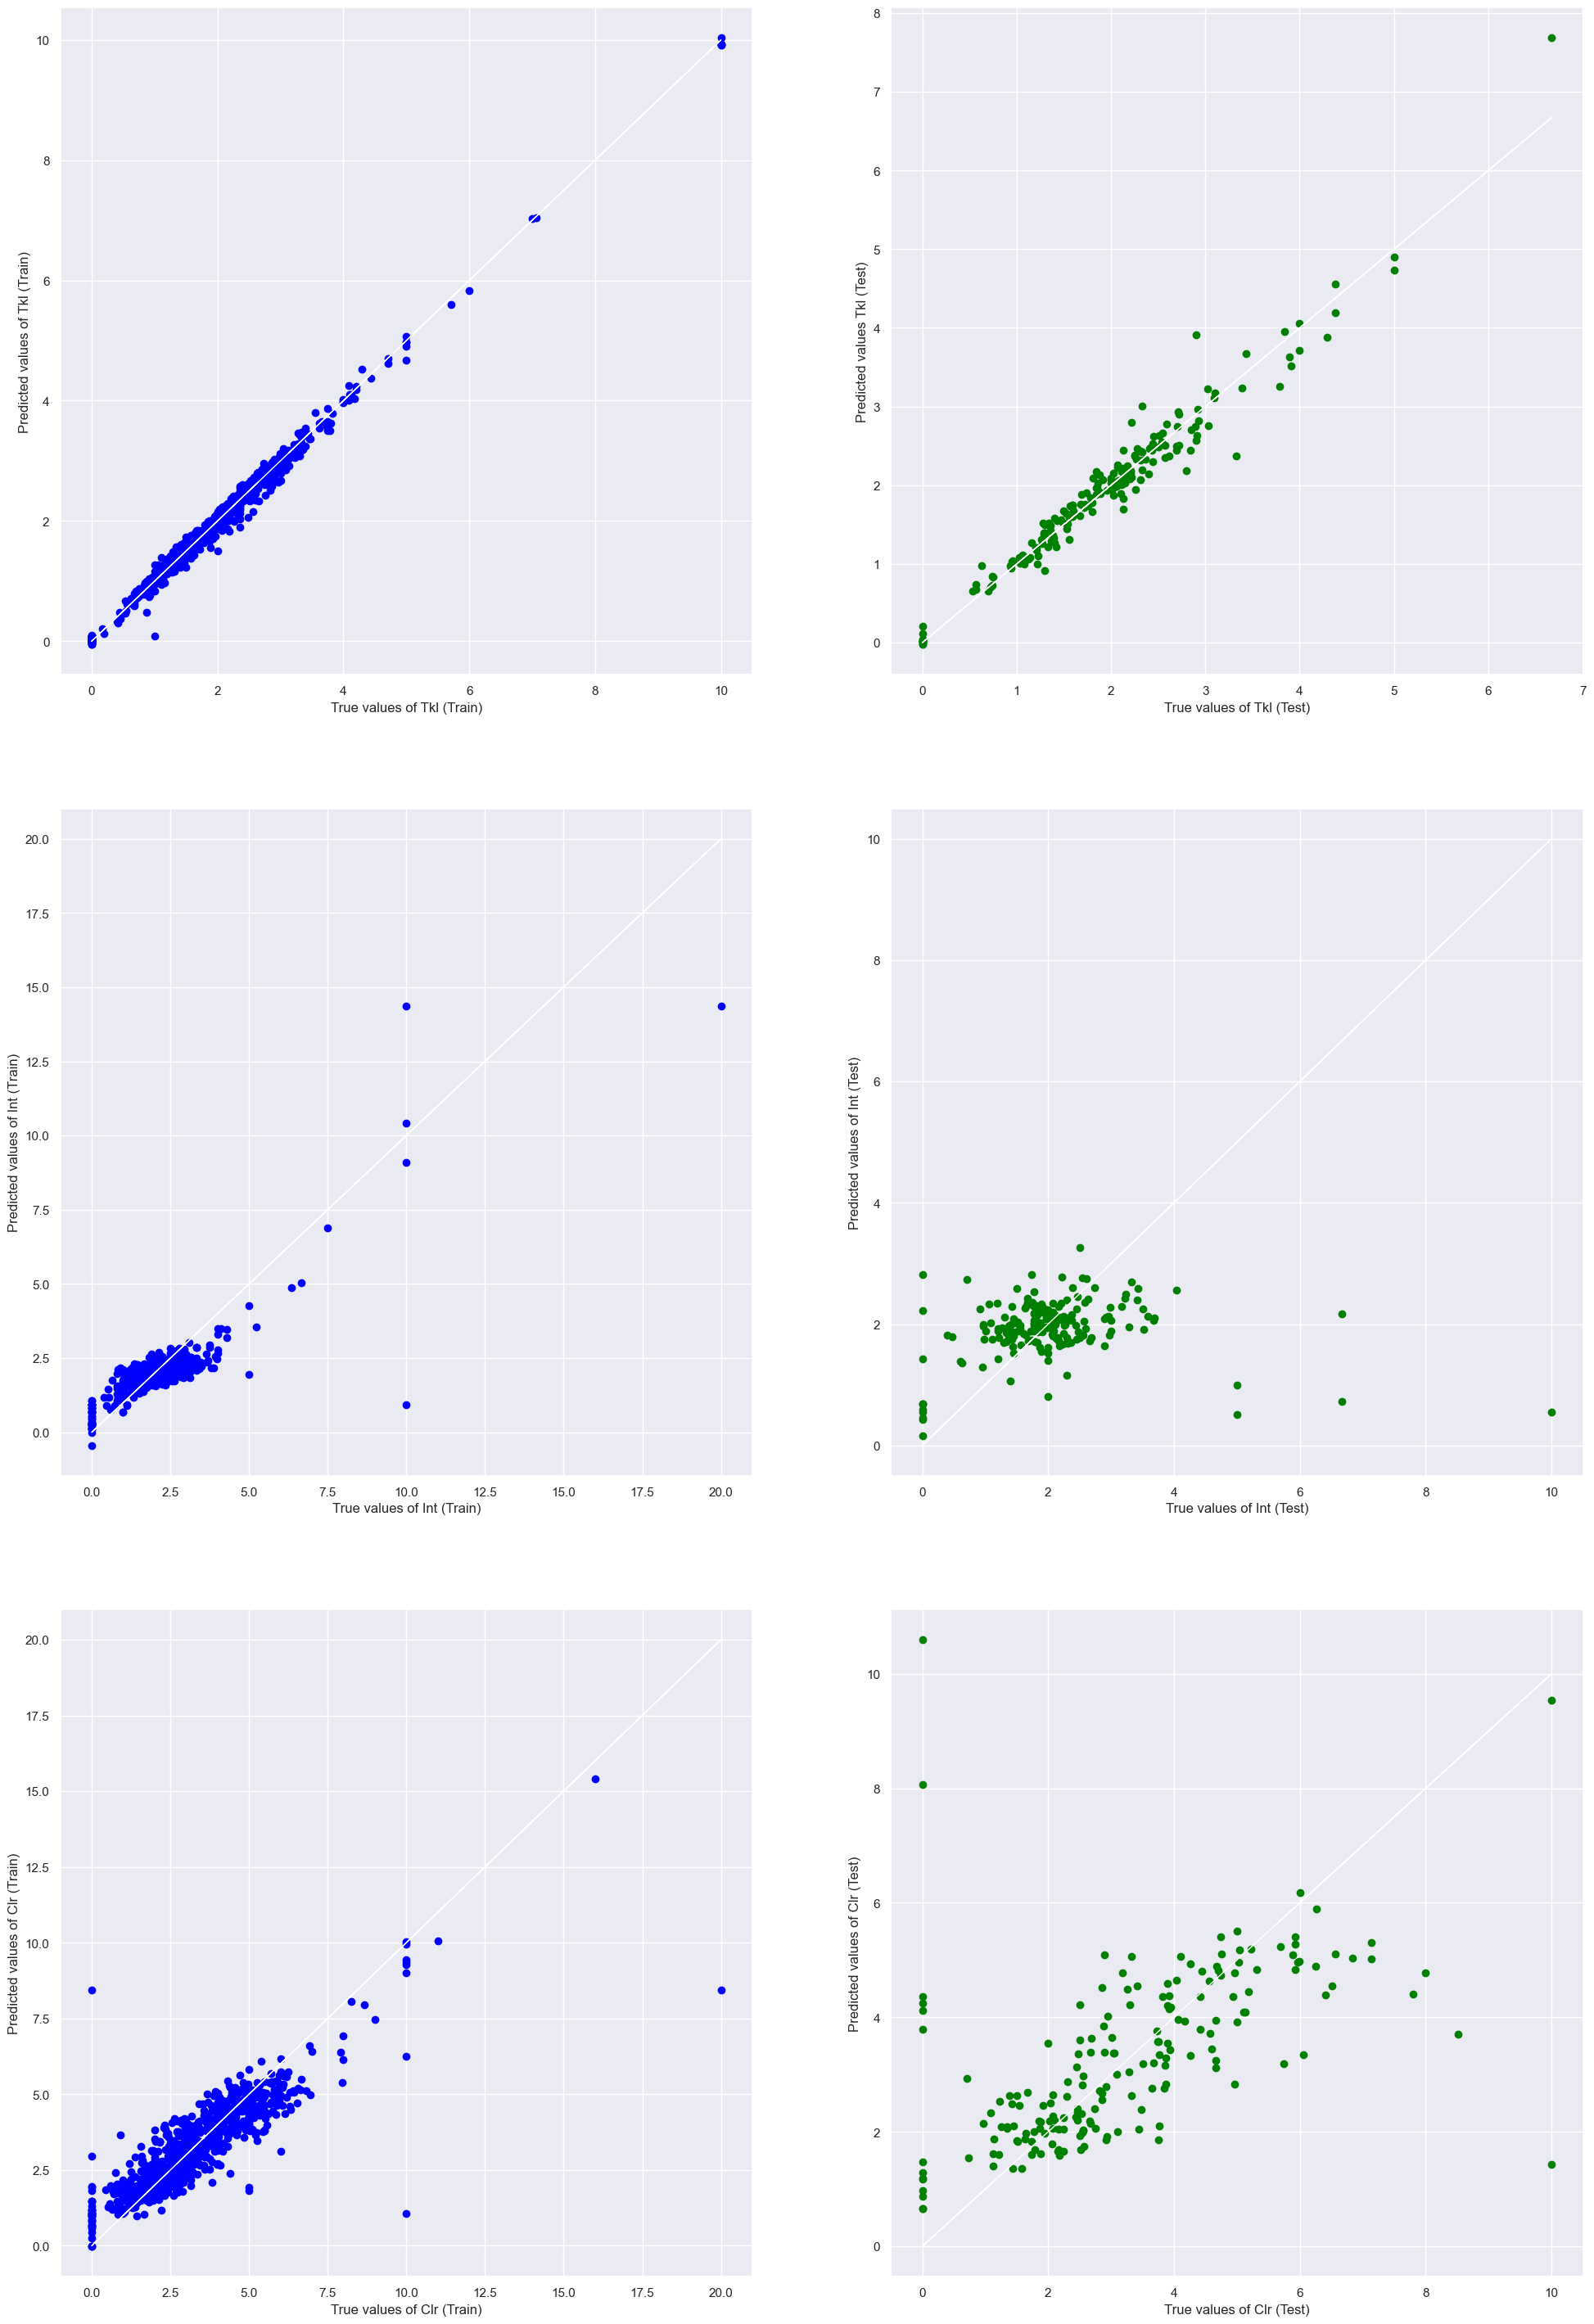

In [37]:
f, axes = plt.subplots(3, 2, figsize=(24, 36))
axes[0][0].scatter(DF_Y_Train_Tkl, DF_gradient_Tkl.predict(DF_X_Train), color = "blue")
axes[0][0].plot(DF_Y_Train_Tkl, DF_Y_Train_Tkl, 'w-', linewidth = 1)
axes[0][0].set_xlabel("True values of Tkl (Train)")
axes[0][0].set_ylabel("Predicted values of Tkl (Train)")
axes[0][1].scatter(DF_Y_Test_Tkl, DF_gradient_Tkl.predict(DF_X_Test), color = "green")
axes[0][1].plot(DF_Y_Test_Tkl, DF_Y_Test_Tkl, 'w-', linewidth = 1)
axes[0][1].set_xlabel("True values of Tkl (Test)")
axes[0][1].set_ylabel("Predicted values Tkl (Test)")

axes[1][0].scatter(DF_Y_Train_Int, DF_gradient_Int.predict(DF_X_Train), color = "blue")
axes[1][0].plot(DF_Y_Train_Int, DF_Y_Train_Int, 'w-', linewidth = 1)
axes[1][0].set_xlabel("True values of Int (Train)")
axes[1][0].set_ylabel("Predicted values of Int (Train)")
axes[1][1].scatter(DF_Y_Test_Int, DF_gradient_Int.predict(DF_X_Test), color = "green")
axes[1][1].plot(DF_Y_Test_Int, DF_Y_Test_Int, 'w-', linewidth = 1)
axes[1][1].set_xlabel("True values of Int (Test)")
axes[1][1].set_ylabel("Predicted values of Int (Test)")

axes[2][0].scatter(DF_Y_Train_Clr, DF_gradient_Clr.predict(DF_X_Train), color = "blue")
axes[2][0].plot(DF_Y_Train_Clr, DF_Y_Train_Clr, 'w-', linewidth = 1)
axes[2][0].set_xlabel("True values of Clr (Train)")
axes[2][0].set_ylabel("Predicted values of Clr (Train)")
axes[2][1].scatter(DF_Y_Test_Clr, DF_gradient_Clr.predict(DF_X_Test), color = "green")
axes[2][1].plot(DF_Y_Test_Clr, DF_Y_Test_Clr, 'w-', linewidth = 1)
axes[2][1].set_xlabel("True values of Clr (Test)")
axes[2][1].set_ylabel("Predicted values of Clr (Test)")

print("Gradient Boosting for Defenders:")
print("Tkl Mean Squared Error: \t", Tkl_gradient_mse)
print("Tkl R-squared: \t\t\t", Tkl_gradient_r2)
print("Int Mean Squared Error: \t", Int_gradient_mse)
print("Int R-squared: \t\t\t", Int_gradient_r2)
print("Clr Mean Squared Error: \t", Clr_gradient_mse)
print("Clr R-squared: \t\t\t", Clr_gradient_r2)

In [38]:
FW_Relevant['P_G/Sh_GB'] = FW_gradient_GSh.predict(FW_X)
FW_Relevant['P_G/SoT_GB'] = FW_gradient_GSoT.predict(FW_X)
MF_Relevant['P_PasCmpSho%_GB'] = MF_gradient_Sho.predict(MF_X)
MF_Relevant['P_PasCmpMed%_GB'] = MF_gradient_Med.predict(MF_X)
MF_Relevant['P_PasCmpLon%_GB'] = MF_gradient_Lon.predict(MF_X)
DF_Relevant['P_Tkl_GB'] = DF_gradient_Tkl.predict(DF_X)
DF_Relevant['P_Int_GB'] = DF_gradient_Int.predict(DF_X)
DF_Relevant['P_Clr_GB'] = DF_gradient_Clr.predict(DF_X)
FW_Relevant.round(2)
MF_Relevant.round(2)
DF_Relevant.round(2)

Player   Tkl   Int   Clr  BlkSh  BlkPass  TklDef3rd  \
0               Max Aarons  2.16  1.75  2.19   0.69     2.00       1.56   
1         Yunis Abdelhamid  1.87  3.11  3.20   0.79     1.09       1.24   
8               Luis Abram  1.13  1.77  6.29   0.81     1.29       0.81   
9         Francesco Acerbi  0.96  1.70  4.08   1.06     0.64       0.64   
12            Marcos Acuña  2.31  1.24  1.20   0.16     1.27       1.31   
...                    ...   ...   ...   ...    ...      ...        ...   
2906  Christoph Zimmermann  2.94  1.76  1.76   0.00     0.00       1.76   
2907   Oleksandr Zinchenko  1.72  1.55  1.12   0.26     1.29       0.60   
2912        Banhie Zoukrou  1.11  2.22  1.11   0.00     0.00       1.11   
2913            Kurt Zouma  0.48  2.03  6.06   1.17     0.48       0.39   
2915         Igor Zubeldia  1.42  1.69  3.44   0.49     0.98       0.93   

      TklMid3rd  PasTotCmp%  PasLonCmp%  ...  AerWon  P_Tkl_LR  P_Int_LR  \
0          0.59        75.5        45.2  ...    0.47      2.35      2.20   
1          0.60        82.4        61.7  ...    2.02      1.98      1.94   
8          0.16        88.2        75.0  ...    1.94      1.08      2.06   
9          0.32        90.3        77.1  ...    2.84      1.03      1.83   
12         0.60        79.4        58.0  ...    1.31      2.09      1.99   
...         ...         ...         ...  ...     ...       ...       ...   
2906       1.18        72.7        47.1  ...    1.18      3.15      1.56   
2907       0.86        89.3        73.0  ...    1.47      1.62      2.17   
2912       0.00        92.3        75.0  ...    1.11      1.20      1.52   
2913       0.09        88.9        70.3  ...    2.38      0.55      1.62   
2915       0.49        88.8        78.4  ...    2.62      1.53      2.03   

      P_Clr_LR  P_Tkl_RF  P_Int_RF  P_Clr_RF  P_Tkl_GB  P_Int_GB  P_Clr_GB  
0         2.17      2.37      2.09      2.80      2.29      1.96      2.11  
1         3.47      2.05      2.08      4.16      1.99      2.31      3.95  
8         3.41      1.04      1.97      4.06      1.03      1.90      4.60  
9         4.28      1.11      1.86      4.60      0.98      1.78      4.63  
12        2.46      2.09      2.07      2.04      2.20      1.91      2.00  
...        ...       ...       ...       ...       ...       ...       ...  
2906      2.51      2.80      1.98      2.05      3.02      1.74      2.04  
2907      2.37      1.89      1.84      1.99      1.64      1.68      1.87  
2912      2.44      1.15      1.91      1.92      1.17      1.73      1.48  
2913      4.17      0.91      1.74      4.37      0.45      1.58      4.64  
2915      3.57      1.57      2.00      3.60      1.49      1.95      3.75  

[942 rows x 21 columns]

Text(0, 0.5, 'Predicted values of Clr')

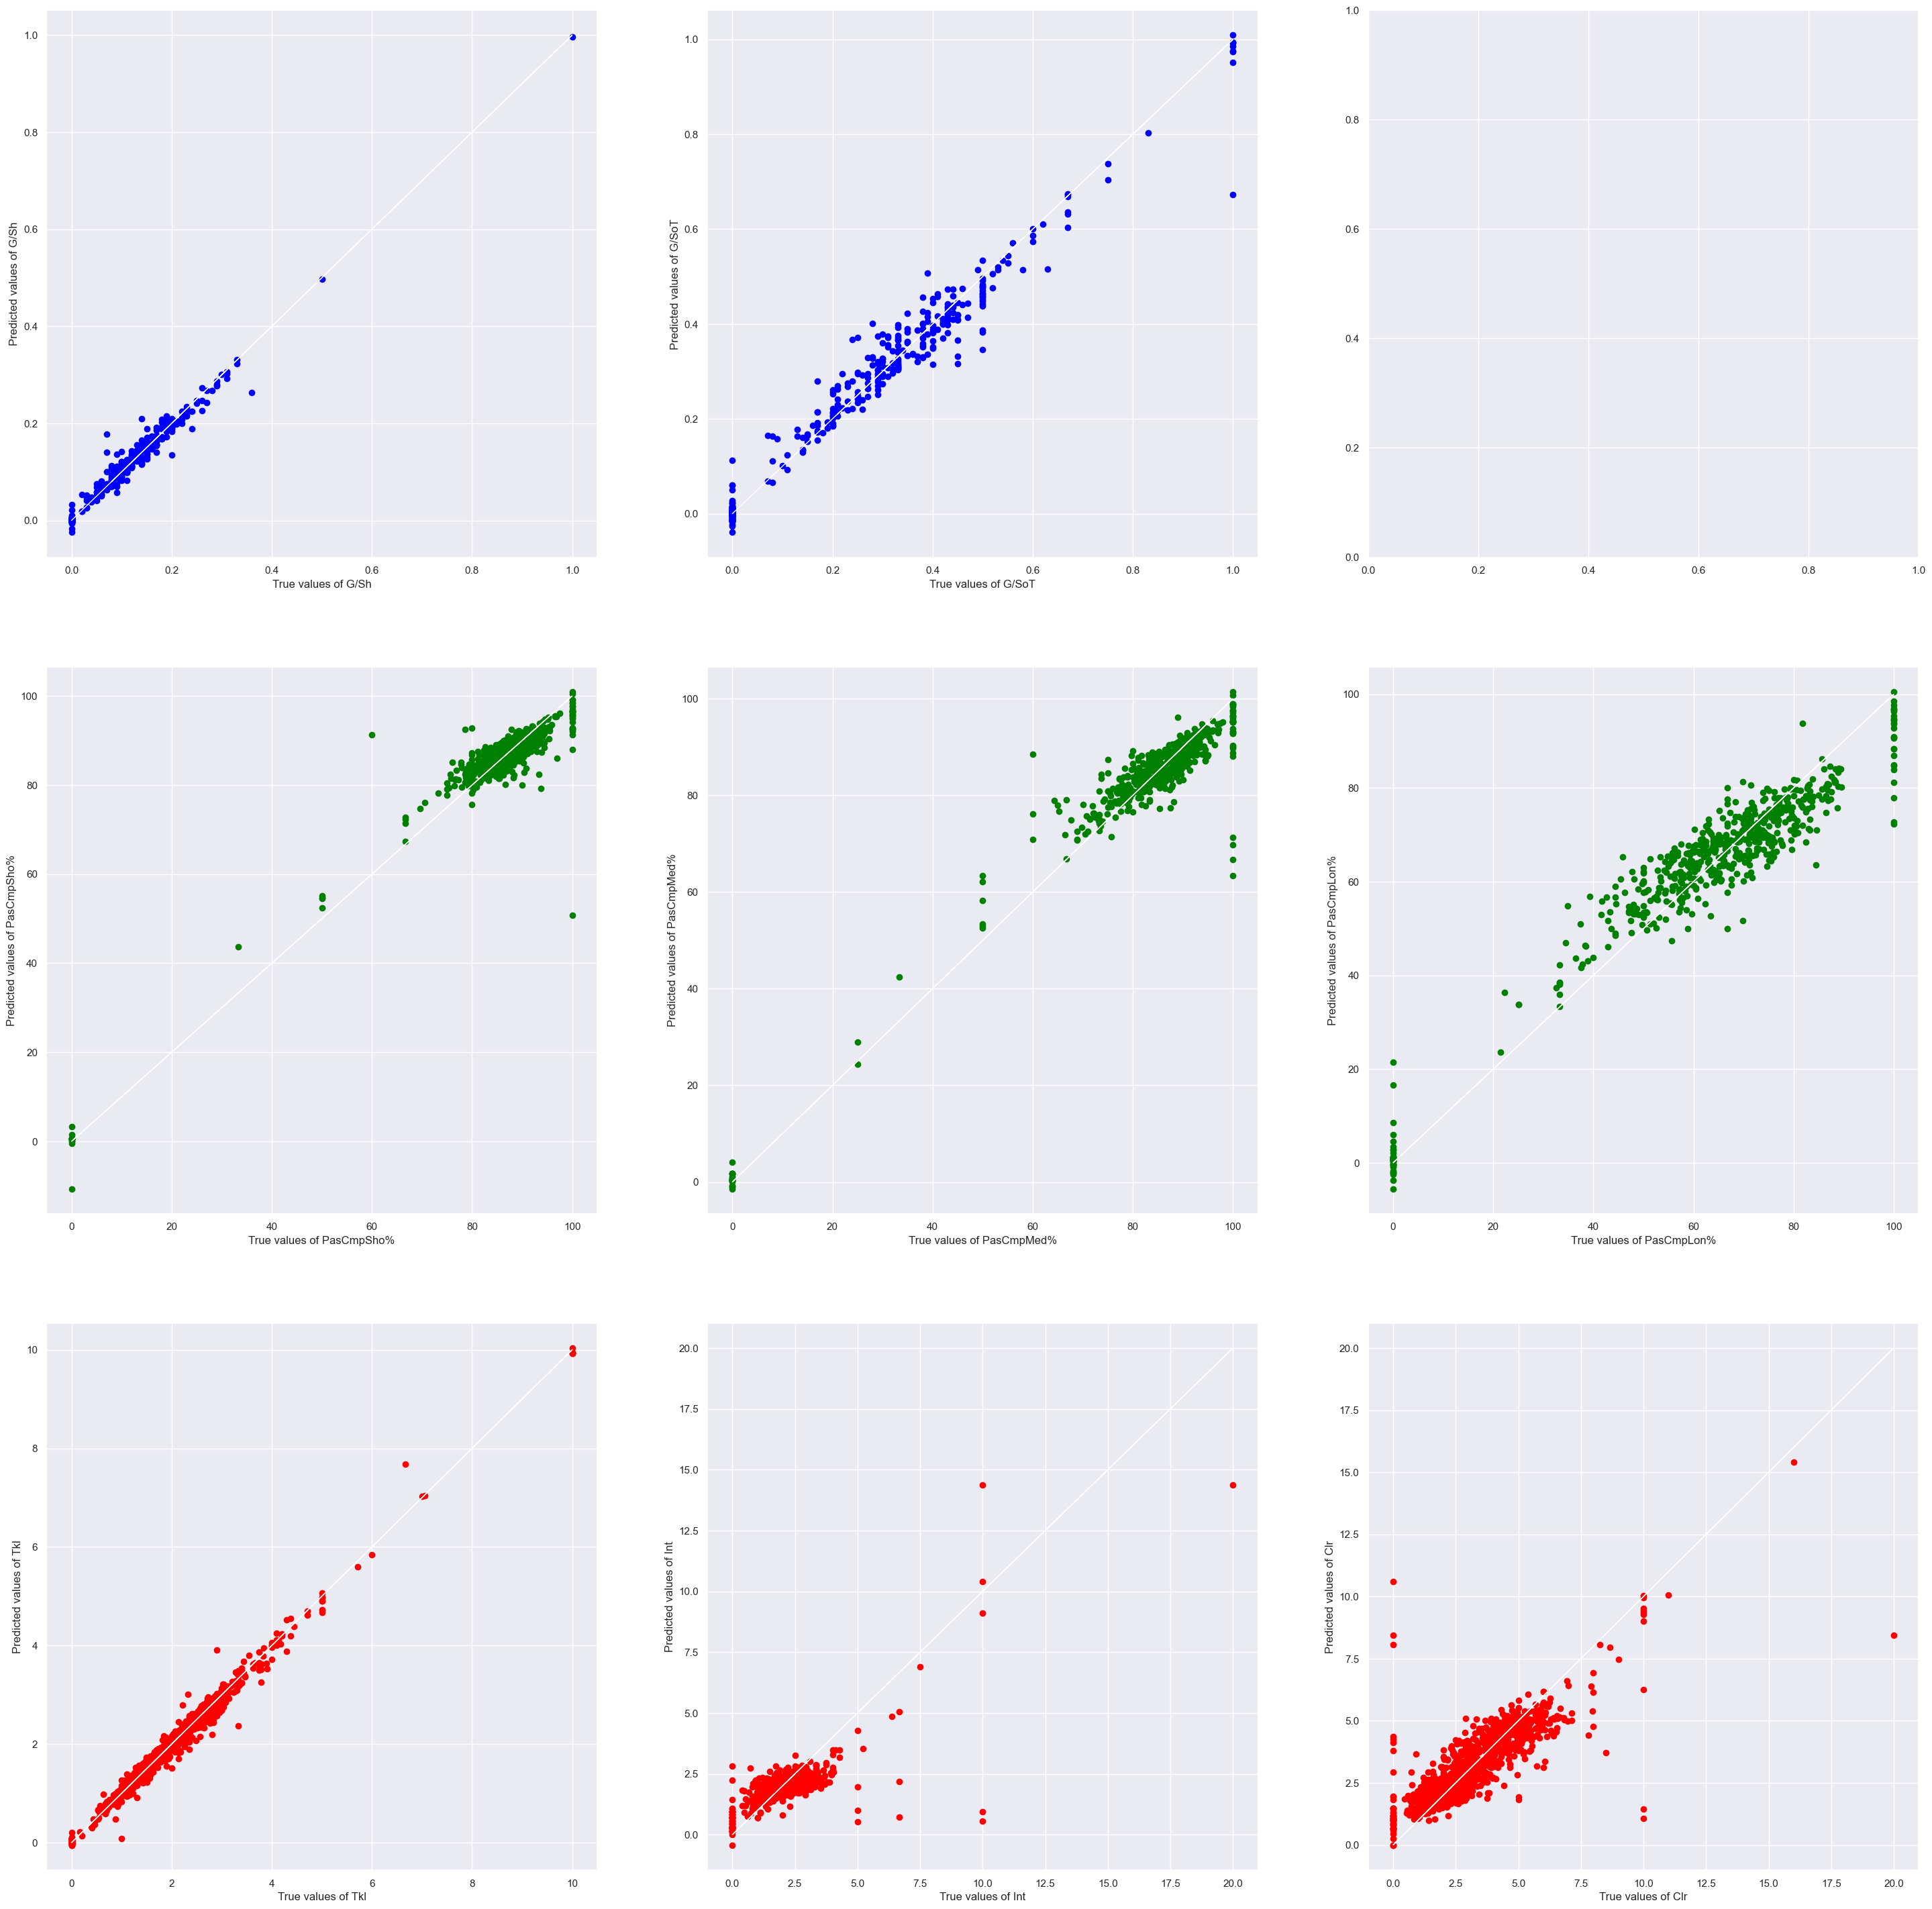

In [39]:
f, axes = plt.subplots(3, 3, figsize=(36, 36))
axes[0][0].scatter(FW_Y_GSh, FW_Relevant['P_G/Sh_GB'], color = "blue")
axes[0][0].plot(FW_Y_GSh, FW_Y_GSh, 'w-', linewidth = 1)
axes[0][0].set_xlabel("True values of G/Sh")
axes[0][0].set_ylabel("Predicted values of G/Sh")
axes[0][1].scatter(FW_Y_GSoT, FW_Relevant['P_G/SoT_GB'], color = "blue")
axes[0][1].plot(FW_Y_GSoT, FW_Y_GSoT, 'w-', linewidth = 1)
axes[0][1].set_xlabel("True values of G/SoT")
axes[0][1].set_ylabel("Predicted values of G/SoT")

axes[1][0].scatter(MF_Y_Sho, MF_Relevant['P_PasCmpSho%_GB'], color = "green")
axes[1][0].plot(MF_Y_Sho, MF_Y_Sho, 'w-', linewidth = 1)
axes[1][0].set_xlabel("True values of PasCmpSho%")
axes[1][0].set_ylabel("Predicted values of PasCmpSho%")
axes[1][1].scatter(MF_Y_Med, MF_Relevant['P_PasCmpMed%_GB'], color = "green")
axes[1][1].plot(MF_Y_Med, MF_Y_Med, 'w-', linewidth = 1)
axes[1][1].set_xlabel("True values of PasCmpMed%")
axes[1][1].set_ylabel("Predicted values of PasCmpMed%")
axes[1][2].scatter(MF_Y_Lon, MF_Relevant['P_PasCmpLon%_GB'], color = "green")
axes[1][2].plot(MF_Y_Lon, MF_Y_Lon, 'w-', linewidth = 1)
axes[1][2].set_xlabel("True values of PasCmpLon%")
axes[1][2].set_ylabel("Predicted values of PasCmpLon%")

axes[2][0].scatter(DF_Y_Tkl, DF_Relevant['P_Tkl_GB'], color = "red")
axes[2][0].plot(DF_Y_Tkl, DF_Y_Tkl, 'w-', linewidth = 1)
axes[2][0].set_xlabel("True values of Tkl")
axes[2][0].set_ylabel("Predicted values of Tkl")
axes[2][1].scatter(DF_Y_Int, DF_Relevant['P_Int_GB'], color = "red")
axes[2][1].plot(DF_Y_Int, DF_Y_Int, 'w-', linewidth = 1)
axes[2][1].set_xlabel("True values of Int")
axes[2][1].set_ylabel("Predicted values of Int")
axes[2][2].scatter(DF_Y_Clr, DF_Relevant['P_Clr_GB'], color = "red")
axes[2][2].plot(DF_Y_Clr, DF_Y_Clr, 'w-', linewidth = 1)
axes[2][2].set_xlabel("True values of Clr")
axes[2][2].set_ylabel("Predicted values of Clr")

# Top 10 players according to target variables
We created 4 different sets of tables, 1 table for each target variable, to show the results.

The first one is sorted by the actual values, folowed by the predictions by the Linear Regression, Random Forest and Gradient Boosting models respectively.

In [40]:
print(tabulate(FW_Relevant.nlargest(10, 'G/Sh')[['Player', 'G/Sh', 'P_G/Sh_LR', 'P_G/Sh_RF', 'P_G/Sh_GB']], headers=['Player', 'Actual (G/Sh)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(FW_Relevant.nlargest(10, 'G/SoT')[['Player', 'G/SoT', 'P_G/SoT_LR', 'P_G/SoT_RF', 'P_G/SoT_GB']], headers=['Player', 'Actual (G/SoT)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print()
print(tabulate(MF_Relevant.nlargest(10, 'PasShoCmp%')[['Player', 'PasShoCmp%', 'P_PasCmpSho%_LR', 'P_PasCmpSho%_RF', 'P_PasCmpSho%_GB']], headers=['Player', 'Actual (PasShoCmp%)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(MF_Relevant.nlargest(10, 'PasMedCmp%')[['Player', 'PasMedCmp%', 'P_PasCmpMed%_LR', 'P_PasCmpMed%_RF', 'P_PasCmpMed%_GB']], headers=['Player', 'Actual (PasMedCmp%)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(MF_Relevant.nlargest(10, 'PasLonCmp%')[['Player', 'PasLonCmp%', 'P_PasCmpLon%_LR', 'P_PasCmpLon%_RF', 'P_PasCmpLon%_GB']], headers=['Player', 'Actual (PasLonCmp%)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print()
print(tabulate(DF_Relevant.nlargest(10, 'Tkl')[['Player', 'Tkl', 'P_Tkl_LR', 'P_Tkl_RF', 'P_Tkl_GB']], headers=['Player', 'Actual (Tkl)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(DF_Relevant.nlargest(10, 'Int')[['Player', 'Int', 'P_Int_LR', 'P_Int_RF', 'P_Int_GB']], headers=['Player', 'Actual (Int)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(DF_Relevant.nlargest(10, 'Clr')[['Player', 'Clr', 'P_Clr_LR', 'P_Clr_RF', 'P_Clr_GB']], headers=['Player', 'Actual (Clr)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))

+---------------------------+-----------------+---------------------+-----------------+---------------------+
| Player                    |   Actual (G/Sh) |   Linear Regression |   Random Forest |   Gradient Boosting |
+===========================+=================+=====================+=================+=====================+
| Pablo Sarabia             |            1    |            1.0678   |        0.695892 |            0.996504 |
+---------------------------+-----------------+---------------------+-----------------+---------------------+
| Delano Burgzorg           |            0.5  |            0.714201 |        0.33366  |            0.497027 |
+---------------------------+-----------------+---------------------+-----------------+---------------------+
| Ibrahima Koné             |            0.36 |            0.16715  |        0.176764 |            0.263738 |
+---------------------------+-----------------+---------------------+-----------------+---------------------+
| Moustaph

In [41]:
print(tabulate(FW_Relevant.nlargest(10, 'P_G/Sh_LR')[['Player', 'G/Sh', 'P_G/Sh_LR', 'P_G/Sh_RF', 'P_G/Sh_GB']], headers=['Player', 'Actual (G/Sh)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(FW_Relevant.nlargest(10, 'P_G/SoT_LR')[['Player', 'G/SoT', 'P_G/SoT_LR', 'P_G/SoT_RF', 'P_G/SoT_GB']], headers=['Player', 'Actual (G/SoT)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print()
print(tabulate(MF_Relevant.nlargest(10, 'P_PasCmpSho%_LR')[['Player', 'PasShoCmp%', 'P_PasCmpSho%_LR', 'P_PasCmpSho%_RF', 'P_PasCmpSho%_GB']], headers=['Player', 'Actual (PasShoCmp%)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(MF_Relevant.nlargest(10, 'P_PasCmpMed%_LR')[['Player', 'PasMedCmp%', 'P_PasCmpMed%_LR', 'P_PasCmpMed%_RF', 'P_PasCmpMed%_GB']], headers=['Player', 'Actual (PasMedCmp%)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(MF_Relevant.nlargest(10, 'P_PasCmpLon%_LR')[['Player', 'PasLonCmp%', 'P_PasCmpLon%_LR', 'P_PasCmpLon%_RF', 'P_PasCmpLon%_GB']], headers=['Player', 'Actual (PasLonCmp%)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print()
print(tabulate(DF_Relevant.nlargest(10, 'P_Tkl_LR')[['Player', 'Tkl', 'P_Tkl_LR', 'P_Tkl_RF', 'P_Tkl_GB']], headers=['Player', 'Actual (Tkl)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(DF_Relevant.nlargest(10, 'P_Int_LR')[['Player', 'Int', 'P_Int_LR', 'P_Int_RF', 'P_Int_GB']], headers=['Player', 'Actual (Int)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(DF_Relevant.nlargest(10, 'P_Clr_LR')[['Player', 'Clr', 'P_Clr_LR', 'P_Clr_RF', 'P_Clr_GB']], headers=['Player', 'Actual (Clr)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))

+--------------------+-----------------+---------------------+-----------------+---------------------+
| Player             |   Actual (G/Sh) |   Linear Regression |   Random Forest |   Gradient Boosting |
+====================+=================+=====================+=================+=====================+
| Pablo Sarabia      |            1    |            1.0678   |        0.695892 |            0.996504 |
+--------------------+-----------------+---------------------+-----------------+---------------------+
| Delano Burgzorg    |            0.5  |            0.714201 |        0.33366  |            0.497027 |
+--------------------+-----------------+---------------------+-----------------+---------------------+
| Moustapha Cissé    |            0.33 |            0.528968 |        0.245182 |            0.331205 |
+--------------------+-----------------+---------------------+-----------------+---------------------+
| Divock Origi       |            0.3  |            0.440423 |        0.2

In [42]:
print(tabulate(FW_Relevant.nlargest(10, 'P_G/Sh_RF')[['Player', 'G/Sh', 'P_G/Sh_LR', 'P_G/Sh_RF', 'P_G/Sh_GB']], headers=['Player', 'Actual (G/Sh)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(FW_Relevant.nlargest(10, 'P_G/SoT_RF')[['Player', 'G/SoT', 'P_G/SoT_LR', 'P_G/SoT_RF', 'P_G/SoT_GB']], headers=['Player', 'Actual (G/SoT)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print()
print(tabulate(MF_Relevant.nlargest(10, 'P_PasCmpSho%_RF')[['Player', 'PasShoCmp%', 'P_PasCmpSho%_LR', 'P_PasCmpSho%_RF', 'P_PasCmpSho%_GB']], headers=['Player', 'Actual (PasShoCmp%)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(MF_Relevant.nlargest(10, 'P_PasCmpMed%_RF')[['Player', 'PasMedCmp%', 'P_PasCmpMed%_LR', 'P_PasCmpMed%_RF', 'P_PasCmpMed%_GB']], headers=['Player', 'Actual (PasMedCmp%)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(MF_Relevant.nlargest(10, 'P_PasCmpLon%_RF')[['Player', 'PasLonCmp%', 'P_PasCmpLon%_LR', 'P_PasCmpLon%_RF', 'P_PasCmpLon%_GB']], headers=['Player', 'Actual (PasLonCmp%)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print()
print(tabulate(DF_Relevant.nlargest(10, 'P_Tkl_RF')[['Player', 'Tkl', 'P_Tkl_LR', 'P_Tkl_RF', 'P_Tkl_GB']], headers=['Player', 'Actual (Tkl)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(DF_Relevant.nlargest(10, 'P_Int_RF')[['Player', 'Int', 'P_Int_LR', 'P_Int_RF', 'P_Int_GB']], headers=['Player', 'Actual (Int)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(DF_Relevant.nlargest(10, 'P_Clr_RF')[['Player', 'Clr', 'P_Clr_LR', 'P_Clr_RF', 'P_Clr_GB']], headers=['Player', 'Actual (Clr)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))

+---------------------------+-----------------+---------------------+-----------------+---------------------+
| Player                    |   Actual (G/Sh) |   Linear Regression |   Random Forest |   Gradient Boosting |
+===========================+=================+=====================+=================+=====================+
| Pablo Sarabia             |            1    |            1.0678   |        0.695892 |            0.996504 |
+---------------------------+-----------------+---------------------+-----------------+---------------------+
| Delano Burgzorg           |            0.5  |            0.714201 |        0.33366  |            0.497027 |
+---------------------------+-----------------+---------------------+-----------------+---------------------+
| Divock Origi              |            0.3  |            0.440423 |        0.249314 |            0.300792 |
+---------------------------+-----------------+---------------------+-----------------+---------------------+
| Moustaph

In [43]:
print(tabulate(FW_Relevant.nlargest(10, 'P_G/Sh_GB')[['Player', 'G/Sh', 'P_G/Sh_LR', 'P_G/Sh_RF', 'P_G/Sh_GB']], headers=['Player', 'Actual (G/Sh)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(FW_Relevant.nlargest(10, 'P_G/SoT_GB')[['Player', 'G/SoT', 'P_G/SoT_LR', 'P_G/SoT_RF', 'P_G/SoT_GB']], headers=['Player', 'Actual (G/SoT)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print()
print(tabulate(MF_Relevant.nlargest(10, 'P_PasCmpSho%_GB')[['Player', 'PasShoCmp%', 'P_PasCmpSho%_LR', 'P_PasCmpSho%_RF', 'P_PasCmpSho%_GB']], headers=['Player', 'Actual (PasShoCmp%)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(MF_Relevant.nlargest(10, 'P_PasCmpMed%_GB')[['Player', 'PasMedCmp%', 'P_PasCmpMed%_LR', 'P_PasCmpMed%_RF', 'P_PasCmpMed%_GB']], headers=['Player', 'Actual (PasMedCmp%)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(MF_Relevant.nlargest(10, 'P_PasCmpLon%_GB')[['Player', 'PasLonCmp%', 'P_PasCmpLon%_LR', 'P_PasCmpLon%_RF', 'P_PasCmpLon%_GB']], headers=['Player', 'Actual (PasLonCmp%)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print()
print(tabulate(DF_Relevant.nlargest(10, 'P_Tkl_GB')[['Player', 'Tkl', 'P_Tkl_LR', 'P_Tkl_RF', 'P_Tkl_GB']], headers=['Player', 'Actual (Tkl)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(DF_Relevant.nlargest(10, 'P_Int_GB')[['Player', 'Int', 'P_Int_LR', 'P_Int_RF', 'P_Int_GB']], headers=['Player', 'Actual (Int)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))
print(tabulate(DF_Relevant.nlargest(10, 'P_Clr_GB')[['Player', 'Clr', 'P_Clr_LR', 'P_Clr_RF', 'P_Clr_GB']], headers=['Player', 'Actual (Clr)', 'Linear Regression', 'Random Forest', 'Gradient Boosting'], showindex=False, tablefmt='grid'))

+---------------------------+-----------------+---------------------+-----------------+---------------------+
| Player                    |   Actual (G/Sh) |   Linear Regression |   Random Forest |   Gradient Boosting |
+===========================+=================+=====================+=================+=====================+
| Pablo Sarabia             |            1    |            1.0678   |        0.695892 |            0.996504 |
+---------------------------+-----------------+---------------------+-----------------+---------------------+
| Delano Burgzorg           |            0.5  |            0.714201 |        0.33366  |            0.497027 |
+---------------------------+-----------------+---------------------+-----------------+---------------------+
| Moustapha Cissé           |            0.33 |            0.528968 |        0.245182 |            0.331205 |
+---------------------------+-----------------+---------------------+-----------------+---------------------+
| Sven Mic

In [44]:
result = pd.DataFrame()
result['Variable'] = ['G/Sh', 'G/SoT', 'PasCmpSho%', 'PasCmpMed%', 'PasCmpLon%', 'Tkl', 'Int', 'Clr']
result['R2_LR'] = [GSh_linear_r2, GSh_linear_r2, Sho_linear_r2, Med_linear_r2, Lon_linear_r2, Tkl_linear_r2, Int_linear_r2, Clr_linear_r2]
result['MSE_LR'] = [GSh_linear_mse, GSh_linear_mse, Sho_linear_mse, Med_linear_mse, Lon_linear_mse, Tkl_linear_mse, Int_linear_mse, Clr_linear_mse]
result['R2_RF'] = [GSh_r2, GSh_r2, Sho_r2, Med_r2, Lon_r2, Tkl_r2, Int_r2, Clr_r2]
result['MSE_RF'] = [GSh_mse, GSh_mse, Sho_mse, Med_mse, Lon_mse, Tkl_mse, Int_mse, Clr_mse]
result['OOB_RF'] = [GSh_oob_score, GSh_oob_score, Sho_oob_score, Med_oob_score, Lon_oob_score, Tkl_oob_score, Int_oob_score, Clr_oob_score]
result['R2_GB'] = [GSh_gradient_r2, GSh_gradient_r2, Sho_gradient_r2, Med_gradient_r2, Lon_gradient_r2, Tkl_gradient_r2, Int_gradient_r2, Clr_gradient_r2]
result['MSE_GB'] = [GSh_gradient_mse, GSh_gradient_mse, Sho_gradient_mse, Med_gradient_mse, Lon_gradient_mse, Tkl_gradient_mse, Int_gradient_mse, Clr_gradient_mse]

print(tabulate(result, headers=['Variable', 'R2_LR', 'MSE_LR', 'R2_RF', 'MSE_RF', 'OOB_RF', 'R2_GB', 'MSE_GB'], showindex=False, tablefmt='grid'))


+------------+-----------+--------------+-----------+--------------+----------+-----------+--------------+
| Variable   |     R2_LR |       MSE_LR |     R2_RF |       MSE_RF |   OOB_RF |     R2_GB |       MSE_GB |
+============+===========+==============+===========+==============+==========+===========+==============+
| G/Sh       |  0.775384 |   0.00207446 | 0.799866  |   0.00124739 | 0.71938  |  0.897449 |   0.00063918 |
+------------+-----------+--------------+-----------+--------------+----------+-----------+--------------+
| G/SoT      |  0.775384 |   0.00207446 | 0.799866  |   0.00124739 | 0.71938  |  0.897449 |   0.00063918 |
+------------+-----------+--------------+-----------+--------------+----------+-----------+--------------+
| PasCmpSho% |  0.251324 | 201.84       | 0.888391  |  30.5019     | 0.820607 |  0.828457 |  46.8815     |
+------------+-----------+--------------+-----------+--------------+----------+-----------+--------------+
| PasCmpMed% |  0.348449 | 221.943   

# Result Analysis

As we can see, among the 3 models, there are differing results, with Linear Regression being the worst of all 3.

For the forwards, we can see that the best results are produced with the Gradient Boosting model. It has the highest R2 score and the lowest MSE. This is also shown in the graphs of the predicted values plotted against the actual values.

For the MidFielders, the Random Forest produced the best results with the highest R2 and the lowest MSE. The out-of-bag score is also high, which is another indicator that it is fairly accurate.

Finally for the Defenders, the Random Forest and the Gradient Boosting models produced similar results according to the R2 and MSE scores. This is also shown on the graphs.

We can conclude that the Random Forest and Gradient Boosting models are the best fit models, but for different roles. The Random Forest model is best fit for Forwards and Defenders, while the Gradient Boosting model is best fit for MidFielders and Defenders.